In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


 - Min class count:  976
Loaded 20496 images
Dataset type test label type: species


 - Min class count:  976
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                 | 1/2934 [00:01<1:02:14,  1.27s/it]

  0%|                                                                                                                                                   | 2/2934 [00:01<31:57,  1.53it/s]

  0%|▏                                                                                                                                                  | 3/2934 [00:01<22:16,  2.19it/s]

  0%|▏                                                                                                                                                  | 4/2934 [00:01<17:42,  2.76it/s]

  0%|▎                                                                                                                                                  | 5/2934 [00:02<15:11,  3.21it/s]

  0%|▎                                                                                                                                                  | 6/2934 [00:02<13:39,  3.57it/s]

  0%|▎                                                                                                                                                  | 7/2934 [00:02<12:42,  3.84it/s]

  0%|▍                                                                                                                                                  | 8/2934 [00:02<12:04,  4.04it/s]

  0%|▍                                                                                                                                                  | 9/2934 [00:03<11:38,  4.19it/s]

  0%|▍                                                                                                                                                 | 10/2934 [00:03<11:20,  4.29it/s]

  0%|▌                                                                                                                                                 | 11/2934 [00:03<11:09,  4.37it/s]

  0%|▌                                                                                                                                                 | 12/2934 [00:03<11:00,  4.42it/s]

  0%|▋                                                                                                                                                 | 13/2934 [00:03<10:54,  4.46it/s]

  0%|▋                                                                                                                                                 | 14/2934 [00:04<10:51,  4.48it/s]

  1%|▋                                                                                                                                                 | 15/2934 [00:04<10:47,  4.51it/s]

  1%|▊                                                                                                                                                 | 16/2934 [00:04<10:45,  4.52it/s]

  1%|▊                                                                                                                                                 | 17/2934 [00:04<10:44,  4.53it/s]

  1%|▉                                                                                                                                                 | 18/2934 [00:05<10:43,  4.53it/s]

  1%|▉                                                                                                                                                 | 19/2934 [00:05<10:42,  4.54it/s]

  1%|▉                                                                                                                                                 | 20/2934 [00:05<10:41,  4.54it/s]

  1%|█                                                                                                                                                 | 21/2934 [00:05<10:41,  4.54it/s]

  1%|█                                                                                                                                                 | 22/2934 [00:05<10:40,  4.54it/s]

  1%|█▏                                                                                                                                                | 23/2934 [00:06<10:40,  4.55it/s]

  1%|█▏                                                                                                                                                | 24/2934 [00:06<10:39,  4.55it/s]

  1%|█▏                                                                                                                                                | 25/2934 [00:06<10:39,  4.55it/s]

  1%|█▎                                                                                                                                                | 26/2934 [00:06<10:39,  4.55it/s]

  1%|█▎                                                                                                                                                | 27/2934 [00:06<10:39,  4.55it/s]

  1%|█▍                                                                                                                                                | 28/2934 [00:07<10:39,  4.55it/s]

  1%|█▍                                                                                                                                                | 29/2934 [00:07<10:38,  4.55it/s]

  1%|█▍                                                                                                                                                | 30/2934 [00:07<10:38,  4.55it/s]

  1%|█▌                                                                                                                                                | 31/2934 [00:07<10:37,  4.55it/s]

  1%|█▌                                                                                                                                                | 32/2934 [00:08<10:38,  4.55it/s]

  1%|█▋                                                                                                                                                | 33/2934 [00:08<10:37,  4.55it/s]

  1%|█▋                                                                                                                                                | 34/2934 [00:08<10:37,  4.55it/s]

  1%|█▋                                                                                                                                                | 35/2934 [00:08<10:37,  4.54it/s]

  1%|█▊                                                                                                                                                | 36/2934 [00:08<10:37,  4.54it/s]

  1%|█▊                                                                                                                                                | 37/2934 [00:09<10:37,  4.55it/s]

  1%|█▉                                                                                                                                                | 38/2934 [00:09<10:36,  4.55it/s]

  1%|█▉                                                                                                                                                | 39/2934 [00:09<10:36,  4.55it/s]

  1%|█▉                                                                                                                                                | 40/2934 [00:09<10:36,  4.55it/s]

  1%|██                                                                                                                                                | 41/2934 [00:10<10:35,  4.55it/s]

  1%|██                                                                                                                                                | 42/2934 [00:10<10:36,  4.55it/s]

  1%|██▏                                                                                                                                               | 43/2934 [00:10<10:35,  4.55it/s]

  1%|██▏                                                                                                                                               | 44/2934 [00:10<10:35,  4.55it/s]

  2%|██▏                                                                                                                                               | 45/2934 [00:10<10:34,  4.55it/s]

  2%|██▎                                                                                                                                               | 46/2934 [00:11<10:34,  4.55it/s]

  2%|██▎                                                                                                                                               | 47/2934 [00:11<10:34,  4.55it/s]

  2%|██▍                                                                                                                                               | 48/2934 [00:11<10:34,  4.55it/s]

  2%|██▍                                                                                                                                               | 49/2934 [00:11<10:34,  4.55it/s]

  2%|██▍                                                                                                                                               | 50/2934 [00:12<10:33,  4.55it/s]

  2%|██▌                                                                                                                                               | 51/2934 [00:12<10:33,  4.55it/s]

  2%|██▌                                                                                                                                               | 52/2934 [00:12<10:33,  4.55it/s]

  2%|██▋                                                                                                                                               | 53/2934 [00:12<10:33,  4.55it/s]

  2%|██▋                                                                                                                                               | 54/2934 [00:12<10:33,  4.55it/s]

  2%|██▋                                                                                                                                               | 55/2934 [00:13<10:32,  4.55it/s]

  2%|██▊                                                                                                                                               | 56/2934 [00:13<10:33,  4.55it/s]

  2%|██▊                                                                                                                                               | 57/2934 [00:13<10:32,  4.55it/s]

  2%|██▉                                                                                                                                               | 58/2934 [00:13<10:32,  4.55it/s]

  2%|██▉                                                                                                                                               | 59/2934 [00:14<10:31,  4.55it/s]

  2%|██▉                                                                                                                                               | 60/2934 [00:14<10:31,  4.55it/s]

  2%|███                                                                                                                                               | 61/2934 [00:14<10:31,  4.55it/s]

  2%|███                                                                                                                                               | 62/2934 [00:14<10:31,  4.55it/s]

  2%|███▏                                                                                                                                              | 63/2934 [00:14<10:31,  4.55it/s]

  2%|███▏                                                                                                                                              | 64/2934 [00:15<10:31,  4.55it/s]

  2%|███▏                                                                                                                                              | 65/2934 [00:15<10:30,  4.55it/s]

  2%|███▎                                                                                                                                              | 66/2934 [00:15<10:30,  4.55it/s]

  2%|███▎                                                                                                                                              | 67/2934 [00:15<10:30,  4.55it/s]

  2%|███▍                                                                                                                                              | 68/2934 [00:16<10:30,  4.55it/s]

  2%|███▍                                                                                                                                              | 69/2934 [00:16<10:29,  4.55it/s]

  2%|███▍                                                                                                                                              | 70/2934 [00:16<10:30,  4.55it/s]

  2%|███▌                                                                                                                                              | 71/2934 [00:16<10:29,  4.55it/s]

  2%|███▌                                                                                                                                              | 72/2934 [00:16<10:29,  4.55it/s]

  2%|███▋                                                                                                                                              | 73/2934 [00:17<10:29,  4.55it/s]

  3%|███▋                                                                                                                                              | 74/2934 [00:17<10:29,  4.55it/s]

  3%|███▋                                                                                                                                              | 75/2934 [00:17<10:28,  4.55it/s]

  3%|███▊                                                                                                                                              | 76/2934 [00:17<10:28,  4.55it/s]

  3%|███▊                                                                                                                                              | 77/2934 [00:17<10:28,  4.55it/s]

  3%|███▉                                                                                                                                              | 78/2934 [00:18<10:27,  4.55it/s]

  3%|███▉                                                                                                                                              | 79/2934 [00:18<10:27,  4.55it/s]

  3%|███▉                                                                                                                                              | 80/2934 [00:18<10:27,  4.55it/s]

  3%|████                                                                                                                                              | 81/2934 [00:18<10:27,  4.55it/s]

  3%|████                                                                                                                                              | 82/2934 [00:19<10:26,  4.55it/s]

  3%|████▏                                                                                                                                             | 83/2934 [00:19<10:26,  4.55it/s]

  3%|████▏                                                                                                                                             | 84/2934 [00:19<10:26,  4.55it/s]

  3%|████▏                                                                                                                                             | 85/2934 [00:19<10:26,  4.55it/s]

  3%|████▎                                                                                                                                             | 86/2934 [00:19<10:26,  4.55it/s]

  3%|████▎                                                                                                                                             | 87/2934 [00:20<10:25,  4.55it/s]

  3%|████▍                                                                                                                                             | 88/2934 [00:20<10:25,  4.55it/s]

  3%|████▍                                                                                                                                             | 89/2934 [00:20<10:25,  4.55it/s]

  3%|████▍                                                                                                                                             | 90/2934 [00:20<10:24,  4.55it/s]

  3%|████▌                                                                                                                                             | 91/2934 [00:21<10:25,  4.55it/s]

  3%|████▌                                                                                                                                             | 92/2934 [00:21<10:24,  4.55it/s]

  3%|████▋                                                                                                                                             | 93/2934 [00:21<10:24,  4.55it/s]

  3%|████▋                                                                                                                                             | 94/2934 [00:21<10:24,  4.55it/s]

  3%|████▋                                                                                                                                             | 95/2934 [00:21<10:24,  4.55it/s]

  3%|████▊                                                                                                                                             | 96/2934 [00:22<10:24,  4.55it/s]

  3%|████▊                                                                                                                                             | 97/2934 [00:22<10:23,  4.55it/s]

  3%|████▉                                                                                                                                             | 98/2934 [00:22<10:23,  4.55it/s]

  3%|████▉                                                                                                                                             | 99/2934 [00:22<10:23,  4.55it/s]

  3%|████▉                                                                                                                                            | 100/2934 [00:23<10:22,  4.55it/s]

  3%|████▉                                                                                                                                            | 101/2934 [00:23<10:22,  4.55it/s]

  3%|█████                                                                                                                                            | 102/2934 [00:23<10:22,  4.55it/s]

  4%|█████                                                                                                                                            | 103/2934 [00:23<10:22,  4.55it/s]

  4%|█████▏                                                                                                                                           | 104/2934 [00:23<10:21,  4.55it/s]

  4%|█████▏                                                                                                                                           | 105/2934 [00:24<10:22,  4.55it/s]

  4%|█████▏                                                                                                                                           | 106/2934 [00:24<10:21,  4.55it/s]

  4%|█████▎                                                                                                                                           | 107/2934 [00:24<10:21,  4.55it/s]

  4%|█████▎                                                                                                                                           | 108/2934 [00:24<10:20,  4.55it/s]

  4%|█████▍                                                                                                                                           | 109/2934 [00:25<10:21,  4.55it/s]

  4%|█████▍                                                                                                                                           | 110/2934 [00:25<10:20,  4.55it/s]

  4%|█████▍                                                                                                                                           | 111/2934 [00:25<10:20,  4.55it/s]

  4%|█████▌                                                                                                                                           | 112/2934 [00:25<10:20,  4.55it/s]

  4%|█████▌                                                                                                                                           | 113/2934 [00:25<10:20,  4.55it/s]

  4%|█████▋                                                                                                                                           | 114/2934 [00:26<10:19,  4.55it/s]

  4%|█████▋                                                                                                                                           | 115/2934 [00:26<10:19,  4.55it/s]

  4%|█████▋                                                                                                                                           | 116/2934 [00:26<10:19,  4.55it/s]

  4%|█████▊                                                                                                                                           | 117/2934 [00:26<10:19,  4.55it/s]

  4%|█████▊                                                                                                                                           | 118/2934 [00:26<10:19,  4.55it/s]

  4%|█████▉                                                                                                                                           | 119/2934 [00:27<10:19,  4.55it/s]

  4%|█████▉                                                                                                                                           | 120/2934 [00:27<10:19,  4.54it/s]

  4%|█████▉                                                                                                                                           | 121/2934 [00:27<10:18,  4.55it/s]

  4%|██████                                                                                                                                           | 122/2934 [00:27<10:18,  4.55it/s]

  4%|██████                                                                                                                                           | 123/2934 [00:28<10:18,  4.55it/s]

  4%|██████▏                                                                                                                                          | 124/2934 [00:28<10:17,  4.55it/s]

  4%|██████▏                                                                                                                                          | 125/2934 [00:28<10:17,  4.55it/s]

  4%|██████▏                                                                                                                                          | 126/2934 [00:28<10:17,  4.55it/s]

  4%|██████▎                                                                                                                                          | 127/2934 [00:28<10:17,  4.55it/s]

  4%|██████▎                                                                                                                                          | 128/2934 [00:29<10:16,  4.55it/s]

  4%|██████▍                                                                                                                                          | 129/2934 [00:29<10:16,  4.55it/s]

  4%|██████▍                                                                                                                                          | 130/2934 [00:29<10:16,  4.55it/s]

  4%|██████▍                                                                                                                                          | 131/2934 [00:29<10:16,  4.55it/s]

  4%|██████▌                                                                                                                                          | 132/2934 [00:30<10:15,  4.55it/s]

  5%|██████▌                                                                                                                                          | 133/2934 [00:30<10:16,  4.55it/s]

  5%|██████▌                                                                                                                                          | 134/2934 [00:30<10:15,  4.55it/s]

  5%|██████▋                                                                                                                                          | 135/2934 [00:30<10:15,  4.55it/s]

  5%|██████▋                                                                                                                                          | 136/2934 [00:30<10:15,  4.55it/s]

  5%|██████▊                                                                                                                                          | 137/2934 [00:31<10:15,  4.55it/s]

  5%|██████▊                                                                                                                                          | 138/2934 [00:31<10:14,  4.55it/s]

  5%|██████▊                                                                                                                                          | 139/2934 [00:31<10:14,  4.55it/s]

  5%|██████▉                                                                                                                                          | 140/2934 [00:31<10:14,  4.55it/s]

  5%|██████▉                                                                                                                                          | 141/2934 [00:32<10:14,  4.55it/s]

  5%|███████                                                                                                                                          | 142/2934 [00:32<10:13,  4.55it/s]

  5%|███████                                                                                                                                          | 143/2934 [00:32<10:13,  4.55it/s]

  5%|███████                                                                                                                                          | 144/2934 [00:32<10:13,  4.55it/s]

  5%|███████▏                                                                                                                                         | 145/2934 [00:32<10:13,  4.55it/s]

  5%|███████▏                                                                                                                                         | 146/2934 [00:33<10:12,  4.55it/s]

  5%|███████▎                                                                                                                                         | 147/2934 [00:33<10:13,  4.55it/s]

  5%|███████▎                                                                                                                                         | 148/2934 [00:33<10:12,  4.55it/s]

  5%|███████▎                                                                                                                                         | 149/2934 [00:33<10:12,  4.55it/s]

  5%|███████▍                                                                                                                                         | 150/2934 [00:34<10:11,  4.55it/s]

  5%|███████▍                                                                                                                                         | 151/2934 [00:34<10:12,  4.55it/s]

  5%|███████▌                                                                                                                                         | 152/2934 [00:34<10:11,  4.55it/s]

  5%|███████▌                                                                                                                                         | 153/2934 [00:34<10:11,  4.55it/s]

  5%|███████▌                                                                                                                                         | 154/2934 [00:34<10:11,  4.54it/s]

  5%|███████▋                                                                                                                                         | 155/2934 [00:35<10:11,  4.55it/s]

  5%|███████▋                                                                                                                                         | 156/2934 [00:35<10:11,  4.55it/s]

  5%|███████▊                                                                                                                                         | 157/2934 [00:35<10:10,  4.55it/s]

  5%|███████▊                                                                                                                                         | 158/2934 [00:35<10:10,  4.55it/s]

  5%|███████▊                                                                                                                                         | 159/2934 [00:36<10:10,  4.55it/s]

  5%|███████▉                                                                                                                                         | 160/2934 [00:36<10:09,  4.55it/s]

  5%|███████▉                                                                                                                                         | 161/2934 [00:36<10:10,  4.55it/s]

  6%|████████                                                                                                                                         | 162/2934 [00:36<10:09,  4.55it/s]

  6%|████████                                                                                                                                         | 163/2934 [00:36<10:09,  4.55it/s]

  6%|████████                                                                                                                                         | 164/2934 [00:37<10:08,  4.55it/s]

  6%|████████▏                                                                                                                                        | 165/2934 [00:37<10:09,  4.55it/s]

  6%|████████▏                                                                                                                                        | 166/2934 [00:37<10:08,  4.55it/s]

  6%|████████▎                                                                                                                                        | 167/2934 [00:37<10:08,  4.55it/s]

  6%|████████▎                                                                                                                                        | 168/2934 [00:37<10:08,  4.55it/s]

  6%|████████▎                                                                                                                                        | 169/2934 [00:38<10:07,  4.55it/s]

  6%|████████▍                                                                                                                                        | 170/2934 [00:38<10:07,  4.55it/s]

  6%|████████▍                                                                                                                                        | 171/2934 [00:38<10:07,  4.55it/s]

  6%|████████▌                                                                                                                                        | 172/2934 [00:38<10:07,  4.55it/s]

  6%|████████▌                                                                                                                                        | 173/2934 [00:39<10:06,  4.55it/s]

  6%|████████▌                                                                                                                                        | 174/2934 [00:39<10:06,  4.55it/s]

  6%|████████▋                                                                                                                                        | 175/2934 [00:39<10:06,  4.55it/s]

  6%|████████▋                                                                                                                                        | 176/2934 [00:39<10:06,  4.55it/s]

  6%|████████▋                                                                                                                                        | 177/2934 [00:39<10:06,  4.55it/s]

  6%|████████▊                                                                                                                                        | 178/2934 [00:40<10:05,  4.55it/s]

  6%|████████▊                                                                                                                                        | 179/2934 [00:40<10:05,  4.55it/s]

  6%|████████▉                                                                                                                                        | 180/2934 [00:40<10:05,  4.55it/s]

  6%|████████▉                                                                                                                                        | 181/2934 [00:40<10:04,  4.55it/s]

  6%|████████▉                                                                                                                                        | 182/2934 [00:41<10:05,  4.55it/s]

  6%|█████████                                                                                                                                        | 183/2934 [00:41<10:04,  4.55it/s]

  6%|█████████                                                                                                                                        | 184/2934 [00:41<10:04,  4.55it/s]

  6%|█████████▏                                                                                                                                       | 185/2934 [00:41<10:04,  4.55it/s]

  6%|█████████▏                                                                                                                                       | 186/2934 [00:41<10:04,  4.55it/s]

  6%|█████████▏                                                                                                                                       | 187/2934 [00:42<10:03,  4.55it/s]

  6%|█████████▎                                                                                                                                       | 188/2934 [00:42<10:03,  4.55it/s]

  6%|█████████▎                                                                                                                                       | 189/2934 [00:42<10:03,  4.55it/s]

  6%|█████████▍                                                                                                                                       | 190/2934 [00:42<10:03,  4.55it/s]

  7%|█████████▍                                                                                                                                       | 191/2934 [00:43<10:03,  4.55it/s]

  7%|█████████▍                                                                                                                                       | 192/2934 [00:43<10:02,  4.55it/s]

  7%|█████████▌                                                                                                                                       | 193/2934 [00:43<10:02,  4.55it/s]

  7%|█████████▌                                                                                                                                       | 194/2934 [00:43<10:02,  4.55it/s]

  7%|█████████▋                                                                                                                                       | 195/2934 [00:43<10:02,  4.55it/s]

  7%|█████████▋                                                                                                                                       | 196/2934 [00:44<10:02,  4.54it/s]

  7%|█████████▋                                                                                                                                       | 197/2934 [00:44<10:01,  4.55it/s]

  7%|█████████▊                                                                                                                                       | 198/2934 [00:44<10:01,  4.55it/s]

  7%|█████████▊                                                                                                                                       | 199/2934 [00:44<10:01,  4.55it/s]

  7%|█████████▉                                                                                                                                       | 200/2934 [00:45<10:01,  4.55it/s]

  7%|█████████▉                                                                                                                                       | 201/2934 [00:45<10:01,  4.55it/s]

  7%|█████████▉                                                                                                                                       | 202/2934 [00:45<10:00,  4.55it/s]

  7%|██████████                                                                                                                                       | 203/2934 [00:45<10:00,  4.55it/s]

  7%|██████████                                                                                                                                       | 204/2934 [00:45<10:00,  4.55it/s]

  7%|██████████▏                                                                                                                                      | 205/2934 [00:46<09:59,  4.55it/s]

  7%|██████████▏                                                                                                                                      | 206/2934 [00:46<09:59,  4.55it/s]

  7%|██████████▏                                                                                                                                      | 207/2934 [00:46<09:59,  4.55it/s]

  7%|██████████▎                                                                                                                                      | 208/2934 [00:46<09:59,  4.55it/s]

  7%|██████████▎                                                                                                                                      | 209/2934 [00:47<09:58,  4.55it/s]

  7%|██████████▍                                                                                                                                      | 210/2934 [00:47<09:58,  4.55it/s]

  7%|██████████▍                                                                                                                                      | 211/2934 [00:47<09:58,  4.55it/s]

  7%|██████████▍                                                                                                                                      | 212/2934 [00:47<09:58,  4.55it/s]

  7%|██████████▌                                                                                                                                      | 213/2934 [00:47<09:58,  4.55it/s]

  7%|██████████▌                                                                                                                                      | 214/2934 [00:48<09:58,  4.55it/s]

  7%|██████████▋                                                                                                                                      | 215/2934 [00:48<09:57,  4.55it/s]

  7%|██████████▋                                                                                                                                      | 216/2934 [00:48<09:57,  4.55it/s]

  7%|██████████▋                                                                                                                                      | 217/2934 [00:48<09:57,  4.55it/s]

  7%|██████████▊                                                                                                                                      | 218/2934 [00:48<09:57,  4.55it/s]

  7%|██████████▊                                                                                                                                      | 219/2934 [00:49<09:56,  4.55it/s]

  7%|██████████▊                                                                                                                                      | 220/2934 [00:49<09:56,  4.55it/s]

  8%|██████████▉                                                                                                                                      | 221/2934 [00:49<09:56,  4.55it/s]

  8%|██████████▉                                                                                                                                      | 222/2934 [00:49<09:56,  4.55it/s]

  8%|███████████                                                                                                                                      | 223/2934 [00:50<09:56,  4.55it/s]

  8%|███████████                                                                                                                                      | 224/2934 [00:50<09:56,  4.55it/s]

  8%|███████████                                                                                                                                      | 225/2934 [00:50<09:55,  4.55it/s]

  8%|███████████▏                                                                                                                                     | 226/2934 [00:50<09:55,  4.55it/s]

  8%|███████████▏                                                                                                                                     | 227/2934 [00:50<09:55,  4.55it/s]

  8%|███████████▎                                                                                                                                     | 228/2934 [00:51<09:55,  4.55it/s]

  8%|███████████▎                                                                                                                                     | 229/2934 [00:51<09:54,  4.55it/s]

  8%|███████████▎                                                                                                                                     | 230/2934 [00:51<09:54,  4.55it/s]

  8%|███████████▍                                                                                                                                     | 231/2934 [00:51<09:54,  4.55it/s]

  8%|███████████▍                                                                                                                                     | 232/2934 [00:52<09:54,  4.55it/s]

  8%|███████████▌                                                                                                                                     | 233/2934 [00:52<09:53,  4.55it/s]

  8%|███████████▌                                                                                                                                     | 234/2934 [00:52<09:53,  4.55it/s]

  8%|███████████▌                                                                                                                                     | 235/2934 [00:52<09:53,  4.55it/s]

  8%|███████████▋                                                                                                                                     | 236/2934 [00:52<09:53,  4.55it/s]

  8%|███████████▋                                                                                                                                     | 237/2934 [00:53<09:52,  4.55it/s]

  8%|███████████▊                                                                                                                                     | 238/2934 [00:53<09:52,  4.55it/s]

  8%|███████████▊                                                                                                                                     | 239/2934 [00:53<09:52,  4.55it/s]

  8%|███████████▊                                                                                                                                     | 240/2934 [00:53<09:51,  4.55it/s]

  8%|███████████▉                                                                                                                                     | 241/2934 [00:54<09:51,  4.55it/s]

  8%|███████████▉                                                                                                                                     | 242/2934 [00:54<09:51,  4.55it/s]

  8%|████████████                                                                                                                                     | 243/2934 [00:54<09:51,  4.55it/s]

  8%|████████████                                                                                                                                     | 244/2934 [00:54<09:50,  4.55it/s]

  8%|████████████                                                                                                                                     | 245/2934 [00:54<09:51,  4.55it/s]

  8%|████████████▏                                                                                                                                    | 246/2934 [00:55<09:50,  4.55it/s]

  8%|████████████▏                                                                                                                                    | 247/2934 [00:55<09:50,  4.55it/s]

  8%|████████████▎                                                                                                                                    | 248/2934 [00:55<09:50,  4.55it/s]

  8%|████████████▎                                                                                                                                    | 249/2934 [00:55<09:50,  4.55it/s]

  9%|████████████▎                                                                                                                                    | 250/2934 [00:56<09:50,  4.54it/s]

  9%|████████████▍                                                                                                                                    | 251/2934 [00:56<09:50,  4.55it/s]

  9%|████████████▍                                                                                                                                    | 252/2934 [00:56<09:50,  4.55it/s]

  9%|████████████▌                                                                                                                                    | 253/2934 [00:56<09:49,  4.55it/s]

  9%|████████████▌                                                                                                                                    | 254/2934 [00:56<09:49,  4.55it/s]

  9%|████████████▌                                                                                                                                    | 255/2934 [00:57<09:49,  4.55it/s]

  9%|████████████▋                                                                                                                                    | 256/2934 [00:57<09:48,  4.55it/s]

  9%|████████████▋                                                                                                                                    | 257/2934 [00:57<09:48,  4.55it/s]

  9%|████████████▊                                                                                                                                    | 258/2934 [00:57<09:48,  4.55it/s]

  9%|████████████▊                                                                                                                                    | 259/2934 [00:58<09:48,  4.55it/s]

  9%|████████████▊                                                                                                                                    | 260/2934 [00:58<09:48,  4.55it/s]

  9%|████████████▉                                                                                                                                    | 261/2934 [00:58<09:47,  4.55it/s]

  9%|████████████▉                                                                                                                                    | 262/2934 [00:58<09:47,  4.55it/s]

  9%|████████████▉                                                                                                                                    | 263/2934 [00:58<09:47,  4.55it/s]

  9%|█████████████                                                                                                                                    | 264/2934 [00:59<09:46,  4.55it/s]

  9%|█████████████                                                                                                                                    | 265/2934 [00:59<09:46,  4.55it/s]

  9%|█████████████▏                                                                                                                                   | 266/2934 [00:59<09:46,  4.55it/s]

  9%|█████████████▏                                                                                                                                   | 267/2934 [00:59<09:46,  4.55it/s]

  9%|█████████████▏                                                                                                                                   | 268/2934 [00:59<09:45,  4.55it/s]

  9%|█████████████▎                                                                                                                                   | 269/2934 [01:00<09:46,  4.55it/s]

  9%|█████████████▎                                                                                                                                   | 270/2934 [01:00<09:45,  4.55it/s]

  9%|█████████████▍                                                                                                                                   | 271/2934 [01:00<09:45,  4.55it/s]

  9%|█████████████▍                                                                                                                                   | 272/2934 [01:00<09:45,  4.55it/s]

  9%|█████████████▍                                                                                                                                   | 273/2934 [01:01<09:45,  4.55it/s]

  9%|█████████████▌                                                                                                                                   | 274/2934 [01:01<09:44,  4.55it/s]

  9%|█████████████▌                                                                                                                                   | 275/2934 [01:01<09:44,  4.55it/s]

  9%|█████████████▋                                                                                                                                   | 276/2934 [01:01<09:44,  4.55it/s]

  9%|█████████████▋                                                                                                                                   | 277/2934 [01:01<09:44,  4.55it/s]

  9%|█████████████▋                                                                                                                                   | 278/2934 [01:02<09:43,  4.55it/s]

 10%|█████████████▊                                                                                                                                   | 279/2934 [01:02<09:43,  4.55it/s]

 10%|█████████████▊                                                                                                                                   | 280/2934 [01:02<09:43,  4.55it/s]

 10%|█████████████▉                                                                                                                                   | 281/2934 [01:02<09:43,  4.55it/s]

 10%|█████████████▉                                                                                                                                   | 282/2934 [01:03<09:43,  4.55it/s]

 10%|█████████████▉                                                                                                                                   | 283/2934 [01:03<09:42,  4.55it/s]

 10%|██████████████                                                                                                                                   | 284/2934 [01:03<09:42,  4.55it/s]

 10%|██████████████                                                                                                                                   | 285/2934 [01:03<09:42,  4.55it/s]

 10%|██████████████▏                                                                                                                                  | 286/2934 [01:03<09:42,  4.55it/s]

 10%|██████████████▏                                                                                                                                  | 287/2934 [01:04<09:42,  4.55it/s]

 10%|██████████████▏                                                                                                                                  | 288/2934 [01:04<09:41,  4.55it/s]

 10%|██████████████▎                                                                                                                                  | 289/2934 [01:04<09:41,  4.55it/s]

 10%|██████████████▎                                                                                                                                  | 290/2934 [01:04<09:41,  4.54it/s]

 10%|██████████████▍                                                                                                                                  | 291/2934 [01:05<09:41,  4.55it/s]

 10%|██████████████▍                                                                                                                                  | 292/2934 [01:05<09:40,  4.55it/s]

 10%|██████████████▍                                                                                                                                  | 293/2934 [01:05<09:40,  4.55it/s]

 10%|██████████████▌                                                                                                                                  | 294/2934 [01:05<09:40,  4.55it/s]

 10%|██████████████▌                                                                                                                                  | 295/2934 [01:05<09:40,  4.55it/s]

 10%|██████████████▋                                                                                                                                  | 296/2934 [01:06<09:40,  4.55it/s]

 10%|██████████████▋                                                                                                                                  | 297/2934 [01:06<09:39,  4.55it/s]

 10%|██████████████▋                                                                                                                                  | 298/2934 [01:06<09:39,  4.55it/s]

 10%|██████████████▊                                                                                                                                  | 299/2934 [01:06<09:39,  4.55it/s]

 10%|██████████████▊                                                                                                                                  | 300/2934 [01:07<09:39,  4.55it/s]

 10%|██████████████▉                                                                                                                                  | 301/2934 [01:07<09:38,  4.55it/s]

 10%|██████████████▉                                                                                                                                  | 302/2934 [01:07<09:38,  4.55it/s]

 10%|██████████████▉                                                                                                                                  | 303/2934 [01:07<09:38,  4.55it/s]

 10%|███████████████                                                                                                                                  | 304/2934 [01:07<09:38,  4.55it/s]

 10%|███████████████                                                                                                                                  | 305/2934 [01:08<09:37,  4.55it/s]

 10%|███████████████                                                                                                                                  | 306/2934 [01:08<09:37,  4.55it/s]

 10%|███████████████▏                                                                                                                                 | 307/2934 [01:08<09:37,  4.55it/s]

 10%|███████████████▏                                                                                                                                 | 308/2934 [01:08<09:37,  4.55it/s]

 11%|███████████████▎                                                                                                                                 | 309/2934 [01:08<09:36,  4.55it/s]

 11%|███████████████▎                                                                                                                                 | 310/2934 [01:09<09:36,  4.55it/s]

 11%|███████████████▎                                                                                                                                 | 311/2934 [01:09<09:36,  4.55it/s]

 11%|███████████████▍                                                                                                                                 | 312/2934 [01:09<09:36,  4.55it/s]

 11%|███████████████▍                                                                                                                                 | 313/2934 [01:09<09:35,  4.55it/s]

 11%|███████████████▌                                                                                                                                 | 314/2934 [01:10<09:36,  4.55it/s]

 11%|███████████████▌                                                                                                                                 | 315/2934 [01:10<09:35,  4.55it/s]

 11%|███████████████▌                                                                                                                                 | 316/2934 [01:10<09:35,  4.55it/s]

 11%|███████████████▋                                                                                                                                 | 317/2934 [01:10<09:35,  4.55it/s]

 11%|███████████████▋                                                                                                                                 | 318/2934 [01:10<09:35,  4.55it/s]

 11%|███████████████▊                                                                                                                                 | 319/2934 [01:11<09:34,  4.55it/s]

 11%|███████████████▊                                                                                                                                 | 320/2934 [01:11<09:34,  4.55it/s]

 11%|███████████████▊                                                                                                                                 | 321/2934 [01:11<09:34,  4.55it/s]

 11%|███████████████▉                                                                                                                                 | 322/2934 [01:11<09:33,  4.55it/s]

 11%|███████████████▉                                                                                                                                 | 323/2934 [01:12<09:33,  4.55it/s]

 11%|████████████████                                                                                                                                 | 324/2934 [01:12<09:33,  4.55it/s]

 11%|████████████████                                                                                                                                 | 325/2934 [01:12<09:33,  4.55it/s]

 11%|████████████████                                                                                                                                 | 326/2934 [01:12<09:33,  4.55it/s]

 11%|████████████████▏                                                                                                                                | 327/2934 [01:12<09:33,  4.55it/s]

 11%|████████████████▏                                                                                                                                | 328/2934 [01:13<09:32,  4.55it/s]

 11%|████████████████▎                                                                                                                                | 329/2934 [01:13<09:32,  4.55it/s]

 11%|████████████████▎                                                                                                                                | 330/2934 [01:13<09:32,  4.55it/s]

 11%|████████████████▎                                                                                                                                | 331/2934 [01:13<09:32,  4.55it/s]

 11%|████████████████▍                                                                                                                                | 332/2934 [01:14<09:32,  4.55it/s]

 11%|████████████████▍                                                                                                                                | 333/2934 [01:14<09:31,  4.55it/s]

 11%|████████████████▌                                                                                                                                | 334/2934 [01:14<09:31,  4.55it/s]

 11%|████████████████▌                                                                                                                                | 335/2934 [01:14<09:31,  4.55it/s]

 11%|████████████████▌                                                                                                                                | 336/2934 [01:14<09:30,  4.55it/s]

 11%|████████████████▋                                                                                                                                | 337/2934 [01:15<09:30,  4.55it/s]

 12%|████████████████▋                                                                                                                                | 338/2934 [01:15<09:30,  4.55it/s]

 12%|████████████████▊                                                                                                                                | 339/2934 [01:15<09:30,  4.55it/s]

 12%|████████████████▊                                                                                                                                | 340/2934 [01:15<09:30,  4.55it/s]

 12%|████████████████▊                                                                                                                                | 341/2934 [01:16<09:30,  4.55it/s]

 12%|████████████████▉                                                                                                                                | 342/2934 [01:16<09:29,  4.55it/s]

 12%|████████████████▉                                                                                                                                | 343/2934 [01:16<09:29,  4.55it/s]

 12%|█████████████████                                                                                                                                | 344/2934 [01:16<09:29,  4.55it/s]

 12%|█████████████████                                                                                                                                | 345/2934 [01:16<09:29,  4.55it/s]

 12%|█████████████████                                                                                                                                | 346/2934 [01:17<09:28,  4.55it/s]

 12%|█████████████████▏                                                                                                                               | 347/2934 [01:17<09:28,  4.55it/s]

 12%|█████████████████▏                                                                                                                               | 348/2934 [01:17<09:28,  4.55it/s]

 12%|█████████████████▏                                                                                                                               | 349/2934 [01:17<09:28,  4.55it/s]

 12%|█████████████████▎                                                                                                                               | 350/2934 [01:18<09:27,  4.55it/s]

 12%|█████████████████▎                                                                                                                               | 351/2934 [01:18<09:27,  4.55it/s]

 12%|█████████████████▍                                                                                                                               | 352/2934 [01:18<09:27,  4.55it/s]

 12%|█████████████████▍                                                                                                                               | 353/2934 [01:18<09:27,  4.55it/s]

 12%|█████████████████▍                                                                                                                               | 354/2934 [01:18<09:27,  4.55it/s]

 12%|█████████████████▌                                                                                                                               | 355/2934 [01:19<09:27,  4.55it/s]

 12%|█████████████████▌                                                                                                                               | 356/2934 [01:19<09:26,  4.55it/s]

 12%|█████████████████▋                                                                                                                               | 357/2934 [01:19<09:27,  4.54it/s]

 12%|█████████████████▋                                                                                                                               | 358/2934 [01:19<09:26,  4.54it/s]

 12%|█████████████████▋                                                                                                                               | 359/2934 [01:19<09:26,  4.54it/s]

 12%|█████████████████▊                                                                                                                               | 360/2934 [01:20<09:26,  4.55it/s]

 12%|█████████████████▊                                                                                                                               | 361/2934 [01:20<09:25,  4.55it/s]

 12%|█████████████████▉                                                                                                                               | 362/2934 [01:20<09:25,  4.55it/s]

 12%|█████████████████▉                                                                                                                               | 363/2934 [01:20<09:25,  4.55it/s]

 12%|█████████████████▉                                                                                                                               | 364/2934 [01:21<09:24,  4.55it/s]

 12%|██████████████████                                                                                                                               | 365/2934 [01:21<09:25,  4.55it/s]

 12%|██████████████████                                                                                                                               | 366/2934 [01:21<09:24,  4.55it/s]

 13%|██████████████████▏                                                                                                                              | 367/2934 [01:21<09:24,  4.55it/s]

 13%|██████████████████▏                                                                                                                              | 368/2934 [01:21<09:24,  4.55it/s]

 13%|██████████████████▏                                                                                                                              | 369/2934 [01:22<09:23,  4.55it/s]

 13%|██████████████████▎                                                                                                                              | 370/2934 [01:22<09:23,  4.55it/s]

 13%|██████████████████▎                                                                                                                              | 371/2934 [01:22<09:23,  4.55it/s]

 13%|██████████████████▍                                                                                                                              | 372/2934 [01:22<09:23,  4.55it/s]

 13%|██████████████████▍                                                                                                                              | 373/2934 [01:23<09:23,  4.55it/s]

 13%|██████████████████▍                                                                                                                              | 374/2934 [01:23<09:22,  4.55it/s]

 13%|██████████████████▌                                                                                                                              | 375/2934 [01:23<09:22,  4.55it/s]

 13%|██████████████████▌                                                                                                                              | 376/2934 [01:23<09:22,  4.55it/s]

 13%|██████████████████▋                                                                                                                              | 377/2934 [01:23<09:22,  4.55it/s]

 13%|██████████████████▋                                                                                                                              | 378/2934 [01:24<09:21,  4.55it/s]

 13%|██████████████████▋                                                                                                                              | 379/2934 [01:24<09:21,  4.55it/s]

 13%|██████████████████▊                                                                                                                              | 380/2934 [01:24<09:21,  4.55it/s]

 13%|██████████████████▊                                                                                                                              | 381/2934 [01:24<09:21,  4.55it/s]

 13%|██████████████████▉                                                                                                                              | 382/2934 [01:25<09:21,  4.55it/s]

 13%|██████████████████▉                                                                                                                              | 383/2934 [01:25<09:20,  4.55it/s]

 13%|██████████████████▉                                                                                                                              | 384/2934 [01:25<09:20,  4.55it/s]

 13%|███████████████████                                                                                                                              | 385/2934 [01:25<09:20,  4.55it/s]

 13%|███████████████████                                                                                                                              | 386/2934 [01:25<09:20,  4.55it/s]

 13%|███████████████████▏                                                                                                                             | 387/2934 [01:26<09:19,  4.55it/s]

 13%|███████████████████▏                                                                                                                             | 388/2934 [01:26<09:19,  4.55it/s]

 13%|███████████████████▏                                                                                                                             | 389/2934 [01:26<09:19,  4.55it/s]

 13%|███████████████████▎                                                                                                                             | 390/2934 [01:26<09:19,  4.55it/s]

 13%|███████████████████▎                                                                                                                             | 391/2934 [01:27<09:19,  4.55it/s]

 13%|███████████████████▎                                                                                                                             | 392/2934 [01:27<09:18,  4.55it/s]

 13%|███████████████████▍                                                                                                                             | 393/2934 [01:27<09:19,  4.54it/s]

 13%|███████████████████▍                                                                                                                             | 394/2934 [01:27<09:18,  4.55it/s]

 13%|███████████████████▌                                                                                                                             | 395/2934 [01:27<09:18,  4.55it/s]

 13%|███████████████████▌                                                                                                                             | 396/2934 [01:28<09:18,  4.55it/s]

 14%|███████████████████▌                                                                                                                             | 397/2934 [01:28<09:18,  4.55it/s]

 14%|███████████████████▋                                                                                                                             | 398/2934 [01:28<09:17,  4.55it/s]

 14%|███████████████████▋                                                                                                                             | 399/2934 [01:28<09:17,  4.55it/s]

 14%|███████████████████▊                                                                                                                             | 400/2934 [01:29<09:17,  4.55it/s]

 14%|███████████████████▊                                                                                                                             | 401/2934 [01:29<09:16,  4.55it/s]

 14%|███████████████████▊                                                                                                                             | 402/2934 [01:29<09:17,  4.55it/s]

 14%|███████████████████▉                                                                                                                             | 403/2934 [01:29<09:17,  4.54it/s]

 14%|███████████████████▉                                                                                                                             | 404/2934 [01:29<09:16,  4.55it/s]

 14%|████████████████████                                                                                                                             | 405/2934 [01:30<09:16,  4.55it/s]

 14%|████████████████████                                                                                                                             | 406/2934 [01:30<09:16,  4.55it/s]

 14%|████████████████████                                                                                                                             | 407/2934 [01:30<09:15,  4.55it/s]

 14%|████████████████████▏                                                                                                                            | 408/2934 [01:30<09:15,  4.55it/s]

 14%|████████████████████▏                                                                                                                            | 409/2934 [01:30<09:15,  4.54it/s]

 14%|████████████████████▎                                                                                                                            | 410/2934 [01:31<09:15,  4.55it/s]

 14%|████████████████████▎                                                                                                                            | 411/2934 [01:31<09:14,  4.55it/s]

 14%|████████████████████▎                                                                                                                            | 412/2934 [01:31<09:14,  4.55it/s]

 14%|████████████████████▍                                                                                                                            | 413/2934 [01:31<09:14,  4.55it/s]

 14%|████████████████████▍                                                                                                                            | 414/2934 [01:32<09:13,  4.55it/s]

 14%|████████████████████▌                                                                                                                            | 415/2934 [01:32<09:13,  4.55it/s]

 14%|████████████████████▌                                                                                                                            | 416/2934 [01:32<09:13,  4.55it/s]

 14%|████████████████████▌                                                                                                                            | 417/2934 [01:32<09:13,  4.55it/s]

 14%|████████████████████▋                                                                                                                            | 418/2934 [01:32<09:13,  4.55it/s]

 14%|████████████████████▋                                                                                                                            | 419/2934 [01:33<09:12,  4.55it/s]

 14%|████████████████████▊                                                                                                                            | 420/2934 [01:33<09:12,  4.55it/s]

 14%|████████████████████▊                                                                                                                            | 421/2934 [01:33<09:12,  4.55it/s]

 14%|████████████████████▊                                                                                                                            | 422/2934 [01:33<09:12,  4.55it/s]

 14%|████████████████████▉                                                                                                                            | 423/2934 [01:34<09:12,  4.55it/s]

 14%|████████████████████▉                                                                                                                            | 424/2934 [01:34<09:11,  4.55it/s]

 14%|█████████████████████                                                                                                                            | 425/2934 [01:34<09:11,  4.55it/s]

 15%|█████████████████████                                                                                                                            | 426/2934 [01:34<09:11,  4.55it/s]

 15%|█████████████████████                                                                                                                            | 427/2934 [01:34<09:11,  4.55it/s]

 15%|█████████████████████▏                                                                                                                           | 428/2934 [01:35<09:10,  4.55it/s]

 15%|█████████████████████▏                                                                                                                           | 429/2934 [01:35<09:10,  4.55it/s]

 15%|█████████████████████▎                                                                                                                           | 430/2934 [01:35<09:10,  4.55it/s]

 15%|█████████████████████▎                                                                                                                           | 431/2934 [01:35<09:10,  4.55it/s]

 15%|█████████████████████▎                                                                                                                           | 432/2934 [01:36<09:09,  4.55it/s]

 15%|█████████████████████▍                                                                                                                           | 433/2934 [01:36<09:09,  4.55it/s]

 15%|█████████████████████▍                                                                                                                           | 434/2934 [01:36<09:09,  4.55it/s]

 15%|█████████████████████▍                                                                                                                           | 435/2934 [01:36<09:09,  4.55it/s]

 15%|█████████████████████▌                                                                                                                           | 436/2934 [01:36<09:09,  4.55it/s]

 15%|█████████████████████▌                                                                                                                           | 437/2934 [01:37<09:09,  4.55it/s]

 15%|█████████████████████▋                                                                                                                           | 438/2934 [01:37<09:08,  4.55it/s]

 15%|█████████████████████▋                                                                                                                           | 439/2934 [01:37<09:08,  4.55it/s]

 15%|█████████████████████▋                                                                                                                           | 440/2934 [01:37<09:08,  4.55it/s]

 15%|█████████████████████▊                                                                                                                           | 441/2934 [01:38<09:08,  4.55it/s]

 15%|█████████████████████▊                                                                                                                           | 442/2934 [01:38<09:07,  4.55it/s]

 15%|█████████████████████▉                                                                                                                           | 443/2934 [01:38<09:07,  4.55it/s]

 15%|█████████████████████▉                                                                                                                           | 444/2934 [01:38<09:07,  4.54it/s]

 15%|█████████████████████▉                                                                                                                           | 445/2934 [01:38<09:07,  4.55it/s]

 15%|██████████████████████                                                                                                                           | 446/2934 [01:39<09:06,  4.55it/s]

 15%|██████████████████████                                                                                                                           | 447/2934 [01:39<09:06,  4.55it/s]

 15%|██████████████████████▏                                                                                                                          | 448/2934 [01:39<09:06,  4.55it/s]

 15%|██████████████████████▏                                                                                                                          | 449/2934 [01:39<09:06,  4.55it/s]

 15%|██████████████████████▏                                                                                                                          | 450/2934 [01:39<09:06,  4.55it/s]

 15%|██████████████████████▎                                                                                                                          | 451/2934 [01:40<09:06,  4.55it/s]

 15%|██████████████████████▎                                                                                                                          | 452/2934 [01:40<09:05,  4.55it/s]

 15%|██████████████████████▍                                                                                                                          | 453/2934 [01:40<09:05,  4.55it/s]

 15%|██████████████████████▍                                                                                                                          | 454/2934 [01:40<09:05,  4.54it/s]

 16%|██████████████████████▍                                                                                                                          | 455/2934 [01:41<09:05,  4.55it/s]

 16%|██████████████████████▌                                                                                                                          | 456/2934 [01:41<09:04,  4.55it/s]

 16%|██████████████████████▌                                                                                                                          | 457/2934 [01:41<09:04,  4.55it/s]

 16%|██████████████████████▋                                                                                                                          | 458/2934 [01:41<09:04,  4.55it/s]

 16%|██████████████████████▋                                                                                                                          | 459/2934 [01:41<09:04,  4.55it/s]

 16%|██████████████████████▋                                                                                                                          | 460/2934 [01:42<09:04,  4.55it/s]

 16%|██████████████████████▊                                                                                                                          | 461/2934 [01:42<09:04,  4.54it/s]

 16%|██████████████████████▊                                                                                                                          | 462/2934 [01:42<09:03,  4.55it/s]

 16%|██████████████████████▉                                                                                                                          | 463/2934 [01:42<09:03,  4.55it/s]

 16%|██████████████████████▉                                                                                                                          | 464/2934 [01:43<09:03,  4.55it/s]

 16%|██████████████████████▉                                                                                                                          | 465/2934 [01:43<09:03,  4.54it/s]

 16%|███████████████████████                                                                                                                          | 466/2934 [01:43<09:02,  4.55it/s]

 16%|███████████████████████                                                                                                                          | 467/2934 [01:43<09:02,  4.55it/s]

 16%|███████████████████████▏                                                                                                                         | 468/2934 [01:43<09:02,  4.55it/s]

 16%|███████████████████████▏                                                                                                                         | 469/2934 [01:44<09:02,  4.54it/s]

 16%|███████████████████████▏                                                                                                                         | 470/2934 [01:44<09:02,  4.55it/s]

 16%|███████████████████████▎                                                                                                                         | 471/2934 [01:44<09:01,  4.55it/s]

 16%|███████████████████████▎                                                                                                                         | 472/2934 [01:44<09:01,  4.54it/s]

 16%|███████████████████████▍                                                                                                                         | 473/2934 [01:45<09:01,  4.55it/s]

 16%|███████████████████████▍                                                                                                                         | 474/2934 [01:45<09:00,  4.55it/s]

 16%|███████████████████████▍                                                                                                                         | 475/2934 [01:45<09:01,  4.54it/s]

 16%|███████████████████████▌                                                                                                                         | 476/2934 [01:45<09:00,  4.55it/s]

 16%|███████████████████████▌                                                                                                                         | 477/2934 [01:45<09:00,  4.55it/s]

 16%|███████████████████████▌                                                                                                                         | 478/2934 [01:46<08:59,  4.55it/s]

 16%|███████████████████████▋                                                                                                                         | 479/2934 [01:46<08:59,  4.55it/s]

 16%|███████████████████████▋                                                                                                                         | 480/2934 [01:46<08:59,  4.55it/s]

 16%|███████████████████████▊                                                                                                                         | 481/2934 [01:46<08:59,  4.55it/s]

 16%|███████████████████████▊                                                                                                                         | 482/2934 [01:47<08:59,  4.55it/s]

 16%|███████████████████████▊                                                                                                                         | 483/2934 [01:47<08:58,  4.55it/s]

 16%|███████████████████████▉                                                                                                                         | 484/2934 [01:47<08:58,  4.55it/s]

 17%|███████████████████████▉                                                                                                                         | 485/2934 [01:47<08:58,  4.55it/s]

 17%|████████████████████████                                                                                                                         | 486/2934 [01:47<08:58,  4.55it/s]

 17%|████████████████████████                                                                                                                         | 487/2934 [01:48<08:57,  4.55it/s]

 17%|████████████████████████                                                                                                                         | 488/2934 [01:48<08:57,  4.55it/s]

 17%|████████████████████████▏                                                                                                                        | 489/2934 [01:48<08:57,  4.55it/s]

 17%|████████████████████████▏                                                                                                                        | 490/2934 [01:48<08:57,  4.55it/s]

 17%|████████████████████████▎                                                                                                                        | 491/2934 [01:49<08:57,  4.55it/s]

 17%|████████████████████████▎                                                                                                                        | 492/2934 [01:49<08:56,  4.55it/s]

 17%|████████████████████████▎                                                                                                                        | 493/2934 [01:49<08:56,  4.55it/s]

 17%|████████████████████████▍                                                                                                                        | 494/2934 [01:49<08:56,  4.55it/s]

 17%|████████████████████████▍                                                                                                                        | 495/2934 [01:49<08:56,  4.55it/s]

 17%|████████████████████████▌                                                                                                                        | 496/2934 [01:50<08:56,  4.55it/s]

 17%|████████████████████████▌                                                                                                                        | 497/2934 [01:50<08:55,  4.55it/s]

 17%|████████████████████████▌                                                                                                                        | 498/2934 [01:50<08:55,  4.55it/s]

 17%|████████████████████████▋                                                                                                                        | 499/2934 [01:50<08:55,  4.55it/s]

 17%|████████████████████████▋                                                                                                                        | 500/2934 [01:50<08:55,  4.54it/s]

 17%|████████████████████████▊                                                                                                                        | 501/2934 [01:51<08:55,  4.55it/s]

 17%|████████████████████████▊                                                                                                                        | 502/2934 [01:51<08:54,  4.55it/s]

 17%|████████████████████████▊                                                                                                                        | 503/2934 [01:51<08:54,  4.55it/s]

 17%|████████████████████████▉                                                                                                                        | 504/2934 [01:51<08:54,  4.55it/s]

 17%|████████████████████████▉                                                                                                                        | 505/2934 [01:52<08:53,  4.55it/s]

 17%|█████████████████████████                                                                                                                        | 506/2934 [01:52<08:53,  4.55it/s]

 17%|█████████████████████████                                                                                                                        | 507/2934 [01:52<08:53,  4.55it/s]

 17%|█████████████████████████                                                                                                                        | 508/2934 [01:52<08:53,  4.55it/s]

 17%|█████████████████████████▏                                                                                                                       | 509/2934 [01:52<08:52,  4.55it/s]

 17%|█████████████████████████▏                                                                                                                       | 510/2934 [01:53<08:53,  4.54it/s]

 17%|█████████████████████████▎                                                                                                                       | 511/2934 [01:53<08:53,  4.54it/s]

 17%|█████████████████████████▎                                                                                                                       | 512/2934 [01:53<08:53,  4.54it/s]

 17%|█████████████████████████▎                                                                                                                       | 513/2934 [01:53<08:52,  4.55it/s]

 18%|█████████████████████████▍                                                                                                                       | 514/2934 [01:54<08:52,  4.55it/s]

 18%|█████████████████████████▍                                                                                                                       | 515/2934 [01:54<08:52,  4.55it/s]

 18%|█████████████████████████▌                                                                                                                       | 516/2934 [01:54<08:51,  4.55it/s]

 18%|█████████████████████████▌                                                                                                                       | 517/2934 [01:54<08:51,  4.55it/s]

 18%|█████████████████████████▌                                                                                                                       | 518/2934 [01:54<08:50,  4.55it/s]

 18%|█████████████████████████▋                                                                                                                       | 519/2934 [01:55<08:50,  4.55it/s]

 18%|█████████████████████████▋                                                                                                                       | 520/2934 [01:55<08:50,  4.55it/s]

 18%|█████████████████████████▋                                                                                                                       | 521/2934 [01:55<08:50,  4.55it/s]

 18%|█████████████████████████▊                                                                                                                       | 522/2934 [01:55<08:50,  4.55it/s]

 18%|█████████████████████████▊                                                                                                                       | 523/2934 [01:56<08:49,  4.55it/s]

 18%|█████████████████████████▉                                                                                                                       | 524/2934 [01:56<08:49,  4.55it/s]

 18%|█████████████████████████▉                                                                                                                       | 525/2934 [01:56<08:49,  4.55it/s]

 18%|█████████████████████████▉                                                                                                                       | 526/2934 [01:56<08:49,  4.55it/s]

 18%|██████████████████████████                                                                                                                       | 527/2934 [01:56<08:49,  4.55it/s]

 18%|██████████████████████████                                                                                                                       | 528/2934 [01:57<08:48,  4.55it/s]

 18%|██████████████████████████▏                                                                                                                      | 529/2934 [01:57<08:48,  4.55it/s]

 18%|██████████████████████████▏                                                                                                                      | 530/2934 [01:57<08:48,  4.55it/s]

 18%|██████████████████████████▏                                                                                                                      | 531/2934 [01:57<08:48,  4.55it/s]

 18%|██████████████████████████▎                                                                                                                      | 532/2934 [01:58<08:47,  4.55it/s]

 18%|██████████████████████████▎                                                                                                                      | 533/2934 [01:58<08:47,  4.55it/s]

 18%|██████████████████████████▍                                                                                                                      | 534/2934 [01:58<08:47,  4.55it/s]

 18%|██████████████████████████▍                                                                                                                      | 535/2934 [01:58<08:47,  4.55it/s]

 18%|██████████████████████████▍                                                                                                                      | 536/2934 [01:58<08:47,  4.55it/s]

 18%|██████████████████████████▌                                                                                                                      | 537/2934 [01:59<08:46,  4.55it/s]

 18%|██████████████████████████▌                                                                                                                      | 538/2934 [01:59<08:46,  4.55it/s]

 18%|██████████████████████████▋                                                                                                                      | 539/2934 [01:59<08:46,  4.55it/s]

 18%|██████████████████████████▋                                                                                                                      | 540/2934 [01:59<08:46,  4.55it/s]

 18%|██████████████████████████▋                                                                                                                      | 541/2934 [02:00<08:45,  4.55it/s]

 18%|██████████████████████████▊                                                                                                                      | 542/2934 [02:00<08:45,  4.55it/s]

 19%|██████████████████████████▊                                                                                                                      | 543/2934 [02:00<08:45,  4.55it/s]

 19%|██████████████████████████▉                                                                                                                      | 544/2934 [02:00<08:45,  4.55it/s]

 19%|██████████████████████████▉                                                                                                                      | 545/2934 [02:00<08:44,  4.55it/s]

 19%|██████████████████████████▉                                                                                                                      | 546/2934 [02:01<08:44,  4.55it/s]

 19%|███████████████████████████                                                                                                                      | 547/2934 [02:01<08:44,  4.55it/s]

 19%|███████████████████████████                                                                                                                      | 548/2934 [02:01<08:44,  4.55it/s]

 19%|███████████████████████████▏                                                                                                                     | 549/2934 [02:01<08:44,  4.55it/s]

 19%|███████████████████████████▏                                                                                                                     | 550/2934 [02:01<08:44,  4.55it/s]

 19%|███████████████████████████▏                                                                                                                     | 551/2934 [02:02<08:43,  4.55it/s]

 19%|███████████████████████████▎                                                                                                                     | 552/2934 [02:02<08:43,  4.55it/s]

 19%|███████████████████████████▎                                                                                                                     | 553/2934 [02:02<08:43,  4.55it/s]

 19%|███████████████████████████▍                                                                                                                     | 554/2934 [02:02<08:43,  4.55it/s]

 19%|███████████████████████████▍                                                                                                                     | 555/2934 [02:03<08:43,  4.55it/s]

 19%|███████████████████████████▍                                                                                                                     | 556/2934 [02:03<08:42,  4.55it/s]

 19%|███████████████████████████▌                                                                                                                     | 557/2934 [02:03<08:42,  4.55it/s]

 19%|███████████████████████████▌                                                                                                                     | 558/2934 [02:03<08:42,  4.55it/s]

 19%|███████████████████████████▋                                                                                                                     | 559/2934 [02:03<08:42,  4.55it/s]

 19%|███████████████████████████▋                                                                                                                     | 560/2934 [02:04<08:41,  4.55it/s]

 19%|███████████████████████████▋                                                                                                                     | 561/2934 [02:04<08:41,  4.55it/s]

 19%|███████████████████████████▊                                                                                                                     | 562/2934 [02:04<08:41,  4.55it/s]

 19%|███████████████████████████▊                                                                                                                     | 563/2934 [02:04<08:41,  4.55it/s]

 19%|███████████████████████████▊                                                                                                                     | 564/2934 [02:05<08:41,  4.55it/s]

 19%|███████████████████████████▉                                                                                                                     | 565/2934 [02:05<08:40,  4.55it/s]

 19%|███████████████████████████▉                                                                                                                     | 566/2934 [02:05<08:40,  4.55it/s]

 19%|████████████████████████████                                                                                                                     | 567/2934 [02:05<08:39,  4.55it/s]

 19%|████████████████████████████                                                                                                                     | 568/2934 [02:05<08:40,  4.55it/s]

 19%|████████████████████████████                                                                                                                     | 569/2934 [02:06<08:39,  4.55it/s]

 19%|████████████████████████████▏                                                                                                                    | 570/2934 [02:06<08:39,  4.55it/s]

 19%|████████████████████████████▏                                                                                                                    | 571/2934 [02:06<08:39,  4.55it/s]

 19%|████████████████████████████▎                                                                                                                    | 572/2934 [02:06<08:39,  4.55it/s]

 20%|████████████████████████████▎                                                                                                                    | 573/2934 [02:07<08:38,  4.55it/s]

 20%|████████████████████████████▎                                                                                                                    | 574/2934 [02:07<08:40,  4.54it/s]

 20%|████████████████████████████▍                                                                                                                    | 575/2934 [02:07<08:39,  4.54it/s]

 20%|████████████████████████████▍                                                                                                                    | 576/2934 [02:07<08:39,  4.54it/s]

 20%|████████████████████████████▌                                                                                                                    | 577/2934 [02:07<08:39,  4.54it/s]

 20%|████████████████████████████▌                                                                                                                    | 578/2934 [02:08<08:38,  4.54it/s]

 20%|████████████████████████████▌                                                                                                                    | 579/2934 [02:08<08:38,  4.54it/s]

 20%|████████████████████████████▋                                                                                                                    | 580/2934 [02:08<08:38,  4.54it/s]

 20%|████████████████████████████▋                                                                                                                    | 581/2934 [02:08<08:38,  4.54it/s]

 20%|████████████████████████████▊                                                                                                                    | 582/2934 [02:09<08:37,  4.54it/s]

 20%|████████████████████████████▊                                                                                                                    | 583/2934 [02:09<08:37,  4.54it/s]

 20%|████████████████████████████▊                                                                                                                    | 584/2934 [02:09<08:37,  4.54it/s]

 20%|████████████████████████████▉                                                                                                                    | 585/2934 [02:09<08:37,  4.54it/s]

 20%|████████████████████████████▉                                                                                                                    | 586/2934 [02:09<08:36,  4.54it/s]

 20%|█████████████████████████████                                                                                                                    | 587/2934 [02:10<08:36,  4.54it/s]

 20%|█████████████████████████████                                                                                                                    | 588/2934 [02:10<08:36,  4.54it/s]

 20%|█████████████████████████████                                                                                                                    | 589/2934 [02:10<08:36,  4.54it/s]

 20%|█████████████████████████████▏                                                                                                                   | 590/2934 [02:10<08:36,  4.54it/s]

 20%|█████████████████████████████▏                                                                                                                   | 591/2934 [02:11<08:35,  4.54it/s]

 20%|█████████████████████████████▎                                                                                                                   | 592/2934 [02:11<08:35,  4.54it/s]

 20%|█████████████████████████████▎                                                                                                                   | 593/2934 [02:11<08:35,  4.54it/s]

 20%|█████████████████████████████▎                                                                                                                   | 594/2934 [02:11<08:35,  4.54it/s]

 20%|█████████████████████████████▍                                                                                                                   | 595/2934 [02:11<08:34,  4.54it/s]

 20%|█████████████████████████████▍                                                                                                                   | 596/2934 [02:12<08:34,  4.54it/s]

 20%|█████████████████████████████▌                                                                                                                   | 597/2934 [02:12<08:34,  4.54it/s]

 20%|█████████████████████████████▌                                                                                                                   | 598/2934 [02:12<08:34,  4.54it/s]

 20%|█████████████████████████████▌                                                                                                                   | 599/2934 [02:12<08:34,  4.54it/s]

 20%|█████████████████████████████▋                                                                                                                   | 600/2934 [02:12<08:33,  4.54it/s]

 20%|█████████████████████████████▋                                                                                                                   | 601/2934 [02:13<08:33,  4.54it/s]

 21%|█████████████████████████████▊                                                                                                                   | 602/2934 [02:13<08:33,  4.54it/s]

 21%|█████████████████████████████▊                                                                                                                   | 603/2934 [02:13<08:33,  4.54it/s]

 21%|█████████████████████████████▊                                                                                                                   | 604/2934 [02:13<08:32,  4.54it/s]

 21%|█████████████████████████████▉                                                                                                                   | 605/2934 [02:14<08:32,  4.54it/s]

 21%|█████████████████████████████▉                                                                                                                   | 606/2934 [02:14<08:32,  4.54it/s]

 21%|█████████████████████████████▉                                                                                                                   | 607/2934 [02:14<08:32,  4.54it/s]

 21%|██████████████████████████████                                                                                                                   | 608/2934 [02:14<08:32,  4.54it/s]

 21%|██████████████████████████████                                                                                                                   | 609/2934 [02:14<08:31,  4.54it/s]

 21%|██████████████████████████████▏                                                                                                                  | 610/2934 [02:15<08:31,  4.54it/s]

 21%|██████████████████████████████▏                                                                                                                  | 611/2934 [02:15<08:31,  4.54it/s]

 21%|██████████████████████████████▏                                                                                                                  | 612/2934 [02:15<08:31,  4.54it/s]

 21%|██████████████████████████████▎                                                                                                                  | 613/2934 [02:15<08:31,  4.54it/s]

 21%|██████████████████████████████▎                                                                                                                  | 614/2934 [02:16<08:30,  4.54it/s]

 21%|██████████████████████████████▍                                                                                                                  | 615/2934 [02:16<08:30,  4.54it/s]

 21%|██████████████████████████████▍                                                                                                                  | 616/2934 [02:16<08:30,  4.54it/s]

 21%|██████████████████████████████▍                                                                                                                  | 617/2934 [02:16<08:30,  4.54it/s]

 21%|██████████████████████████████▌                                                                                                                  | 618/2934 [02:16<08:29,  4.54it/s]

 21%|██████████████████████████████▌                                                                                                                  | 619/2934 [02:17<08:29,  4.54it/s]

 21%|██████████████████████████████▋                                                                                                                  | 620/2934 [02:17<08:29,  4.54it/s]

 21%|██████████████████████████████▋                                                                                                                  | 621/2934 [02:17<08:29,  4.54it/s]

 21%|██████████████████████████████▋                                                                                                                  | 622/2934 [02:17<08:29,  4.54it/s]

 21%|██████████████████████████████▊                                                                                                                  | 623/2934 [02:18<08:28,  4.54it/s]

 21%|██████████████████████████████▊                                                                                                                  | 624/2934 [02:18<08:28,  4.54it/s]

 21%|██████████████████████████████▉                                                                                                                  | 625/2934 [02:18<08:28,  4.54it/s]

 21%|██████████████████████████████▉                                                                                                                  | 626/2934 [02:18<08:28,  4.54it/s]

 21%|██████████████████████████████▉                                                                                                                  | 627/2934 [02:18<08:27,  4.54it/s]

 21%|███████████████████████████████                                                                                                                  | 628/2934 [02:19<08:27,  4.54it/s]

 21%|███████████████████████████████                                                                                                                  | 629/2934 [02:19<08:27,  4.54it/s]

 21%|███████████████████████████████▏                                                                                                                 | 630/2934 [02:19<08:27,  4.54it/s]

 22%|███████████████████████████████▏                                                                                                                 | 631/2934 [02:19<08:26,  4.54it/s]

 22%|███████████████████████████████▏                                                                                                                 | 632/2934 [02:20<08:26,  4.54it/s]

 22%|███████████████████████████████▎                                                                                                                 | 633/2934 [02:20<08:26,  4.54it/s]

 22%|███████████████████████████████▎                                                                                                                 | 634/2934 [02:20<08:26,  4.54it/s]

 22%|███████████████████████████████▍                                                                                                                 | 635/2934 [02:20<08:26,  4.54it/s]

 22%|███████████████████████████████▍                                                                                                                 | 636/2934 [02:20<08:25,  4.54it/s]

 22%|███████████████████████████████▍                                                                                                                 | 637/2934 [02:21<08:25,  4.54it/s]

 22%|███████████████████████████████▌                                                                                                                 | 638/2934 [02:21<08:25,  4.54it/s]

 22%|███████████████████████████████▌                                                                                                                 | 639/2934 [02:21<08:25,  4.54it/s]

 22%|███████████████████████████████▋                                                                                                                 | 640/2934 [02:21<08:25,  4.54it/s]

 22%|███████████████████████████████▋                                                                                                                 | 641/2934 [02:22<08:24,  4.54it/s]

 22%|███████████████████████████████▋                                                                                                                 | 642/2934 [02:22<08:24,  4.54it/s]

 22%|███████████████████████████████▊                                                                                                                 | 643/2934 [02:22<08:24,  4.54it/s]

 22%|███████████████████████████████▊                                                                                                                 | 644/2934 [02:22<08:24,  4.54it/s]

 22%|███████████████████████████████▉                                                                                                                 | 645/2934 [02:22<08:24,  4.54it/s]

 22%|███████████████████████████████▉                                                                                                                 | 646/2934 [02:23<08:24,  4.53it/s]

 22%|███████████████████████████████▉                                                                                                                 | 647/2934 [02:23<08:24,  4.54it/s]

 22%|████████████████████████████████                                                                                                                 | 648/2934 [02:23<08:23,  4.54it/s]

 22%|████████████████████████████████                                                                                                                 | 649/2934 [02:23<08:23,  4.54it/s]

 22%|████████████████████████████████                                                                                                                 | 650/2934 [02:23<08:23,  4.54it/s]

 22%|████████████████████████████████▏                                                                                                                | 651/2934 [02:24<08:22,  4.54it/s]

 22%|████████████████████████████████▏                                                                                                                | 652/2934 [02:24<08:22,  4.54it/s]

 22%|████████████████████████████████▎                                                                                                                | 653/2934 [02:24<08:22,  4.54it/s]

 22%|████████████████████████████████▎                                                                                                                | 654/2934 [02:24<08:22,  4.54it/s]

 22%|████████████████████████████████▎                                                                                                                | 655/2934 [02:25<08:21,  4.54it/s]

 22%|████████████████████████████████▍                                                                                                                | 656/2934 [02:25<08:21,  4.54it/s]

 22%|████████████████████████████████▍                                                                                                                | 657/2934 [02:25<08:21,  4.54it/s]

 22%|████████████████████████████████▌                                                                                                                | 658/2934 [02:25<08:21,  4.54it/s]

 22%|████████████████████████████████▌                                                                                                                | 659/2934 [02:25<08:20,  4.54it/s]

 22%|████████████████████████████████▌                                                                                                                | 660/2934 [02:26<08:20,  4.54it/s]

 23%|████████████████████████████████▋                                                                                                                | 661/2934 [02:26<08:20,  4.54it/s]

 23%|████████████████████████████████▋                                                                                                                | 662/2934 [02:26<08:20,  4.54it/s]

 23%|████████████████████████████████▊                                                                                                                | 663/2934 [02:26<08:20,  4.54it/s]

 23%|████████████████████████████████▊                                                                                                                | 664/2934 [02:27<08:19,  4.54it/s]

 23%|████████████████████████████████▊                                                                                                                | 665/2934 [02:27<08:19,  4.54it/s]

 23%|████████████████████████████████▉                                                                                                                | 666/2934 [02:27<08:19,  4.54it/s]

 23%|████████████████████████████████▉                                                                                                                | 667/2934 [02:27<08:19,  4.54it/s]

 23%|█████████████████████████████████                                                                                                                | 668/2934 [02:27<08:19,  4.54it/s]

 23%|█████████████████████████████████                                                                                                                | 669/2934 [02:28<08:19,  4.54it/s]

 23%|█████████████████████████████████                                                                                                                | 670/2934 [02:28<08:18,  4.54it/s]

 23%|█████████████████████████████████▏                                                                                                               | 671/2934 [02:28<08:18,  4.54it/s]

 23%|█████████████████████████████████▏                                                                                                               | 672/2934 [02:28<08:18,  4.54it/s]

 23%|█████████████████████████████████▎                                                                                                               | 673/2934 [02:29<08:18,  4.54it/s]

 23%|█████████████████████████████████▎                                                                                                               | 674/2934 [02:29<08:18,  4.54it/s]

 23%|█████████████████████████████████▎                                                                                                               | 675/2934 [02:29<08:17,  4.54it/s]

 23%|█████████████████████████████████▍                                                                                                               | 676/2934 [02:29<08:17,  4.54it/s]

 23%|█████████████████████████████████▍                                                                                                               | 677/2934 [02:29<08:17,  4.54it/s]

 23%|█████████████████████████████████▌                                                                                                               | 678/2934 [02:30<08:16,  4.54it/s]

 23%|█████████████████████████████████▌                                                                                                               | 679/2934 [02:30<08:16,  4.54it/s]

 23%|█████████████████████████████████▌                                                                                                               | 680/2934 [02:30<08:16,  4.54it/s]

 23%|█████████████████████████████████▋                                                                                                               | 681/2934 [02:30<08:16,  4.54it/s]

 23%|█████████████████████████████████▋                                                                                                               | 682/2934 [02:31<08:16,  4.54it/s]

 23%|█████████████████████████████████▊                                                                                                               | 683/2934 [02:31<08:15,  4.54it/s]

 23%|█████████████████████████████████▊                                                                                                               | 684/2934 [02:31<08:15,  4.54it/s]

 23%|█████████████████████████████████▊                                                                                                               | 685/2934 [02:31<08:15,  4.54it/s]

 23%|█████████████████████████████████▉                                                                                                               | 686/2934 [02:31<08:15,  4.54it/s]

 23%|█████████████████████████████████▉                                                                                                               | 687/2934 [02:32<08:14,  4.54it/s]

 23%|██████████████████████████████████                                                                                                               | 688/2934 [02:32<08:14,  4.54it/s]

 23%|██████████████████████████████████                                                                                                               | 689/2934 [02:32<08:14,  4.54it/s]

 24%|██████████████████████████████████                                                                                                               | 690/2934 [02:32<08:14,  4.54it/s]

 24%|██████████████████████████████████▏                                                                                                              | 691/2934 [02:33<08:14,  4.54it/s]

 24%|██████████████████████████████████▏                                                                                                              | 692/2934 [02:33<08:14,  4.54it/s]

 24%|██████████████████████████████████▏                                                                                                              | 693/2934 [02:33<08:13,  4.54it/s]

 24%|██████████████████████████████████▎                                                                                                              | 694/2934 [02:33<08:13,  4.54it/s]

 24%|██████████████████████████████████▎                                                                                                              | 695/2934 [02:33<08:32,  4.37it/s]

 24%|██████████████████████████████████▍                                                                                                              | 696/2934 [02:34<08:26,  4.42it/s]

 24%|██████████████████████████████████▍                                                                                                              | 697/2934 [02:34<08:22,  4.45it/s]

 24%|██████████████████████████████████▍                                                                                                              | 698/2934 [02:34<08:19,  4.47it/s]

 24%|██████████████████████████████████▌                                                                                                              | 699/2934 [02:34<08:17,  4.49it/s]

 24%|██████████████████████████████████▌                                                                                                              | 700/2934 [02:35<08:15,  4.51it/s]

 24%|██████████████████████████████████▋                                                                                                              | 701/2934 [02:35<08:14,  4.52it/s]

 24%|██████████████████████████████████▋                                                                                                              | 702/2934 [02:35<08:13,  4.52it/s]

 24%|██████████████████████████████████▋                                                                                                              | 703/2934 [02:35<08:12,  4.53it/s]

 24%|██████████████████████████████████▊                                                                                                              | 704/2934 [02:35<08:12,  4.53it/s]

 24%|██████████████████████████████████▊                                                                                                              | 705/2934 [02:36<08:11,  4.53it/s]

 24%|██████████████████████████████████▉                                                                                                              | 706/2934 [02:36<08:11,  4.53it/s]

 24%|██████████████████████████████████▉                                                                                                              | 707/2934 [02:36<08:11,  4.54it/s]

 24%|██████████████████████████████████▉                                                                                                              | 708/2934 [02:36<08:10,  4.54it/s]

 24%|███████████████████████████████████                                                                                                              | 709/2934 [02:37<08:10,  4.54it/s]

 24%|███████████████████████████████████                                                                                                              | 710/2934 [02:37<08:10,  4.54it/s]

 24%|███████████████████████████████████▏                                                                                                             | 711/2934 [02:37<08:09,  4.54it/s]

 24%|███████████████████████████████████▏                                                                                                             | 712/2934 [02:37<08:09,  4.54it/s]

 24%|███████████████████████████████████▏                                                                                                             | 713/2934 [02:37<08:09,  4.54it/s]

 24%|███████████████████████████████████▎                                                                                                             | 714/2934 [02:38<08:09,  4.54it/s]

 24%|███████████████████████████████████▎                                                                                                             | 715/2934 [02:38<08:08,  4.54it/s]

 24%|███████████████████████████████████▍                                                                                                             | 716/2934 [02:38<08:08,  4.54it/s]

 24%|███████████████████████████████████▍                                                                                                             | 717/2934 [02:38<08:08,  4.54it/s]

 24%|███████████████████████████████████▍                                                                                                             | 718/2934 [02:39<08:08,  4.54it/s]

 25%|███████████████████████████████████▌                                                                                                             | 719/2934 [02:39<08:08,  4.54it/s]

 25%|███████████████████████████████████▌                                                                                                             | 720/2934 [02:39<08:07,  4.54it/s]

 25%|███████████████████████████████████▋                                                                                                             | 721/2934 [02:39<08:07,  4.54it/s]

 25%|███████████████████████████████████▋                                                                                                             | 722/2934 [02:39<08:07,  4.54it/s]

 25%|███████████████████████████████████▋                                                                                                             | 723/2934 [02:40<08:07,  4.54it/s]

 25%|███████████████████████████████████▊                                                                                                             | 724/2934 [02:40<08:06,  4.54it/s]

 25%|███████████████████████████████████▊                                                                                                             | 725/2934 [02:40<08:06,  4.54it/s]

 25%|███████████████████████████████████▉                                                                                                             | 726/2934 [02:40<08:06,  4.54it/s]

 25%|███████████████████████████████████▉                                                                                                             | 727/2934 [02:40<08:06,  4.53it/s]

 25%|███████████████████████████████████▉                                                                                                             | 728/2934 [02:41<08:06,  4.54it/s]

 25%|████████████████████████████████████                                                                                                             | 729/2934 [02:41<08:05,  4.54it/s]

 25%|████████████████████████████████████                                                                                                             | 730/2934 [02:41<08:05,  4.54it/s]

 25%|████████████████████████████████████▏                                                                                                            | 731/2934 [02:41<08:05,  4.54it/s]

 25%|████████████████████████████████████▏                                                                                                            | 732/2934 [02:42<08:04,  4.54it/s]

 25%|████████████████████████████████████▏                                                                                                            | 733/2934 [02:42<08:04,  4.54it/s]

 25%|████████████████████████████████████▎                                                                                                            | 734/2934 [02:42<08:04,  4.54it/s]

 25%|████████████████████████████████████▎                                                                                                            | 735/2934 [02:42<08:04,  4.54it/s]

 25%|████████████████████████████████████▎                                                                                                            | 736/2934 [02:42<08:04,  4.54it/s]

 25%|████████████████████████████████████▍                                                                                                            | 737/2934 [02:43<08:03,  4.54it/s]

 25%|████████████████████████████████████▍                                                                                                            | 738/2934 [02:43<08:03,  4.54it/s]

 25%|████████████████████████████████████▌                                                                                                            | 739/2934 [02:43<08:03,  4.54it/s]

 25%|████████████████████████████████████▌                                                                                                            | 740/2934 [02:43<08:03,  4.54it/s]

 25%|████████████████████████████████████▌                                                                                                            | 741/2934 [02:44<08:02,  4.54it/s]

 25%|████████████████████████████████████▋                                                                                                            | 742/2934 [02:44<08:02,  4.54it/s]

 25%|████████████████████████████████████▋                                                                                                            | 743/2934 [02:44<08:02,  4.54it/s]

 25%|████████████████████████████████████▊                                                                                                            | 744/2934 [02:44<08:02,  4.54it/s]

 25%|████████████████████████████████████▊                                                                                                            | 745/2934 [02:44<08:02,  4.54it/s]

 25%|████████████████████████████████████▊                                                                                                            | 746/2934 [02:45<08:01,  4.54it/s]

 25%|████████████████████████████████████▉                                                                                                            | 747/2934 [02:45<08:01,  4.54it/s]

 25%|████████████████████████████████████▉                                                                                                            | 748/2934 [02:45<08:01,  4.54it/s]

 26%|█████████████████████████████████████                                                                                                            | 749/2934 [02:45<08:01,  4.54it/s]

 26%|█████████████████████████████████████                                                                                                            | 750/2934 [02:46<08:01,  4.54it/s]

 26%|█████████████████████████████████████                                                                                                            | 751/2934 [02:46<08:00,  4.54it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 752/2934 [02:46<08:00,  4.54it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 753/2934 [02:46<08:00,  4.54it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 754/2934 [02:46<08:00,  4.54it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 755/2934 [02:47<07:59,  4.54it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 756/2934 [02:47<07:59,  4.54it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 757/2934 [02:47<07:59,  4.54it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 758/2934 [02:47<07:59,  4.54it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 759/2934 [02:48<07:59,  4.54it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 760/2934 [02:48<07:58,  4.54it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 761/2934 [02:48<07:58,  4.54it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 762/2934 [02:48<07:58,  4.54it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 763/2934 [02:48<07:58,  4.54it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 764/2934 [02:49<07:57,  4.54it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 765/2934 [02:49<07:57,  4.54it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 766/2934 [02:49<07:57,  4.54it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 767/2934 [02:49<07:57,  4.54it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 768/2934 [02:50<07:56,  4.54it/s]

 26%|██████████████████████████████████████                                                                                                           | 769/2934 [02:50<07:56,  4.54it/s]

 26%|██████████████████████████████████████                                                                                                           | 770/2934 [02:50<07:56,  4.54it/s]

 26%|██████████████████████████████████████                                                                                                           | 771/2934 [02:50<07:56,  4.54it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 772/2934 [02:50<07:56,  4.54it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 773/2934 [02:51<07:55,  4.54it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 774/2934 [02:51<07:55,  4.54it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 775/2934 [02:51<07:55,  4.54it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 776/2934 [02:51<07:55,  4.54it/s]

 26%|██████████████████████████████████████▍                                                                                                          | 777/2934 [02:52<07:55,  4.54it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 778/2934 [02:52<07:54,  4.54it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 779/2934 [02:52<07:54,  4.54it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 780/2934 [02:52<07:54,  4.54it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 781/2934 [02:52<07:54,  4.54it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 782/2934 [02:53<07:54,  4.54it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 783/2934 [02:53<07:53,  4.54it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 784/2934 [02:53<07:53,  4.54it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 785/2934 [02:53<07:53,  4.54it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 786/2934 [02:53<07:53,  4.54it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 787/2934 [02:54<07:53,  4.54it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 788/2934 [02:54<07:52,  4.54it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 789/2934 [02:54<07:52,  4.54it/s]

 27%|███████████████████████████████████████                                                                                                          | 790/2934 [02:54<07:52,  4.54it/s]

 27%|███████████████████████████████████████                                                                                                          | 791/2934 [02:55<07:52,  4.54it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 792/2934 [02:55<07:51,  4.54it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 793/2934 [02:55<07:51,  4.54it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 794/2934 [02:55<07:51,  4.54it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 795/2934 [02:55<07:51,  4.54it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 796/2934 [02:56<07:51,  4.54it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 797/2934 [02:56<07:50,  4.54it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 798/2934 [02:56<07:50,  4.54it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 799/2934 [02:56<07:50,  4.54it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 800/2934 [02:57<07:50,  4.54it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 801/2934 [02:57<07:49,  4.54it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 802/2934 [02:57<07:49,  4.54it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 803/2934 [02:57<07:49,  4.54it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 804/2934 [02:57<07:49,  4.54it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 805/2934 [02:58<07:49,  4.54it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 806/2934 [02:58<07:48,  4.54it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 807/2934 [02:58<07:48,  4.54it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 808/2934 [02:58<07:48,  4.54it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 809/2934 [02:59<07:48,  4.54it/s]

 28%|████████████████████████████████████████                                                                                                         | 810/2934 [02:59<07:48,  4.54it/s]

 28%|████████████████████████████████████████                                                                                                         | 811/2934 [02:59<07:47,  4.54it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 812/2934 [02:59<07:47,  4.54it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 813/2934 [02:59<07:47,  4.54it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 814/2934 [03:00<07:47,  4.54it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 815/2934 [03:00<07:46,  4.54it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 816/2934 [03:00<07:46,  4.54it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 817/2934 [03:00<07:46,  4.54it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 818/2934 [03:01<07:47,  4.52it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 819/2934 [03:01<07:47,  4.53it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 820/2934 [03:01<07:46,  4.53it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 821/2934 [03:01<07:45,  4.53it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 822/2934 [03:01<07:45,  4.53it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 823/2934 [03:02<07:45,  4.54it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 824/2934 [03:02<07:45,  4.54it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 825/2934 [03:02<07:44,  4.54it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 826/2934 [03:02<07:44,  4.54it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 827/2934 [03:03<07:44,  4.54it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 828/2934 [03:03<07:43,  4.54it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 829/2934 [03:03<07:43,  4.54it/s]

 28%|█████████████████████████████████████████                                                                                                        | 830/2934 [03:03<07:43,  4.54it/s]

 28%|█████████████████████████████████████████                                                                                                        | 831/2934 [03:03<07:43,  4.54it/s]

 28%|█████████████████████████████████████████                                                                                                        | 832/2934 [03:04<07:43,  4.54it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 833/2934 [03:04<07:42,  4.54it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 834/2934 [03:04<07:42,  4.54it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 835/2934 [03:04<07:42,  4.54it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 836/2934 [03:05<07:42,  4.54it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 837/2934 [03:05<07:42,  4.54it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 838/2934 [03:05<07:41,  4.54it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 839/2934 [03:05<07:41,  4.54it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 840/2934 [03:05<07:41,  4.54it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 841/2934 [03:06<07:41,  4.54it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 842/2934 [03:06<07:40,  4.54it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 843/2934 [03:06<07:40,  4.54it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 844/2934 [03:06<07:40,  4.54it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 845/2934 [03:06<07:40,  4.54it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 846/2934 [03:07<07:40,  4.54it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 847/2934 [03:07<07:39,  4.54it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 848/2934 [03:07<07:39,  4.54it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 849/2934 [03:07<07:39,  4.54it/s]

 29%|██████████████████████████████████████████                                                                                                       | 850/2934 [03:08<07:39,  4.54it/s]

 29%|██████████████████████████████████████████                                                                                                       | 851/2934 [03:08<07:38,  4.54it/s]

 29%|██████████████████████████████████████████                                                                                                       | 852/2934 [03:08<07:38,  4.54it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 853/2934 [03:08<07:38,  4.54it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 854/2934 [03:08<07:38,  4.54it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 855/2934 [03:09<07:38,  4.54it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 856/2934 [03:09<07:37,  4.54it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 857/2934 [03:09<07:37,  4.54it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 858/2934 [03:09<07:37,  4.54it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 859/2934 [03:10<07:37,  4.54it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 860/2934 [03:10<07:36,  4.54it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 861/2934 [03:10<07:36,  4.54it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 862/2934 [03:10<07:36,  4.54it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 863/2934 [03:10<07:36,  4.54it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 864/2934 [03:11<07:36,  4.54it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 865/2934 [03:11<07:35,  4.54it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 866/2934 [03:11<07:35,  4.54it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 867/2934 [03:11<07:35,  4.54it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 868/2934 [03:12<07:35,  4.54it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 869/2934 [03:12<07:34,  4.54it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 870/2934 [03:12<07:34,  4.54it/s]

 30%|███████████████████████████████████████████                                                                                                      | 871/2934 [03:12<07:34,  4.54it/s]

 30%|███████████████████████████████████████████                                                                                                      | 872/2934 [03:12<07:34,  4.54it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 873/2934 [03:13<07:34,  4.54it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 874/2934 [03:13<07:33,  4.54it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 875/2934 [03:13<07:33,  4.54it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 876/2934 [03:13<07:33,  4.54it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 877/2934 [03:14<07:33,  4.54it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 878/2934 [03:14<07:33,  4.54it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 879/2934 [03:14<07:32,  4.54it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 880/2934 [03:14<07:32,  4.54it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 881/2934 [03:14<07:32,  4.54it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 882/2934 [03:15<07:32,  4.54it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 883/2934 [03:15<07:31,  4.54it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 884/2934 [03:15<07:31,  4.54it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 885/2934 [03:15<07:31,  4.54it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 886/2934 [03:16<07:31,  4.54it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 887/2934 [03:16<07:30,  4.54it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 888/2934 [03:16<07:30,  4.54it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 889/2934 [03:16<07:30,  4.54it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 890/2934 [03:16<07:30,  4.54it/s]

 30%|████████████████████████████████████████████                                                                                                     | 891/2934 [03:17<07:30,  4.54it/s]

 30%|████████████████████████████████████████████                                                                                                     | 892/2934 [03:17<07:29,  4.54it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 893/2934 [03:17<07:29,  4.54it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 894/2934 [03:17<07:29,  4.54it/s]

 31%|████████████████████████████████████████████▏                                                                                                    | 895/2934 [03:18<07:29,  4.54it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 896/2934 [03:18<07:29,  4.54it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 897/2934 [03:18<07:28,  4.54it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 898/2934 [03:18<07:28,  4.54it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 899/2934 [03:18<07:28,  4.54it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 900/2934 [03:19<07:28,  4.54it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 901/2934 [03:19<07:27,  4.54it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 902/2934 [03:19<07:27,  4.54it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 903/2934 [03:19<07:27,  4.54it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 904/2934 [03:19<07:27,  4.54it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 905/2934 [03:20<07:26,  4.54it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 906/2934 [03:20<07:26,  4.54it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 907/2934 [03:20<07:26,  4.54it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 908/2934 [03:20<07:26,  4.54it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 909/2934 [03:21<07:26,  4.54it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 910/2934 [03:21<07:25,  4.54it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 911/2934 [03:21<07:25,  4.54it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 912/2934 [03:21<07:25,  4.54it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 913/2934 [03:21<07:25,  4.54it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 914/2934 [03:22<07:25,  4.54it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 915/2934 [03:22<07:24,  4.54it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 916/2934 [03:22<07:24,  4.53it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 917/2934 [03:22<07:24,  4.54it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 918/2934 [03:23<07:24,  4.54it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 919/2934 [03:23<07:24,  4.54it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 920/2934 [03:23<07:23,  4.54it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 921/2934 [03:23<07:25,  4.52it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 922/2934 [03:23<07:24,  4.53it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 923/2934 [03:24<07:23,  4.53it/s]

 31%|█████████████████████████████████████████████▋                                                                                                   | 924/2934 [03:24<07:23,  4.53it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 925/2934 [03:24<07:22,  4.54it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 926/2934 [03:24<07:22,  4.54it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 927/2934 [03:25<07:22,  4.54it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 928/2934 [03:25<07:21,  4.54it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 929/2934 [03:25<07:21,  4.54it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 930/2934 [03:25<07:21,  4.54it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 931/2934 [03:25<07:21,  4.54it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 932/2934 [03:26<07:20,  4.54it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 933/2934 [03:26<07:20,  4.54it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 934/2934 [03:26<07:20,  4.54it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 935/2934 [03:26<07:20,  4.54it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 936/2934 [03:27<07:20,  4.54it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 937/2934 [03:27<07:19,  4.54it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 938/2934 [03:27<07:19,  4.54it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 939/2934 [03:27<07:19,  4.54it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 940/2934 [03:27<07:19,  4.54it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 941/2934 [03:28<07:19,  4.54it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 942/2934 [03:28<07:18,  4.54it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 943/2934 [03:28<07:18,  4.54it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 944/2934 [03:28<07:18,  4.54it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 945/2934 [03:29<07:18,  4.54it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 946/2934 [03:29<07:18,  4.54it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 947/2934 [03:29<07:17,  4.54it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 948/2934 [03:29<07:17,  4.54it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 949/2934 [03:29<07:17,  4.54it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 950/2934 [03:30<07:17,  4.54it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 951/2934 [03:30<07:16,  4.54it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 952/2934 [03:30<07:16,  4.54it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 953/2934 [03:30<07:16,  4.54it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 954/2934 [03:31<07:16,  4.54it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 955/2934 [03:31<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 956/2934 [03:31<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 957/2934 [03:31<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 958/2934 [03:31<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 959/2934 [03:32<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 960/2934 [03:32<07:15,  4.54it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 961/2934 [03:32<07:14,  4.54it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 962/2934 [03:32<07:14,  4.54it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 963/2934 [03:32<07:14,  4.54it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 964/2934 [03:33<07:14,  4.54it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 965/2934 [03:33<07:14,  4.54it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 966/2934 [03:33<07:13,  4.54it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 967/2934 [03:33<07:13,  4.54it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 968/2934 [03:34<07:13,  4.54it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 969/2934 [03:34<07:13,  4.54it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 970/2934 [03:34<07:12,  4.54it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 971/2934 [03:34<07:12,  4.54it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 972/2934 [03:34<07:12,  4.54it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 973/2934 [03:35<07:12,  4.54it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 974/2934 [03:35<07:11,  4.54it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 975/2934 [03:35<07:11,  4.54it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 976/2934 [03:35<07:11,  4.54it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 977/2934 [03:36<07:11,  4.54it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 978/2934 [03:36<07:11,  4.54it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 979/2934 [03:36<07:10,  4.54it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 980/2934 [03:36<07:10,  4.54it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 981/2934 [03:36<07:10,  4.54it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 982/2934 [03:37<07:10,  4.54it/s]

 34%|████████████████████████████████████████████████▌                                                                                                | 983/2934 [03:37<07:09,  4.54it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 984/2934 [03:37<07:09,  4.54it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 985/2934 [03:37<07:09,  4.54it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 986/2934 [03:38<07:09,  4.54it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 987/2934 [03:38<07:08,  4.54it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 988/2934 [03:38<07:08,  4.54it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 989/2934 [03:38<07:08,  4.54it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 990/2934 [03:38<07:08,  4.54it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 991/2934 [03:39<07:08,  4.54it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 992/2934 [03:39<07:07,  4.54it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 993/2934 [03:39<07:07,  4.54it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 994/2934 [03:39<07:07,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 995/2934 [03:40<07:07,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 996/2934 [03:40<07:07,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 997/2934 [03:40<07:06,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 998/2934 [03:40<07:06,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 999/2934 [03:40<07:06,  4.54it/s]

 34%|█████████████████████████████████████████████████                                                                                               | 1000/2934 [03:41<07:06,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                              | 1001/2934 [03:41<07:05,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                              | 1002/2934 [03:41<07:05,  4.54it/s]

 34%|█████████████████████████████████████████████████▏                                                                                              | 1003/2934 [03:41<07:05,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                              | 1004/2934 [03:42<07:05,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                              | 1005/2934 [03:42<07:05,  4.54it/s]

 34%|█████████████████████████████████████████████████▎                                                                                              | 1006/2934 [03:42<07:04,  4.54it/s]

 34%|█████████████████████████████████████████████████▍                                                                                              | 1007/2934 [03:42<07:04,  4.54it/s]

 34%|█████████████████████████████████████████████████▍                                                                                              | 1008/2934 [03:42<07:04,  4.54it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 1009/2934 [03:43<07:04,  4.54it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 1010/2934 [03:43<07:04,  4.53it/s]

 34%|█████████████████████████████████████████████████▌                                                                                              | 1011/2934 [03:43<07:04,  4.53it/s]

 34%|█████████████████████████████████████████████████▋                                                                                              | 1012/2934 [03:43<07:03,  4.54it/s]

 35%|█████████████████████████████████████████████████▋                                                                                              | 1013/2934 [03:44<07:03,  4.54it/s]

 35%|█████████████████████████████████████████████████▊                                                                                              | 1014/2934 [03:44<07:03,  4.54it/s]

 35%|█████████████████████████████████████████████████▊                                                                                              | 1015/2934 [03:44<07:02,  4.54it/s]

 35%|█████████████████████████████████████████████████▊                                                                                              | 1016/2934 [03:44<07:02,  4.54it/s]

 35%|█████████████████████████████████████████████████▉                                                                                              | 1017/2934 [03:44<07:02,  4.54it/s]

 35%|█████████████████████████████████████████████████▉                                                                                              | 1018/2934 [03:45<07:02,  4.54it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 1019/2934 [03:45<07:01,  4.54it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 1020/2934 [03:45<07:01,  4.54it/s]

 35%|██████████████████████████████████████████████████                                                                                              | 1021/2934 [03:45<07:01,  4.54it/s]

 35%|██████████████████████████████████████████████████▏                                                                                             | 1022/2934 [03:45<07:01,  4.54it/s]

 35%|██████████████████████████████████████████████████▏                                                                                             | 1023/2934 [03:46<07:01,  4.54it/s]

 35%|██████████████████████████████████████████████████▎                                                                                             | 1024/2934 [03:46<07:00,  4.54it/s]

 35%|██████████████████████████████████████████████████▎                                                                                             | 1025/2934 [03:46<07:00,  4.54it/s]

 35%|██████████████████████████████████████████████████▎                                                                                             | 1026/2934 [03:46<07:00,  4.54it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 1027/2934 [03:47<07:00,  4.54it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 1028/2934 [03:47<06:59,  4.54it/s]

 35%|██████████████████████████████████████████████████▌                                                                                             | 1029/2934 [03:47<06:59,  4.54it/s]

 35%|██████████████████████████████████████████████████▌                                                                                             | 1030/2934 [03:47<06:59,  4.54it/s]

 35%|██████████████████████████████████████████████████▌                                                                                             | 1031/2934 [03:47<06:59,  4.54it/s]

 35%|██████████████████████████████████████████████████▋                                                                                             | 1032/2934 [03:48<06:59,  4.54it/s]

 35%|██████████████████████████████████████████████████▋                                                                                             | 1033/2934 [03:48<06:58,  4.54it/s]

 35%|██████████████████████████████████████████████████▋                                                                                             | 1034/2934 [03:48<06:58,  4.54it/s]

 35%|██████████████████████████████████████████████████▊                                                                                             | 1035/2934 [03:48<06:58,  4.54it/s]

 35%|██████████████████████████████████████████████████▊                                                                                             | 1036/2934 [03:49<06:58,  4.54it/s]

 35%|██████████████████████████████████████████████████▉                                                                                             | 1037/2934 [03:49<06:59,  4.52it/s]

 35%|██████████████████████████████████████████████████▉                                                                                             | 1038/2934 [03:49<06:58,  4.53it/s]

 35%|██████████████████████████████████████████████████▉                                                                                             | 1039/2934 [03:49<06:58,  4.53it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 1040/2934 [03:49<06:57,  4.53it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 1041/2934 [03:50<06:57,  4.54it/s]

 36%|███████████████████████████████████████████████████▏                                                                                            | 1042/2934 [03:50<06:56,  4.54it/s]

 36%|███████████████████████████████████████████████████▏                                                                                            | 1043/2934 [03:50<06:56,  4.54it/s]

 36%|███████████████████████████████████████████████████▏                                                                                            | 1044/2934 [03:50<06:56,  4.54it/s]

 36%|███████████████████████████████████████████████████▎                                                                                            | 1045/2934 [03:51<06:56,  4.54it/s]

 36%|███████████████████████████████████████████████████▎                                                                                            | 1046/2934 [03:51<06:55,  4.54it/s]

 36%|███████████████████████████████████████████████████▍                                                                                            | 1047/2934 [03:51<06:55,  4.54it/s]

 36%|███████████████████████████████████████████████████▍                                                                                            | 1048/2934 [03:51<06:55,  4.54it/s]

 36%|███████████████████████████████████████████████████▍                                                                                            | 1049/2934 [03:51<06:55,  4.54it/s]

 36%|███████████████████████████████████████████████████▌                                                                                            | 1050/2934 [03:52<06:54,  4.54it/s]

 36%|███████████████████████████████████████████████████▌                                                                                            | 1051/2934 [03:52<06:54,  4.54it/s]

 36%|███████████████████████████████████████████████████▋                                                                                            | 1052/2934 [03:52<06:54,  4.54it/s]

 36%|███████████████████████████████████████████████████▋                                                                                            | 1053/2934 [03:52<06:54,  4.54it/s]

 36%|███████████████████████████████████████████████████▋                                                                                            | 1054/2934 [03:53<06:54,  4.54it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 1055/2934 [03:53<06:53,  4.54it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 1056/2934 [03:53<06:53,  4.54it/s]

 36%|███████████████████████████████████████████████████▉                                                                                            | 1057/2934 [03:53<06:53,  4.54it/s]

 36%|███████████████████████████████████████████████████▉                                                                                            | 1058/2934 [03:53<06:53,  4.54it/s]

 36%|███████████████████████████████████████████████████▉                                                                                            | 1059/2934 [03:54<06:52,  4.54it/s]

 36%|████████████████████████████████████████████████████                                                                                            | 1060/2934 [03:54<06:52,  4.54it/s]

 36%|████████████████████████████████████████████████████                                                                                            | 1061/2934 [03:54<06:52,  4.54it/s]

 36%|████████████████████████████████████████████████████                                                                                            | 1062/2934 [03:54<06:52,  4.54it/s]

 36%|████████████████████████████████████████████████████▏                                                                                           | 1063/2934 [03:55<06:52,  4.54it/s]

 36%|████████████████████████████████████████████████████▏                                                                                           | 1064/2934 [03:55<06:51,  4.54it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 1065/2934 [03:55<06:51,  4.54it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 1066/2934 [03:55<06:51,  4.54it/s]

 36%|████████████████████████████████████████████████████▎                                                                                           | 1067/2934 [03:55<06:51,  4.54it/s]

 36%|████████████████████████████████████████████████████▍                                                                                           | 1068/2934 [03:56<06:51,  4.54it/s]

 36%|████████████████████████████████████████████████████▍                                                                                           | 1069/2934 [03:56<06:50,  4.54it/s]

 36%|████████████████████████████████████████████████████▌                                                                                           | 1070/2934 [03:56<06:50,  4.54it/s]

 37%|████████████████████████████████████████████████████▌                                                                                           | 1071/2934 [03:56<06:50,  4.54it/s]

 37%|████████████████████████████████████████████████████▌                                                                                           | 1072/2934 [03:57<06:50,  4.54it/s]

 37%|████████████████████████████████████████████████████▋                                                                                           | 1073/2934 [03:57<06:50,  4.54it/s]

 37%|████████████████████████████████████████████████████▋                                                                                           | 1074/2934 [03:57<06:49,  4.54it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 1075/2934 [03:57<06:49,  4.54it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 1076/2934 [03:57<06:49,  4.54it/s]

 37%|████████████████████████████████████████████████████▊                                                                                           | 1077/2934 [03:58<06:49,  4.54it/s]

 37%|████████████████████████████████████████████████████▉                                                                                           | 1078/2934 [03:58<06:48,  4.54it/s]

 37%|████████████████████████████████████████████████████▉                                                                                           | 1079/2934 [03:58<06:48,  4.54it/s]

 37%|█████████████████████████████████████████████████████                                                                                           | 1080/2934 [03:58<06:48,  4.54it/s]

 37%|█████████████████████████████████████████████████████                                                                                           | 1081/2934 [03:58<06:48,  4.54it/s]

 37%|█████████████████████████████████████████████████████                                                                                           | 1082/2934 [03:59<06:48,  4.54it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                          | 1083/2934 [03:59<06:47,  4.54it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                          | 1084/2934 [03:59<06:47,  4.54it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 1085/2934 [03:59<06:47,  4.54it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 1086/2934 [04:00<06:47,  4.54it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                          | 1087/2934 [04:00<06:46,  4.54it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                          | 1088/2934 [04:00<06:46,  4.54it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                          | 1089/2934 [04:00<06:46,  4.54it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                          | 1090/2934 [04:00<06:46,  4.54it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                          | 1091/2934 [04:01<06:46,  4.54it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                          | 1092/2934 [04:01<06:45,  4.54it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                          | 1093/2934 [04:01<06:45,  4.54it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                          | 1094/2934 [04:01<06:45,  4.54it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                          | 1095/2934 [04:02<06:45,  4.54it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                          | 1096/2934 [04:02<06:44,  4.54it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                          | 1097/2934 [04:02<06:44,  4.54it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                          | 1098/2934 [04:02<06:44,  4.54it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                          | 1099/2934 [04:02<06:44,  4.54it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                          | 1100/2934 [04:03<06:44,  4.53it/s]

 38%|██████████████████████████████████████████████████████                                                                                          | 1101/2934 [04:03<06:44,  4.53it/s]

 38%|██████████████████████████████████████████████████████                                                                                          | 1102/2934 [04:03<06:43,  4.54it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                         | 1103/2934 [04:03<06:43,  4.54it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                         | 1104/2934 [04:04<06:43,  4.54it/s]

 38%|██████████████████████████████████████████████████████▏                                                                                         | 1105/2934 [04:04<06:43,  4.54it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                         | 1106/2934 [04:04<06:42,  4.54it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                         | 1107/2934 [04:04<06:42,  4.54it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                         | 1108/2934 [04:04<06:42,  4.54it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                         | 1109/2934 [04:05<06:42,  4.54it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                         | 1110/2934 [04:05<06:41,  4.54it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                         | 1111/2934 [04:05<06:41,  4.54it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                         | 1112/2934 [04:05<06:41,  4.54it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 1113/2934 [04:06<06:41,  4.54it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 1114/2934 [04:06<06:41,  4.54it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                         | 1115/2934 [04:06<06:40,  4.54it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                         | 1116/2934 [04:06<06:40,  4.54it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                         | 1117/2934 [04:06<06:40,  4.54it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                         | 1118/2934 [04:07<06:40,  4.54it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                         | 1119/2934 [04:07<06:39,  4.54it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                         | 1120/2934 [04:07<06:39,  4.54it/s]

 38%|███████████████████████████████████████████████████████                                                                                         | 1121/2934 [04:07<06:39,  4.54it/s]

 38%|███████████████████████████████████████████████████████                                                                                         | 1122/2934 [04:08<06:39,  4.54it/s]

 38%|███████████████████████████████████████████████████████                                                                                         | 1123/2934 [04:08<06:38,  4.54it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                        | 1124/2934 [04:08<06:38,  4.54it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                        | 1125/2934 [04:08<06:38,  4.54it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1126/2934 [04:08<06:38,  4.54it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1127/2934 [04:09<06:38,  4.54it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1128/2934 [04:09<06:37,  4.54it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                        | 1129/2934 [04:09<06:37,  4.54it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                        | 1130/2934 [04:09<06:37,  4.54it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1131/2934 [04:10<06:37,  4.54it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1132/2934 [04:10<06:37,  4.54it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                        | 1133/2934 [04:10<06:36,  4.54it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1134/2934 [04:10<06:36,  4.54it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1135/2934 [04:10<06:36,  4.54it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1136/2934 [04:11<06:36,  4.54it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1137/2934 [04:11<06:35,  4.54it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                        | 1138/2934 [04:11<06:35,  4.54it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 1139/2934 [04:11<06:35,  4.54it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 1140/2934 [04:11<06:35,  4.54it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1141/2934 [04:12<06:35,  4.54it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1142/2934 [04:12<06:34,  4.54it/s]

 39%|████████████████████████████████████████████████████████                                                                                        | 1143/2934 [04:12<06:34,  4.54it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1144/2934 [04:12<06:34,  4.54it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1145/2934 [04:13<06:34,  4.54it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1146/2934 [04:13<06:33,  4.54it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                       | 1147/2934 [04:13<06:33,  4.54it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                       | 1148/2934 [04:13<06:33,  4.54it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1149/2934 [04:13<06:33,  4.54it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1150/2934 [04:14<06:33,  4.54it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1151/2934 [04:14<06:32,  4.54it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                       | 1152/2934 [04:14<06:32,  4.54it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                       | 1153/2934 [04:14<06:32,  4.54it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1154/2934 [04:15<06:32,  4.54it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1155/2934 [04:15<06:32,  4.54it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1156/2934 [04:15<06:31,  4.54it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                       | 1157/2934 [04:15<06:31,  4.54it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                       | 1158/2934 [04:15<06:31,  4.54it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1159/2934 [04:16<06:31,  4.54it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1160/2934 [04:16<06:30,  4.54it/s]

 40%|████████████████████████████████████████████████████████▉                                                                                       | 1161/2934 [04:16<06:30,  4.54it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1162/2934 [04:16<06:30,  4.54it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1163/2934 [04:17<06:30,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1164/2934 [04:17<06:30,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1165/2934 [04:17<06:29,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▏                                                                                      | 1166/2934 [04:17<06:29,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1167/2934 [04:17<06:31,  4.52it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1168/2934 [04:18<06:30,  4.52it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1169/2934 [04:18<06:29,  4.53it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 1170/2934 [04:18<06:29,  4.53it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                      | 1171/2934 [04:18<06:28,  4.53it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1172/2934 [04:19<06:28,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1173/2934 [04:19<06:28,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1174/2934 [04:19<06:27,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 1175/2934 [04:19<06:27,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                      | 1176/2934 [04:19<06:27,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1177/2934 [04:20<06:27,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1178/2934 [04:20<06:26,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1179/2934 [04:20<06:26,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 1180/2934 [04:20<06:26,  4.54it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                      | 1181/2934 [04:21<06:25,  4.54it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1182/2934 [04:21<06:25,  4.54it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1183/2934 [04:21<06:25,  4.54it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1184/2934 [04:21<06:25,  4.54it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 1185/2934 [04:21<06:25,  4.54it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                     | 1186/2934 [04:22<06:24,  4.54it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                     | 1187/2934 [04:22<06:24,  4.54it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                     | 1188/2934 [04:22<06:23,  4.55it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                     | 1189/2934 [04:22<06:22,  4.56it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1190/2934 [04:23<06:21,  4.57it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1191/2934 [04:23<06:21,  4.57it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1192/2934 [04:23<06:20,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1193/2934 [04:23<06:20,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                     | 1194/2934 [04:23<06:20,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1195/2934 [04:24<06:19,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1196/2934 [04:24<06:19,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1197/2934 [04:24<06:19,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                     | 1198/2934 [04:24<06:18,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                     | 1199/2934 [04:24<06:18,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1200/2934 [04:25<06:18,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1201/2934 [04:25<06:18,  4.58it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1202/2934 [04:25<06:17,  4.59it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 1203/2934 [04:25<06:17,  4.58it/s]

 41%|███████████████████████████████████████████████████████████                                                                                     | 1204/2934 [04:26<06:17,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1205/2934 [04:26<06:17,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1206/2934 [04:26<06:16,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1207/2934 [04:26<06:16,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                    | 1208/2934 [04:26<06:16,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                    | 1209/2934 [04:27<06:16,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1210/2934 [04:27<06:15,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1211/2934 [04:27<06:15,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 1212/2934 [04:27<06:15,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1213/2934 [04:28<06:15,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1214/2934 [04:28<06:15,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1215/2934 [04:28<06:14,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1216/2934 [04:28<06:14,  4.59it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                    | 1217/2934 [04:28<06:14,  4.59it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                    | 1218/2934 [04:29<06:14,  4.59it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                    | 1219/2934 [04:29<06:13,  4.59it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1220/2934 [04:29<06:13,  4.59it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1221/2934 [04:29<06:13,  4.59it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                    | 1222/2934 [04:29<06:13,  4.59it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1223/2934 [04:30<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1224/2934 [04:30<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1225/2934 [04:30<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 1226/2934 [04:30<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                   | 1227/2934 [04:31<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1228/2934 [04:31<06:12,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1229/2934 [04:31<06:11,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1230/2934 [04:31<06:11,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1231/2934 [04:31<06:11,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 1232/2934 [04:32<06:11,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1233/2934 [04:32<06:10,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1234/2934 [04:32<06:10,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1235/2934 [04:32<06:10,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 1236/2934 [04:33<06:10,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                   | 1237/2934 [04:33<06:10,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 1238/2934 [04:33<06:09,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 1239/2934 [04:33<06:09,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                   | 1240/2934 [04:33<06:09,  4.58it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1241/2934 [04:34<06:09,  4.59it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1242/2934 [04:34<06:09,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                   | 1243/2934 [04:34<06:08,  4.58it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                   | 1244/2934 [04:34<06:08,  4.58it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                   | 1245/2934 [04:34<06:08,  4.59it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                  | 1246/2934 [04:35<06:08,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                  | 1247/2934 [04:35<06:07,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                  | 1248/2934 [04:35<06:07,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                  | 1249/2934 [04:35<06:07,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▎                                                                                  | 1250/2934 [04:36<06:07,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1251/2934 [04:36<06:07,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1252/2934 [04:36<06:06,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1253/2934 [04:36<06:06,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                  | 1254/2934 [04:36<06:06,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                  | 1255/2934 [04:37<06:06,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1256/2934 [04:37<06:05,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1257/2934 [04:37<06:05,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1258/2934 [04:37<06:05,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                  | 1259/2934 [04:38<06:05,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                  | 1260/2934 [04:38<06:05,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1261/2934 [04:38<06:04,  4.59it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1262/2934 [04:38<06:04,  4.58it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1263/2934 [04:38<06:04,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                  | 1264/2934 [04:39<06:04,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                  | 1265/2934 [04:39<06:04,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1266/2934 [04:39<06:03,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1267/2934 [04:39<06:03,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                 | 1268/2934 [04:40<06:03,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 1269/2934 [04:40<06:03,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 1270/2934 [04:40<06:03,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1271/2934 [04:40<06:02,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1272/2934 [04:40<06:02,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                 | 1273/2934 [04:41<06:02,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 1274/2934 [04:41<06:02,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 1275/2934 [04:41<06:01,  4.58it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                 | 1276/2934 [04:41<06:01,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                 | 1277/2934 [04:41<06:01,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                 | 1278/2934 [04:42<06:01,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1279/2934 [04:42<06:01,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1280/2934 [04:42<06:00,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1281/2934 [04:42<06:00,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 1282/2934 [04:43<06:00,  4.58it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                 | 1283/2934 [04:43<06:00,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1284/2934 [04:43<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1285/2934 [04:43<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1286/2934 [04:43<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                | 1287/2934 [04:44<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                | 1288/2934 [04:44<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1289/2934 [04:44<05:59,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1290/2934 [04:44<05:58,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1291/2934 [04:45<05:58,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                | 1292/2934 [04:45<05:58,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                | 1293/2934 [04:45<05:57,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1294/2934 [04:45<05:57,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1295/2934 [04:45<05:57,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                | 1296/2934 [04:46<05:57,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 1297/2934 [04:46<05:57,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 1298/2934 [04:46<05:56,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1299/2934 [04:46<05:56,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1300/2934 [04:46<05:56,  4.58it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                | 1301/2934 [04:47<05:56,  4.59it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 1302/2934 [04:47<05:55,  4.59it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 1303/2934 [04:47<05:55,  4.59it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                | 1304/2934 [04:47<05:55,  4.58it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                | 1305/2934 [04:48<05:55,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████                                                                                | 1306/2934 [04:48<05:55,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1307/2934 [04:48<05:54,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1308/2934 [04:48<05:54,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1309/2934 [04:48<05:54,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1310/2934 [04:49<05:54,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▎                                                                               | 1311/2934 [04:49<05:53,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1312/2934 [04:49<05:53,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1313/2934 [04:49<05:55,  4.56it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1314/2934 [04:50<05:54,  4.57it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                               | 1315/2934 [04:50<05:53,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                               | 1316/2934 [04:50<05:53,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 1317/2934 [04:50<05:52,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 1318/2934 [04:50<05:52,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                               | 1319/2934 [04:51<05:52,  4.58it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1320/2934 [04:51<05:51,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1321/2934 [04:51<05:51,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 1322/2934 [04:51<05:51,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 1323/2934 [04:52<05:51,  4.59it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                               | 1324/2934 [04:52<05:50,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1325/2934 [04:52<05:50,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1326/2934 [04:52<05:50,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 1327/2934 [04:52<05:50,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 1328/2934 [04:53<05:50,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                              | 1329/2934 [04:53<05:49,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1330/2934 [04:53<05:49,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1331/2934 [04:53<05:49,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1332/2934 [04:53<05:49,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 1333/2934 [04:54<05:48,  4.59it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 1334/2934 [04:54<05:48,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1335/2934 [04:54<05:48,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1336/2934 [04:54<05:48,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1337/2934 [04:55<05:48,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                              | 1338/2934 [04:55<05:47,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                              | 1339/2934 [04:55<05:47,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1340/2934 [04:55<05:47,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1341/2934 [04:55<05:47,  4.59it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1342/2934 [04:56<05:47,  4.58it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 1343/2934 [04:56<05:47,  4.58it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                              | 1344/2934 [04:56<05:46,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1345/2934 [04:56<05:46,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1346/2934 [04:57<05:46,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                              | 1347/2934 [04:57<05:46,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1348/2934 [04:57<05:45,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1349/2934 [04:57<05:45,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1350/2934 [04:57<05:45,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1351/2934 [04:58<05:45,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                             | 1352/2934 [04:58<05:44,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 1353/2934 [04:58<05:44,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 1354/2934 [04:58<05:44,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1355/2934 [04:58<05:44,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1356/2934 [04:59<05:44,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                             | 1357/2934 [04:59<05:43,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1358/2934 [04:59<05:43,  4.58it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1359/2934 [04:59<05:43,  4.58it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1360/2934 [05:00<05:43,  4.59it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                             | 1361/2934 [05:00<05:43,  4.58it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                             | 1362/2934 [05:00<05:42,  4.58it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                             | 1363/2934 [05:00<05:42,  4.58it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                             | 1364/2934 [05:00<05:42,  4.59it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                             | 1365/2934 [05:01<05:42,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 1366/2934 [05:01<05:41,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████                                                                             | 1367/2934 [05:01<05:41,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1368/2934 [05:01<05:41,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1369/2934 [05:02<05:41,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1370/2934 [05:02<05:41,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                            | 1371/2934 [05:02<05:40,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                            | 1372/2934 [05:02<05:40,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 1373/2934 [05:02<05:40,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 1374/2934 [05:03<05:40,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 1375/2934 [05:03<05:39,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1376/2934 [05:03<05:39,  4.59it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1377/2934 [05:03<05:39,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1378/2934 [05:04<05:39,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1379/2934 [05:04<05:39,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                            | 1380/2934 [05:04<05:39,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1381/2934 [05:04<05:38,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1382/2934 [05:04<05:38,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 1383/2934 [05:05<05:38,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 1384/2934 [05:05<05:38,  4.58it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                            | 1385/2934 [05:05<05:37,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1386/2934 [05:05<05:37,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1387/2934 [05:05<05:37,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1388/2934 [05:06<05:37,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 1389/2934 [05:06<05:36,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                           | 1390/2934 [05:06<05:36,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1391/2934 [05:06<05:36,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1392/2934 [05:07<05:36,  4.59it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1393/2934 [05:07<05:36,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                           | 1394/2934 [05:07<05:35,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                           | 1395/2934 [05:07<05:35,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1396/2934 [05:07<05:35,  4.58it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1397/2934 [05:08<05:35,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                           | 1398/2934 [05:08<05:35,  4.58it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1399/2934 [05:08<05:34,  4.58it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1400/2934 [05:08<05:34,  4.58it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1401/2934 [05:09<05:34,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1402/2934 [05:09<05:34,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                           | 1403/2934 [05:09<05:33,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 1404/2934 [05:09<05:33,  4.59it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 1405/2934 [05:09<05:33,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1406/2934 [05:10<05:33,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1407/2934 [05:10<05:32,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 1408/2934 [05:10<05:32,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 1409/2934 [05:10<05:32,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 1410/2934 [05:10<05:32,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1411/2934 [05:11<05:32,  4.58it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1412/2934 [05:11<05:31,  4.58it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 1413/2934 [05:11<05:31,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1414/2934 [05:11<05:31,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1415/2934 [05:12<05:31,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1416/2934 [05:12<05:30,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1417/2934 [05:12<05:30,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1418/2934 [05:12<05:30,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1419/2934 [05:12<05:30,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1420/2934 [05:13<05:30,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1421/2934 [05:13<05:29,  4.59it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 1422/2934 [05:13<05:29,  4.59it/s]

 49%|█████████████████████████████████████████████████████████████████████▊                                                                          | 1423/2934 [05:13<05:29,  4.59it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1424/2934 [05:14<05:29,  4.59it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1425/2934 [05:14<05:28,  4.59it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                          | 1426/2934 [05:14<05:28,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1427/2934 [05:14<05:28,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1428/2934 [05:14<05:28,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1429/2934 [05:15<05:28,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1430/2934 [05:15<05:27,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                         | 1431/2934 [05:15<05:27,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1432/2934 [05:15<05:27,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1433/2934 [05:15<05:27,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1434/2934 [05:16<05:27,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1435/2934 [05:16<05:26,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                         | 1436/2934 [05:16<05:26,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1437/2934 [05:16<05:26,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1438/2934 [05:17<05:26,  4.58it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1439/2934 [05:17<05:26,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1440/2934 [05:17<05:25,  4.58it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                         | 1441/2934 [05:17<05:25,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1442/2934 [05:17<05:25,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1443/2934 [05:18<05:25,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1444/2934 [05:18<05:24,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 1445/2934 [05:18<05:24,  4.59it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                         | 1446/2934 [05:18<05:24,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1447/2934 [05:19<05:24,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1448/2934 [05:19<05:24,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1449/2934 [05:19<05:23,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 1450/2934 [05:19<05:23,  4.59it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                        | 1451/2934 [05:19<05:23,  4.58it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                        | 1452/2934 [05:20<05:23,  4.58it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 1453/2934 [05:20<05:24,  4.57it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 1454/2934 [05:20<05:24,  4.56it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1455/2934 [05:20<05:24,  4.55it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1456/2934 [05:21<05:24,  4.55it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1457/2934 [05:21<05:24,  4.55it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1458/2934 [05:21<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▌                                                                        | 1459/2934 [05:21<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1460/2934 [05:21<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1461/2934 [05:22<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 1462/2934 [05:22<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 1463/2934 [05:22<05:24,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 1464/2934 [05:22<05:23,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1465/2934 [05:23<05:23,  4.54it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1466/2934 [05:23<05:23,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1467/2934 [05:23<05:23,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1468/2934 [05:23<05:22,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1469/2934 [05:23<05:22,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1470/2934 [05:24<05:22,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1471/2934 [05:24<05:22,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1472/2934 [05:24<05:22,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                       | 1473/2934 [05:24<05:22,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                       | 1474/2934 [05:24<05:21,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1475/2934 [05:25<05:21,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1476/2934 [05:25<05:21,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1477/2934 [05:25<05:21,  4.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                       | 1478/2934 [05:25<05:21,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                       | 1479/2934 [05:26<05:21,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1480/2934 [05:26<05:20,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1481/2934 [05:26<05:20,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▋                                                                       | 1482/2934 [05:26<05:19,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                       | 1483/2934 [05:26<05:19,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                       | 1484/2934 [05:27<05:19,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1485/2934 [05:27<05:19,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1486/2934 [05:27<05:18,  4.54it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 1487/2934 [05:27<05:18,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                       | 1488/2934 [05:28<05:18,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                       | 1489/2934 [05:28<05:18,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1490/2934 [05:28<05:18,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1491/2934 [05:28<05:17,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                      | 1492/2934 [05:28<05:17,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1493/2934 [05:29<05:17,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1494/2934 [05:29<05:17,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1495/2934 [05:29<05:16,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1496/2934 [05:29<05:16,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 1497/2934 [05:30<05:16,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1498/2934 [05:30<05:16,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1499/2934 [05:30<05:16,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1500/2934 [05:30<05:15,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 1501/2934 [05:30<05:15,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                      | 1502/2934 [05:31<05:15,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                      | 1503/2934 [05:31<05:15,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                      | 1504/2934 [05:31<05:14,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                      | 1505/2934 [05:31<05:14,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1506/2934 [05:32<05:14,  4.54it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1507/2934 [05:32<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 1508/2934 [05:32<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 1509/2934 [05:32<05:13,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                      | 1510/2934 [05:32<05:13,  4.54it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1511/2934 [05:33<05:13,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1512/2934 [05:33<05:13,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 1513/2934 [05:33<05:13,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 1514/2934 [05:33<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▎                                                                     | 1515/2934 [05:34<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1516/2934 [05:34<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1517/2934 [05:34<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                     | 1518/2934 [05:34<05:11,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                     | 1519/2934 [05:34<05:11,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                     | 1520/2934 [05:35<05:11,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1521/2934 [05:35<05:11,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1522/2934 [05:35<05:10,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1523/2934 [05:35<05:10,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                     | 1524/2934 [05:36<05:10,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                     | 1525/2934 [05:36<05:10,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1526/2934 [05:36<05:10,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1527/2934 [05:36<05:09,  4.54it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1528/2934 [05:36<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                     | 1529/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                     | 1530/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1531/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1532/2934 [05:37<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1533/2934 [05:37<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1534/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1535/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1536/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1537/2934 [05:38<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                    | 1538/2934 [05:39<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 1539/2934 [05:39<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 1540/2934 [05:39<05:07,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1541/2934 [05:39<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1542/2934 [05:39<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                    | 1543/2934 [05:40<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1544/2934 [05:40<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1545/2934 [05:40<05:05,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1546/2934 [05:40<05:05,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1547/2934 [05:41<05:05,  4.54it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1548/2934 [05:41<05:05,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1549/2934 [05:41<05:05,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1550/2934 [05:41<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1551/2934 [05:41<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 1552/2934 [05:42<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 1553/2934 [05:42<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1554/2934 [05:42<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1555/2934 [05:42<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1556/2934 [05:43<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 1557/2934 [05:43<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 1558/2934 [05:43<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1559/2934 [05:43<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1560/2934 [05:43<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 1561/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 1562/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 1563/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1564/2934 [05:44<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1565/2934 [05:45<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1566/2934 [05:45<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 1567/2934 [05:45<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 1568/2934 [05:45<05:00,  4.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1569/2934 [05:45<05:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1570/2934 [05:46<05:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1571/2934 [05:46<05:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1572/2934 [05:46<05:00,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1573/2934 [05:46<04:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1574/2934 [05:47<04:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1575/2934 [05:47<04:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1576/2934 [05:47<04:59,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1577/2934 [05:47<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1578/2934 [05:47<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1579/2934 [05:48<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1580/2934 [05:48<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1581/2934 [05:48<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1582/2934 [05:48<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1583/2934 [05:49<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1584/2934 [05:49<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1585/2934 [05:49<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1586/2934 [05:49<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1587/2934 [05:49<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1588/2934 [05:50<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1589/2934 [05:50<04:56,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1590/2934 [05:50<04:56,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1591/2934 [05:50<04:55,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1592/2934 [05:50<04:55,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1593/2934 [05:51<04:55,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1594/2934 [05:51<04:55,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1595/2934 [05:51<04:54,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1596/2934 [05:51<04:54,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1597/2934 [05:52<04:54,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1598/2934 [05:52<04:54,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1599/2934 [05:52<04:54,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1600/2934 [05:52<04:53,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1601/2934 [05:52<04:53,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1602/2934 [05:53<04:53,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1603/2934 [05:53<04:53,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1604/2934 [05:53<04:52,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1605/2934 [05:53<04:52,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1606/2934 [05:54<04:52,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1607/2934 [05:54<04:52,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 1608/2934 [05:54<04:52,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 1609/2934 [05:54<04:51,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1610/2934 [05:54<04:51,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1611/2934 [05:55<04:51,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1612/2934 [05:55<04:51,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1613/2934 [05:55<04:51,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1614/2934 [05:55<04:50,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1615/2934 [05:56<04:50,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1616/2934 [05:56<04:50,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1617/2934 [05:56<04:50,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1618/2934 [05:56<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1619/2934 [05:56<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1620/2934 [05:57<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1621/2934 [05:57<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1622/2934 [05:57<04:49,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1623/2934 [05:57<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1624/2934 [05:58<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1625/2934 [05:58<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1626/2934 [05:58<04:48,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1627/2934 [05:58<04:47,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1628/2934 [05:58<04:47,  4.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1629/2934 [05:59<04:47,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1630/2934 [05:59<04:47,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1631/2934 [05:59<04:46,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1632/2934 [05:59<04:46,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1633/2934 [06:00<04:46,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1634/2934 [06:00<04:46,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1635/2934 [06:00<04:46,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1636/2934 [06:00<04:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1637/2934 [06:00<04:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1638/2934 [06:01<04:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1639/2934 [06:01<04:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1640/2934 [06:01<04:45,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1641/2934 [06:01<04:44,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1642/2934 [06:02<04:44,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1643/2934 [06:02<04:44,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1644/2934 [06:02<04:44,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1645/2934 [06:02<04:43,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1646/2934 [06:02<04:43,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1647/2934 [06:03<04:43,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1648/2934 [06:03<04:44,  4.53it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1649/2934 [06:03<04:43,  4.53it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1650/2934 [06:03<04:43,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1651/2934 [06:03<04:43,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1652/2934 [06:04<04:42,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1653/2934 [06:04<04:42,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1654/2934 [06:04<04:42,  4.54it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1655/2934 [06:04<04:41,  4.54it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1656/2934 [06:05<04:41,  4.54it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1657/2934 [06:05<04:41,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1658/2934 [06:05<04:41,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1659/2934 [06:05<04:40,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1660/2934 [06:05<04:40,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1661/2934 [06:06<04:40,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1662/2934 [06:06<04:40,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1663/2934 [06:06<04:41,  4.51it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1664/2934 [06:06<04:41,  4.52it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1665/2934 [06:07<04:40,  4.52it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1666/2934 [06:07<04:39,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1667/2934 [06:07<04:39,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1668/2934 [06:07<04:39,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1669/2934 [06:07<04:38,  4.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1670/2934 [06:08<04:38,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1671/2934 [06:08<04:38,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1672/2934 [06:08<04:37,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1673/2934 [06:08<04:37,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1674/2934 [06:09<04:37,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1675/2934 [06:09<04:37,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1676/2934 [06:09<04:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1677/2934 [06:09<04:37,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1678/2934 [06:09<04:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1679/2934 [06:10<04:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1680/2934 [06:10<04:36,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1681/2934 [06:10<04:35,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1682/2934 [06:10<04:35,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1683/2934 [06:11<04:35,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1684/2934 [06:11<04:35,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1685/2934 [06:11<04:35,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1686/2934 [06:11<04:34,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1687/2934 [06:11<04:34,  4.54it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1688/2934 [06:12<04:34,  4.54it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1689/2934 [06:12<04:34,  4.54it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1690/2934 [06:12<04:33,  4.54it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1691/2934 [06:12<04:33,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1692/2934 [06:13<04:33,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1693/2934 [06:13<04:33,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1694/2934 [06:13<04:33,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1695/2934 [06:13<04:32,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1696/2934 [06:13<04:32,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1697/2934 [06:14<04:32,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1698/2934 [06:14<04:32,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1699/2934 [06:14<04:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1700/2934 [06:14<04:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1701/2934 [06:15<04:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1702/2934 [06:15<04:31,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1703/2934 [06:15<04:32,  4.52it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1704/2934 [06:15<04:31,  4.53it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1705/2934 [06:15<04:31,  4.53it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1706/2934 [06:16<04:30,  4.53it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1707/2934 [06:16<04:30,  4.53it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1708/2934 [06:16<04:30,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1709/2934 [06:16<04:29,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1710/2934 [06:16<04:29,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1711/2934 [06:17<04:29,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1712/2934 [06:17<04:29,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1713/2934 [06:17<04:28,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1714/2934 [06:17<04:28,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1715/2934 [06:18<04:28,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1716/2934 [06:18<04:28,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1717/2934 [06:18<04:28,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1718/2934 [06:18<04:27,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1719/2934 [06:18<04:27,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1720/2934 [06:19<04:27,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1721/2934 [06:19<04:27,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1722/2934 [06:19<04:27,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1723/2934 [06:19<04:26,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1724/2934 [06:20<04:26,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1725/2934 [06:20<04:26,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1726/2934 [06:20<04:26,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1727/2934 [06:20<04:25,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1728/2934 [06:20<04:25,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1729/2934 [06:21<04:25,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1730/2934 [06:21<04:25,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1731/2934 [06:21<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1732/2934 [06:21<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1733/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1734/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1735/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1736/2934 [06:22<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1737/2934 [06:22<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1738/2934 [06:23<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1739/2934 [06:23<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1740/2934 [06:23<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1741/2934 [06:23<04:22,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1742/2934 [06:24<04:22,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1743/2934 [06:24<04:22,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1744/2934 [06:24<04:22,  4.54it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1745/2934 [06:24<04:22,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1746/2934 [06:24<04:21,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1747/2934 [06:25<04:21,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1748/2934 [06:25<04:21,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1749/2934 [06:25<04:21,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1750/2934 [06:25<04:20,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1751/2934 [06:26<04:20,  4.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1752/2934 [06:26<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1753/2934 [06:26<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1754/2934 [06:26<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1755/2934 [06:26<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1756/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1757/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1758/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1759/2934 [06:27<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1760/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1761/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1762/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1763/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1764/2934 [06:28<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1765/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1766/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1767/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1768/2934 [06:29<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1769/2934 [06:29<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1770/2934 [06:30<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1771/2934 [06:30<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1772/2934 [06:30<04:15,  4.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1773/2934 [06:30<04:15,  4.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1774/2934 [06:31<04:15,  4.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1775/2934 [06:31<04:15,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1776/2934 [06:31<04:15,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1777/2934 [06:31<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1778/2934 [06:31<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1779/2934 [06:32<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1780/2934 [06:32<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1781/2934 [06:32<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1782/2934 [06:32<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1783/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1784/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1785/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1786/2934 [06:33<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1787/2934 [06:33<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1788/2934 [06:34<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1789/2934 [06:34<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1790/2934 [06:34<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1791/2934 [06:34<04:11,  4.54it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1792/2934 [06:35<04:11,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1793/2934 [06:35<04:11,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1794/2934 [06:35<04:11,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1795/2934 [06:35<04:10,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1796/2934 [06:35<04:10,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1797/2934 [06:36<04:10,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1798/2934 [06:36<04:10,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1799/2934 [06:36<04:10,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1800/2934 [06:36<04:09,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1801/2934 [06:37<04:09,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1802/2934 [06:37<04:09,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1803/2934 [06:37<04:09,  4.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1804/2934 [06:37<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1805/2934 [06:37<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1806/2934 [06:38<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1807/2934 [06:38<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1808/2934 [06:38<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1809/2934 [06:38<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1810/2934 [06:39<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1811/2934 [06:39<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1812/2934 [06:39<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1813/2934 [06:39<04:07,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1814/2934 [06:39<04:06,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1815/2934 [06:40<04:06,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1816/2934 [06:40<04:06,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1817/2934 [06:40<04:06,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1818/2934 [06:40<04:05,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1819/2934 [06:41<04:05,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1820/2934 [06:41<04:05,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1821/2934 [06:41<04:05,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1822/2934 [06:41<04:05,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1823/2934 [06:41<04:04,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1824/2934 [06:42<04:04,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1825/2934 [06:42<04:04,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1826/2934 [06:42<04:04,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1827/2934 [06:42<04:03,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1828/2934 [06:42<04:03,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1829/2934 [06:43<04:03,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1830/2934 [06:43<04:03,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1831/2934 [06:43<04:02,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1832/2934 [06:43<04:02,  4.54it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1833/2934 [06:44<04:02,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1834/2934 [06:44<04:02,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1835/2934 [06:44<04:02,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1836/2934 [06:44<04:01,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1837/2934 [06:44<04:01,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1838/2934 [06:45<04:01,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1839/2934 [06:45<04:01,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1840/2934 [06:45<04:01,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1841/2934 [06:45<04:00,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1842/2934 [06:46<04:00,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1843/2934 [06:46<04:00,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1844/2934 [06:46<04:00,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1845/2934 [06:46<03:59,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1846/2934 [06:46<03:59,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1847/2934 [06:47<03:59,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1848/2934 [06:47<03:59,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1849/2934 [06:47<03:58,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1850/2934 [06:47<03:58,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1851/2934 [06:48<03:58,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1852/2934 [06:48<03:58,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1853/2934 [06:48<03:58,  4.54it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1854/2934 [06:48<03:57,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1855/2934 [06:48<03:57,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1856/2934 [06:49<03:57,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1857/2934 [06:49<03:57,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1858/2934 [06:49<03:57,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1859/2934 [06:49<03:56,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1860/2934 [06:50<03:56,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1861/2934 [06:50<03:56,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1862/2934 [06:50<03:56,  4.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1863/2934 [06:50<03:55,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1864/2934 [06:50<03:55,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1865/2934 [06:51<03:55,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1866/2934 [06:51<03:55,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1867/2934 [06:51<03:55,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1868/2934 [06:51<03:54,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1869/2934 [06:52<03:54,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1870/2934 [06:52<03:54,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1871/2934 [06:52<03:57,  4.48it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1872/2934 [06:52<03:56,  4.50it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1873/2934 [06:52<03:55,  4.51it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1874/2934 [06:53<03:54,  4.52it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1875/2934 [06:53<03:53,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1876/2934 [06:53<03:53,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1877/2934 [06:53<03:53,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1878/2934 [06:54<03:52,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1879/2934 [06:54<03:52,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1880/2934 [06:54<03:52,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1881/2934 [06:54<03:51,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1882/2934 [06:54<03:51,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1883/2934 [06:55<03:51,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1884/2934 [06:55<03:51,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1885/2934 [06:55<03:51,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1886/2934 [06:55<03:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1887/2934 [06:55<03:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1888/2934 [06:56<03:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1889/2934 [06:56<03:50,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1890/2934 [06:56<03:49,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1891/2934 [06:56<03:49,  4.54it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1892/2934 [06:57<03:49,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1893/2934 [06:57<03:49,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1894/2934 [06:57<03:49,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1895/2934 [06:57<03:48,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1896/2934 [06:57<03:48,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1897/2934 [06:58<03:48,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1898/2934 [06:58<03:48,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1899/2934 [06:58<03:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1900/2934 [06:58<03:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1901/2934 [06:59<03:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1902/2934 [06:59<03:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1903/2934 [06:59<03:47,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1904/2934 [06:59<03:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1905/2934 [06:59<03:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1906/2934 [07:00<03:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1907/2934 [07:00<03:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1908/2934 [07:00<03:46,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1909/2934 [07:00<03:45,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1910/2934 [07:01<03:45,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1911/2934 [07:01<03:45,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1912/2934 [07:01<03:45,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1913/2934 [07:01<03:44,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1914/2934 [07:01<03:44,  4.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1915/2934 [07:02<03:44,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1916/2934 [07:02<03:44,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1917/2934 [07:02<03:44,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1918/2934 [07:02<03:43,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1919/2934 [07:03<03:43,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1920/2934 [07:03<03:43,  4.54it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1921/2934 [07:03<03:43,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1922/2934 [07:03<03:42,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1923/2934 [07:03<03:42,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1924/2934 [07:04<03:42,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1925/2934 [07:04<03:42,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1926/2934 [07:04<03:42,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1927/2934 [07:04<03:41,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1928/2934 [07:05<03:41,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1929/2934 [07:05<03:41,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1930/2934 [07:05<03:41,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1931/2934 [07:05<03:41,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1932/2934 [07:05<03:40,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1933/2934 [07:06<03:40,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1934/2934 [07:06<03:40,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1935/2934 [07:06<03:40,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1936/2934 [07:06<03:39,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1937/2934 [07:07<03:39,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1938/2934 [07:07<03:39,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1939/2934 [07:07<03:39,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1940/2934 [07:07<03:38,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1941/2934 [07:07<03:38,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1942/2934 [07:08<03:38,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1943/2934 [07:08<03:38,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1944/2934 [07:08<03:38,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1945/2934 [07:08<03:37,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1946/2934 [07:08<03:37,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1947/2934 [07:09<03:37,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1948/2934 [07:09<03:37,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1949/2934 [07:09<03:37,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1950/2934 [07:09<03:36,  4.54it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1951/2934 [07:10<03:36,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1952/2934 [07:10<03:36,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1953/2934 [07:10<03:36,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1954/2934 [07:10<03:35,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1955/2934 [07:10<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1956/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1957/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1958/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1959/2934 [07:11<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1960/2934 [07:12<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1961/2934 [07:12<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1962/2934 [07:12<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1963/2934 [07:12<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1964/2934 [07:12<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1965/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1966/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1967/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1968/2934 [07:13<03:32,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1969/2934 [07:14<03:32,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1970/2934 [07:14<03:32,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1971/2934 [07:14<03:32,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1972/2934 [07:14<03:31,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1973/2934 [07:14<03:31,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1974/2934 [07:15<03:31,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1975/2934 [07:15<03:31,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1976/2934 [07:15<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1977/2934 [07:15<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1978/2934 [07:16<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1979/2934 [07:16<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1980/2934 [07:16<03:30,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1981/2934 [07:16<03:30,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1982/2934 [07:16<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1983/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1984/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1985/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1986/2934 [07:17<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1987/2934 [07:18<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1988/2934 [07:18<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1989/2934 [07:18<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1990/2934 [07:18<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1991/2934 [07:18<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1992/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1993/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1994/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1995/2934 [07:19<03:26,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1996/2934 [07:20<03:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1997/2934 [07:20<03:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1998/2934 [07:20<03:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1999/2934 [07:20<03:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2000/2934 [07:20<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2001/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2002/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2003/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2004/2934 [07:21<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2005/2934 [07:21<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2006/2934 [07:22<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2007/2934 [07:22<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2008/2934 [07:22<03:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2009/2934 [07:22<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2010/2934 [07:23<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2011/2934 [07:23<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2012/2934 [07:23<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2013/2934 [07:23<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2014/2934 [07:23<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2015/2934 [07:24<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2016/2934 [07:24<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2017/2934 [07:24<03:22,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2018/2934 [07:24<03:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2019/2934 [07:25<03:21,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2020/2934 [07:25<03:21,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2021/2934 [07:25<03:21,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2022/2934 [07:25<03:21,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2023/2934 [07:25<03:20,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2024/2934 [07:26<03:20,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2025/2934 [07:26<03:20,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2026/2934 [07:26<03:20,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2027/2934 [07:26<03:19,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2028/2934 [07:27<03:19,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2029/2934 [07:27<03:19,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2030/2934 [07:27<03:19,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2031/2934 [07:27<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2032/2934 [07:27<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2033/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2034/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2035/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2036/2934 [07:28<03:17,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2037/2934 [07:29<03:17,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2038/2934 [07:29<03:17,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2039/2934 [07:29<03:17,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2040/2934 [07:29<03:17,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2041/2934 [07:29<03:16,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2042/2934 [07:30<03:16,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2043/2934 [07:30<03:16,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2044/2934 [07:30<03:16,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2045/2934 [07:30<03:15,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2046/2934 [07:31<03:15,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2047/2934 [07:31<03:15,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2048/2934 [07:31<03:15,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2049/2934 [07:31<03:14,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2050/2934 [07:31<03:14,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2051/2934 [07:32<03:14,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2052/2934 [07:32<03:14,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2053/2934 [07:32<03:14,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2054/2934 [07:32<03:13,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2055/2934 [07:33<03:13,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2056/2934 [07:33<03:13,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2057/2934 [07:33<03:13,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2058/2934 [07:33<03:13,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2059/2934 [07:33<03:12,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2060/2934 [07:34<03:12,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2061/2934 [07:34<03:12,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2062/2934 [07:34<03:12,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2063/2934 [07:34<03:11,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2064/2934 [07:34<03:11,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2065/2934 [07:35<03:11,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2066/2934 [07:35<03:11,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2067/2934 [07:35<03:10,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2068/2934 [07:35<03:10,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2069/2934 [07:36<03:10,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2070/2934 [07:36<03:10,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2071/2934 [07:36<03:10,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2072/2934 [07:36<03:09,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2073/2934 [07:36<03:09,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2074/2934 [07:37<03:09,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2075/2934 [07:37<03:09,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2076/2934 [07:37<03:09,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2077/2934 [07:37<03:08,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2078/2934 [07:38<03:08,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2079/2934 [07:38<03:08,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2080/2934 [07:38<03:08,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2081/2934 [07:38<03:07,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2082/2934 [07:38<03:07,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2083/2934 [07:39<03:07,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2084/2934 [07:39<03:07,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2085/2934 [07:39<03:07,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2086/2934 [07:39<03:06,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2087/2934 [07:40<03:06,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2088/2934 [07:40<03:06,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2089/2934 [07:40<03:06,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2090/2934 [07:40<03:05,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2091/2934 [07:40<03:05,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2092/2934 [07:41<03:05,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2093/2934 [07:41<03:05,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2094/2934 [07:41<03:04,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2095/2934 [07:41<03:04,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2096/2934 [07:42<03:04,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2097/2934 [07:42<03:04,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2098/2934 [07:42<03:04,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2099/2934 [07:42<03:03,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2100/2934 [07:42<03:03,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2101/2934 [07:43<03:03,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2102/2934 [07:43<03:03,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2103/2934 [07:43<03:03,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2104/2934 [07:43<03:02,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2105/2934 [07:44<03:04,  4.50it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2106/2934 [07:44<03:03,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2107/2934 [07:44<03:02,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2108/2934 [07:44<03:02,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2109/2934 [07:44<03:01,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2110/2934 [07:45<03:01,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2111/2934 [07:45<03:01,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2112/2934 [07:45<03:01,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2113/2934 [07:45<03:00,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2114/2934 [07:46<03:00,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2115/2934 [07:46<03:00,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2116/2934 [07:46<03:00,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2117/2934 [07:46<02:59,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2118/2934 [07:46<02:59,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2119/2934 [07:47<02:59,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2120/2934 [07:47<02:59,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2121/2934 [07:47<02:58,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2122/2934 [07:47<02:58,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2123/2934 [07:47<02:58,  4.54it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2124/2934 [07:48<02:58,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2125/2934 [07:48<02:57,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2126/2934 [07:48<02:57,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2127/2934 [07:48<02:57,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2128/2934 [07:49<02:57,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2129/2934 [07:49<02:56,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2130/2934 [07:49<02:56,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2131/2934 [07:49<02:56,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2132/2934 [07:49<02:56,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2133/2934 [07:50<02:56,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2134/2934 [07:50<02:55,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2135/2934 [07:50<02:55,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2136/2934 [07:50<02:55,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2137/2934 [07:51<02:55,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2138/2934 [07:51<02:54,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2139/2934 [07:51<02:54,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2140/2934 [07:51<02:54,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2141/2934 [07:51<02:54,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2142/2934 [07:52<02:54,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2143/2934 [07:52<02:53,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2144/2934 [07:52<02:53,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2145/2934 [07:52<02:53,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2146/2934 [07:53<02:53,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2147/2934 [07:53<02:52,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2148/2934 [07:53<02:52,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2149/2934 [07:53<02:52,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2150/2934 [07:53<02:52,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2151/2934 [07:54<02:52,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2152/2934 [07:54<02:51,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2153/2934 [07:54<02:51,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2154/2934 [07:54<02:51,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2155/2934 [07:55<02:51,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2156/2934 [07:55<02:51,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2157/2934 [07:55<02:50,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2158/2934 [07:55<02:50,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2159/2934 [07:55<02:50,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2160/2934 [07:56<02:50,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2161/2934 [07:56<02:49,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2162/2934 [07:56<02:49,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2163/2934 [07:56<02:49,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2164/2934 [07:56<02:49,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2165/2934 [07:57<02:49,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2166/2934 [07:57<02:48,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2167/2934 [07:57<02:48,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2168/2934 [07:57<02:48,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2169/2934 [07:58<02:48,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2170/2934 [07:58<02:47,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2171/2934 [07:58<02:47,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2172/2934 [07:58<02:47,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2173/2934 [07:58<02:47,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2174/2934 [07:59<02:47,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2175/2934 [07:59<02:46,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2176/2934 [07:59<02:46,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2177/2934 [07:59<02:46,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2178/2934 [08:00<02:46,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2179/2934 [08:00<02:46,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2180/2934 [08:00<02:45,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2181/2934 [08:00<02:45,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2182/2934 [08:00<02:45,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2183/2934 [08:01<02:45,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2184/2934 [08:01<02:44,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2185/2934 [08:01<02:44,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2186/2934 [08:01<02:44,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2187/2934 [08:02<02:44,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2188/2934 [08:02<02:43,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2189/2934 [08:02<02:43,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2190/2934 [08:02<02:43,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2191/2934 [08:02<02:43,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2192/2934 [08:03<02:43,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2193/2934 [08:03<02:42,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2194/2934 [08:03<02:42,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2195/2934 [08:03<02:42,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2196/2934 [08:04<02:42,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2197/2934 [08:04<02:42,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2198/2934 [08:04<02:41,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2199/2934 [08:04<02:41,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2200/2934 [08:04<02:41,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2201/2934 [08:05<02:41,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2202/2934 [08:05<02:40,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2203/2934 [08:05<02:40,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2204/2934 [08:05<02:40,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2205/2934 [08:06<02:40,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2206/2934 [08:06<02:40,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2207/2934 [08:06<02:40,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2208/2934 [08:06<02:39,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2209/2934 [08:06<02:39,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2210/2934 [08:07<02:39,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2211/2934 [08:07<02:39,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2212/2934 [08:07<02:38,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2213/2934 [08:07<02:38,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2214/2934 [08:07<02:38,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2215/2934 [08:08<02:38,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2216/2934 [08:08<02:37,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2217/2934 [08:08<02:37,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2218/2934 [08:08<02:37,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2219/2934 [08:09<02:37,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2220/2934 [08:09<02:36,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2221/2934 [08:09<02:36,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2222/2934 [08:09<02:36,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2223/2934 [08:09<02:36,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2224/2934 [08:10<02:36,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2225/2934 [08:10<02:35,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2226/2934 [08:10<02:35,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2227/2934 [08:10<02:35,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2228/2934 [08:11<02:35,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2229/2934 [08:11<02:34,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2230/2934 [08:11<02:34,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2231/2934 [08:11<02:34,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2232/2934 [08:11<02:34,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2233/2934 [08:12<02:34,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2234/2934 [08:12<02:33,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2235/2934 [08:12<02:33,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2236/2934 [08:12<02:33,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2237/2934 [08:13<02:33,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2238/2934 [08:13<02:33,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2239/2934 [08:13<02:32,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2240/2934 [08:13<02:32,  4.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2241/2934 [08:13<02:32,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2242/2934 [08:14<02:32,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2243/2934 [08:14<02:31,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2244/2934 [08:14<02:31,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2245/2934 [08:14<02:31,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2246/2934 [08:15<02:31,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2247/2934 [08:15<02:31,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2248/2934 [08:15<02:30,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2249/2934 [08:15<02:30,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2250/2934 [08:15<02:30,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2251/2934 [08:16<02:30,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2252/2934 [08:16<02:29,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2253/2934 [08:16<02:29,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2254/2934 [08:16<02:29,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2255/2934 [08:17<02:29,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2256/2934 [08:17<02:29,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2257/2934 [08:17<02:28,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2258/2934 [08:17<02:28,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2259/2934 [08:17<02:28,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2260/2934 [08:18<02:28,  4.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2261/2934 [08:18<02:27,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2262/2934 [08:18<02:27,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2263/2934 [08:18<02:27,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2264/2934 [08:18<02:27,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2265/2934 [08:19<02:27,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2266/2934 [08:19<02:26,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2267/2934 [08:19<02:26,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2268/2934 [08:19<02:26,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2269/2934 [08:20<02:26,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2270/2934 [08:20<02:26,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2271/2934 [08:20<02:25,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2272/2934 [08:20<02:25,  4.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2273/2934 [08:20<02:25,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2274/2934 [08:21<02:25,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2275/2934 [08:21<02:24,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2276/2934 [08:21<02:24,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2277/2934 [08:21<02:24,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2278/2934 [08:22<02:24,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2279/2934 [08:22<02:23,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2280/2934 [08:22<02:23,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2281/2934 [08:22<02:23,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2282/2934 [08:22<02:23,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2283/2934 [08:23<02:23,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2284/2934 [08:23<02:23,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2285/2934 [08:23<02:22,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2286/2934 [08:23<02:22,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2287/2934 [08:24<02:22,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2288/2934 [08:24<02:22,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2289/2934 [08:24<02:21,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2290/2934 [08:24<02:21,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2291/2934 [08:24<02:21,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2292/2934 [08:25<02:21,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2293/2934 [08:25<02:20,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2294/2934 [08:25<02:20,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2295/2934 [08:25<02:20,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2296/2934 [08:26<02:20,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2297/2934 [08:26<02:20,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2298/2934 [08:26<02:19,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2299/2934 [08:26<02:19,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2300/2934 [08:26<02:19,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2301/2934 [08:27<02:19,  4.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2302/2934 [08:27<02:19,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2303/2934 [08:27<02:18,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2304/2934 [08:27<02:18,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2305/2934 [08:28<02:18,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2306/2934 [08:28<02:18,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2307/2934 [08:28<02:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2308/2934 [08:28<02:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2309/2934 [08:28<02:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2310/2934 [08:29<02:17,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2311/2934 [08:29<02:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2312/2934 [08:29<02:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2313/2934 [08:29<02:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2314/2934 [08:29<02:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2315/2934 [08:30<02:16,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2316/2934 [08:30<02:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2317/2934 [08:30<02:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2318/2934 [08:30<02:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2319/2934 [08:31<02:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2320/2934 [08:31<02:15,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2321/2934 [08:31<02:14,  4.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2322/2934 [08:31<02:14,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2323/2934 [08:31<02:14,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2324/2934 [08:32<02:14,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2325/2934 [08:32<02:13,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2326/2934 [08:32<02:13,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2327/2934 [08:32<02:13,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2328/2934 [08:33<02:13,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2329/2934 [08:33<02:12,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2330/2934 [08:33<02:12,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2331/2934 [08:33<02:12,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2332/2934 [08:33<02:12,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2333/2934 [08:34<02:12,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2334/2934 [08:34<02:11,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2335/2934 [08:34<02:11,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2336/2934 [08:34<02:11,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2337/2934 [08:35<02:11,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2338/2934 [08:35<02:11,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2339/2934 [08:35<02:10,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2340/2934 [08:35<02:10,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2341/2934 [08:35<02:10,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2342/2934 [08:36<02:10,  4.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2343/2934 [08:36<02:09,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2344/2934 [08:36<02:09,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2345/2934 [08:36<02:09,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2346/2934 [08:37<02:09,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2347/2934 [08:37<02:09,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2348/2934 [08:37<02:08,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2349/2934 [08:37<02:08,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2350/2934 [08:37<02:08,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2351/2934 [08:38<02:08,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2352/2934 [08:38<02:07,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2353/2934 [08:38<02:07,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2354/2934 [08:38<02:07,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2355/2934 [08:38<02:07,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2356/2934 [08:39<02:07,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2357/2934 [08:39<02:06,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2358/2934 [08:39<02:06,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2359/2934 [08:39<02:06,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2360/2934 [08:40<02:06,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2361/2934 [08:40<02:06,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2362/2934 [08:40<02:05,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2363/2934 [08:40<02:05,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2364/2934 [08:40<02:05,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2365/2934 [08:41<02:05,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2366/2934 [08:41<02:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2367/2934 [08:41<02:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2368/2934 [08:41<02:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2369/2934 [08:42<02:05,  4.50it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2370/2934 [08:42<02:04,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2371/2934 [08:42<02:04,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2372/2934 [08:42<02:03,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2373/2934 [08:42<02:03,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2374/2934 [08:43<02:03,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2375/2934 [08:43<02:03,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2376/2934 [08:43<02:02,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2377/2934 [08:43<02:02,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2378/2934 [08:44<02:02,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2379/2934 [08:44<02:02,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2380/2934 [08:44<02:01,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2381/2934 [08:44<02:01,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2382/2934 [08:44<02:01,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2383/2934 [08:45<02:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2384/2934 [08:45<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2385/2934 [08:45<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2386/2934 [08:45<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2387/2934 [08:46<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2388/2934 [08:46<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2389/2934 [08:46<01:59,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2390/2934 [08:46<01:59,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2391/2934 [08:46<01:59,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2392/2934 [08:47<01:59,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2393/2934 [08:47<01:58,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2394/2934 [08:47<01:58,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2395/2934 [08:47<01:58,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2396/2934 [08:48<01:58,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2397/2934 [08:48<01:58,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2398/2934 [08:48<01:57,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2399/2934 [08:48<01:57,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2400/2934 [08:48<01:57,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2401/2934 [08:49<01:57,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2402/2934 [08:49<01:56,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2403/2934 [08:49<01:56,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2404/2934 [08:49<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2405/2934 [08:49<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2406/2934 [08:50<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2407/2934 [08:50<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2408/2934 [08:50<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2409/2934 [08:50<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2410/2934 [08:51<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2411/2934 [08:51<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2412/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2413/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2414/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2415/2934 [08:52<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2416/2934 [08:52<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2417/2934 [08:52<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2418/2934 [08:52<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2419/2934 [08:53<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2420/2934 [08:53<01:53,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2421/2934 [08:53<01:52,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2422/2934 [08:53<01:52,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2423/2934 [08:53<01:52,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2424/2934 [08:54<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2425/2934 [08:54<01:51,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2426/2934 [08:54<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2427/2934 [08:54<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2428/2934 [08:55<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2429/2934 [08:55<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2430/2934 [08:55<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2431/2934 [08:55<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2432/2934 [08:55<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2433/2934 [08:56<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2434/2934 [08:56<01:49,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2435/2934 [08:56<01:49,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2436/2934 [08:56<01:49,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2437/2934 [08:57<01:49,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2438/2934 [08:57<01:49,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2439/2934 [08:57<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2440/2934 [08:57<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2441/2934 [08:57<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2442/2934 [08:58<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2443/2934 [08:58<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2444/2934 [08:58<01:47,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2445/2934 [08:58<01:47,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2446/2934 [08:59<01:47,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2447/2934 [08:59<01:47,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2448/2934 [08:59<01:46,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2449/2934 [08:59<01:46,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2450/2934 [08:59<01:46,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2451/2934 [09:00<01:46,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2452/2934 [09:00<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2453/2934 [09:00<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2454/2934 [09:00<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2455/2934 [09:00<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2456/2934 [09:01<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2457/2934 [09:01<01:44,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2458/2934 [09:01<01:44,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2459/2934 [09:01<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2460/2934 [09:02<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2461/2934 [09:02<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2462/2934 [09:02<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2463/2934 [09:02<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2464/2934 [09:02<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2465/2934 [09:03<01:43,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2466/2934 [09:03<01:42,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2467/2934 [09:03<01:42,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2468/2934 [09:03<01:42,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2469/2934 [09:04<01:42,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2470/2934 [09:04<01:42,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2471/2934 [09:04<01:41,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2472/2934 [09:04<01:41,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2473/2934 [09:04<01:41,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2474/2934 [09:05<01:41,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2475/2934 [09:05<01:40,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2476/2934 [09:05<01:40,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2477/2934 [09:05<01:40,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2478/2934 [09:06<01:40,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2479/2934 [09:06<01:40,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2480/2934 [09:06<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2481/2934 [09:06<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2482/2934 [09:06<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2483/2934 [09:07<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2484/2934 [09:07<01:38,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2485/2934 [09:07<01:38,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2486/2934 [09:07<01:38,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2487/2934 [09:08<01:38,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2488/2934 [09:08<01:38,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2489/2934 [09:08<01:37,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2490/2934 [09:08<01:37,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2491/2934 [09:08<01:37,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2492/2934 [09:09<01:37,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2493/2934 [09:09<01:36,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2494/2934 [09:09<01:36,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2495/2934 [09:09<01:36,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2496/2934 [09:10<01:36,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2497/2934 [09:10<01:36,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2498/2934 [09:10<01:35,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2499/2934 [09:10<01:35,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2500/2934 [09:10<01:35,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2501/2934 [09:11<01:35,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2502/2934 [09:11<01:35,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2503/2934 [09:11<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2504/2934 [09:11<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2505/2934 [09:11<01:34,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2506/2934 [09:12<01:34,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2507/2934 [09:12<01:33,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2508/2934 [09:12<01:33,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2509/2934 [09:12<01:33,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2510/2934 [09:13<01:33,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2511/2934 [09:13<01:33,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2512/2934 [09:13<01:32,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2513/2934 [09:13<01:32,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2514/2934 [09:13<01:32,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2515/2934 [09:14<01:32,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2516/2934 [09:14<01:31,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2517/2934 [09:14<01:31,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2518/2934 [09:14<01:31,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2519/2934 [09:15<01:31,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2520/2934 [09:15<01:31,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2521/2934 [09:15<01:30,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2522/2934 [09:15<01:30,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2523/2934 [09:15<01:30,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2524/2934 [09:16<01:30,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2525/2934 [09:16<01:29,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2526/2934 [09:16<01:29,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2527/2934 [09:16<01:29,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2528/2934 [09:17<01:29,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2529/2934 [09:17<01:29,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2530/2934 [09:17<01:28,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2531/2934 [09:17<01:28,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2532/2934 [09:17<01:28,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2533/2934 [09:18<01:28,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2534/2934 [09:18<01:27,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2535/2934 [09:18<01:27,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2536/2934 [09:18<01:27,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2537/2934 [09:19<01:27,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2538/2934 [09:19<01:27,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2539/2934 [09:19<01:26,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2540/2934 [09:19<01:26,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2541/2934 [09:19<01:26,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2542/2934 [09:20<01:26,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2543/2934 [09:20<01:25,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2544/2934 [09:20<01:25,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2545/2934 [09:20<01:25,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2546/2934 [09:21<01:25,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2547/2934 [09:21<01:25,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2548/2934 [09:21<01:24,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2549/2934 [09:21<01:24,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2550/2934 [09:21<01:24,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2551/2934 [09:22<01:24,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2552/2934 [09:22<01:24,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2553/2934 [09:22<01:23,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2554/2934 [09:22<01:23,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2555/2934 [09:22<01:23,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2556/2934 [09:23<01:23,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2557/2934 [09:23<01:22,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2558/2934 [09:23<01:22,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2559/2934 [09:23<01:22,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2560/2934 [09:24<01:22,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2561/2934 [09:24<01:21,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2562/2934 [09:24<01:21,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2563/2934 [09:24<01:21,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2564/2934 [09:24<01:21,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2565/2934 [09:25<01:21,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2566/2934 [09:25<01:20,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2567/2934 [09:25<01:20,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2568/2934 [09:25<01:20,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2569/2934 [09:26<01:20,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2570/2934 [09:26<01:20,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2571/2934 [09:26<01:19,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2572/2934 [09:26<01:19,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2573/2934 [09:26<01:19,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2574/2934 [09:27<01:19,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2575/2934 [09:27<01:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2576/2934 [09:27<01:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2577/2934 [09:27<01:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2578/2934 [09:28<01:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2579/2934 [09:28<01:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2580/2934 [09:28<01:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2581/2934 [09:28<01:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2582/2934 [09:28<01:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2583/2934 [09:29<01:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2584/2934 [09:29<01:16,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2585/2934 [09:29<01:16,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2586/2934 [09:29<01:16,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2587/2934 [09:30<01:16,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2588/2934 [09:30<01:16,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2589/2934 [09:30<01:15,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2590/2934 [09:30<01:15,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2591/2934 [09:30<01:15,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2592/2934 [09:31<01:15,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2593/2934 [09:31<01:14,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2594/2934 [09:31<01:14,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2595/2934 [09:31<01:14,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2596/2934 [09:31<01:14,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2597/2934 [09:32<01:14,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2598/2934 [09:32<01:13,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2599/2934 [09:32<01:13,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2600/2934 [09:32<01:13,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2601/2934 [09:33<01:13,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2602/2934 [09:33<01:13,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2603/2934 [09:33<01:12,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2604/2934 [09:33<01:12,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2605/2934 [09:33<01:12,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2606/2934 [09:34<01:12,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2607/2934 [09:34<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2608/2934 [09:34<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2609/2934 [09:34<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2610/2934 [09:35<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2611/2934 [09:35<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2612/2934 [09:35<01:10,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2613/2934 [09:35<01:10,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2614/2934 [09:35<01:10,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2615/2934 [09:36<01:10,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2616/2934 [09:36<01:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2617/2934 [09:36<01:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2618/2934 [09:36<01:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2619/2934 [09:37<01:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2620/2934 [09:37<01:09,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2621/2934 [09:37<01:08,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2622/2934 [09:37<01:08,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2623/2934 [09:37<01:08,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2624/2934 [09:38<01:08,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2625/2934 [09:38<01:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2626/2934 [09:38<01:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2627/2934 [09:38<01:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2628/2934 [09:39<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2629/2934 [09:39<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2630/2934 [09:39<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2631/2934 [09:39<01:06,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2632/2934 [09:39<01:06,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2633/2934 [09:40<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2634/2934 [09:40<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2635/2934 [09:40<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2636/2934 [09:40<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2637/2934 [09:41<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2638/2934 [09:41<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2639/2934 [09:41<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2640/2934 [09:41<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2641/2934 [09:41<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2642/2934 [09:42<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2643/2934 [09:42<01:03,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2644/2934 [09:42<01:03,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2645/2934 [09:42<01:03,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2646/2934 [09:42<01:03,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2647/2934 [09:43<01:03,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2648/2934 [09:43<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2649/2934 [09:43<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2650/2934 [09:43<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2651/2934 [09:44<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2652/2934 [09:44<01:01,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2653/2934 [09:44<01:01,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2654/2934 [09:44<01:01,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2655/2934 [09:44<01:01,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2656/2934 [09:45<01:01,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2657/2934 [09:45<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2658/2934 [09:45<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2659/2934 [09:45<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2660/2934 [09:46<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2661/2934 [09:46<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2662/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2663/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2664/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2665/2934 [09:47<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2666/2934 [09:47<00:59,  4.50it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2667/2934 [09:47<00:58,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2668/2934 [09:47<00:58,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2669/2934 [09:48<00:58,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2670/2934 [09:48<00:58,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2671/2934 [09:48<00:57,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2672/2934 [09:48<00:57,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2673/2934 [09:48<00:57,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2674/2934 [09:49<00:57,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2675/2934 [09:49<00:57,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2676/2934 [09:49<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2677/2934 [09:49<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2678/2934 [09:50<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2679/2934 [09:50<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2680/2934 [09:50<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2681/2934 [09:50<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2682/2934 [09:50<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2683/2934 [09:51<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2684/2934 [09:51<00:55,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2685/2934 [09:51<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2686/2934 [09:51<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2687/2934 [09:52<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2688/2934 [09:52<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2689/2934 [09:52<00:53,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2690/2934 [09:52<00:53,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2691/2934 [09:52<00:53,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2692/2934 [09:53<00:53,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2693/2934 [09:53<00:53,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2694/2934 [09:53<00:52,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2695/2934 [09:53<00:52,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2696/2934 [09:54<00:52,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2697/2934 [09:54<00:52,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2698/2934 [09:54<00:51,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2699/2934 [09:54<00:51,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2700/2934 [09:54<00:51,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2701/2934 [09:55<00:51,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2702/2934 [09:55<00:51,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2703/2934 [09:55<00:50,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2704/2934 [09:55<00:50,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2705/2934 [09:55<00:50,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2706/2934 [09:56<00:50,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2707/2934 [09:56<00:50,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2708/2934 [09:56<00:49,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2709/2934 [09:56<00:49,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2710/2934 [09:57<00:49,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2711/2934 [09:57<00:49,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2712/2934 [09:57<00:49,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2713/2934 [09:57<00:48,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2714/2934 [09:57<00:48,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2715/2934 [09:58<00:48,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2716/2934 [09:58<00:48,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2717/2934 [09:58<00:47,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2718/2934 [09:58<00:47,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2719/2934 [09:59<00:47,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2720/2934 [09:59<00:47,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2721/2934 [09:59<00:46,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2722/2934 [09:59<00:46,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2723/2934 [09:59<00:46,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2724/2934 [10:00<00:46,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2725/2934 [10:00<00:46,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2726/2934 [10:00<00:45,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2727/2934 [10:00<00:45,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2728/2934 [10:01<00:45,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2729/2934 [10:01<00:45,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2730/2934 [10:01<00:44,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2731/2934 [10:01<00:44,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2732/2934 [10:01<00:44,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2733/2934 [10:02<00:44,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2734/2934 [10:02<00:44,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2735/2934 [10:02<00:43,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2736/2934 [10:02<00:43,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2737/2934 [10:03<00:43,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2738/2934 [10:03<00:43,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2739/2934 [10:03<00:42,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2740/2934 [10:03<00:42,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2741/2934 [10:03<00:42,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2742/2934 [10:04<00:42,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2743/2934 [10:04<00:42,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2744/2934 [10:04<00:41,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2745/2934 [10:04<00:41,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2746/2934 [10:05<00:41,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2747/2934 [10:05<00:41,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2748/2934 [10:05<00:40,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2749/2934 [10:05<00:40,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2750/2934 [10:05<00:40,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2751/2934 [10:06<00:40,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2752/2934 [10:06<00:40,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2753/2934 [10:06<00:39,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2754/2934 [10:06<00:39,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2755/2934 [10:07<00:39,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2756/2934 [10:07<00:39,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2757/2934 [10:07<00:38,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2758/2934 [10:07<00:38,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2759/2934 [10:07<00:38,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2760/2934 [10:08<00:38,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2761/2934 [10:08<00:38,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2762/2934 [10:08<00:37,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2763/2934 [10:08<00:37,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2764/2934 [10:08<00:37,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2765/2934 [10:09<00:37,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2766/2934 [10:09<00:37,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2767/2934 [10:09<00:36,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2768/2934 [10:09<00:36,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2769/2934 [10:10<00:36,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2770/2934 [10:10<00:36,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2771/2934 [10:10<00:35,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2772/2934 [10:10<00:35,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2773/2934 [10:10<00:35,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2774/2934 [10:11<00:35,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2775/2934 [10:11<00:35,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2776/2934 [10:11<00:34,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2777/2934 [10:11<00:34,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2778/2934 [10:12<00:34,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2779/2934 [10:12<00:34,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2780/2934 [10:12<00:33,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2781/2934 [10:12<00:33,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2782/2934 [10:12<00:33,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2783/2934 [10:13<00:33,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2784/2934 [10:13<00:33,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2785/2934 [10:13<00:32,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2786/2934 [10:13<00:32,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2787/2934 [10:14<00:32,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2788/2934 [10:14<00:32,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2789/2934 [10:14<00:31,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2790/2934 [10:14<00:31,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2791/2934 [10:14<00:31,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2792/2934 [10:15<00:31,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2793/2934 [10:15<00:31,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2794/2934 [10:15<00:30,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2795/2934 [10:15<00:30,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2796/2934 [10:16<00:30,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2797/2934 [10:16<00:30,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2798/2934 [10:16<00:29,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2799/2934 [10:16<00:29,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2800/2934 [10:16<00:29,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2801/2934 [10:17<00:29,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2802/2934 [10:17<00:29,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2803/2934 [10:17<00:28,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2804/2934 [10:17<00:28,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2805/2934 [10:18<00:28,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2806/2934 [10:18<00:28,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2807/2934 [10:18<00:27,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2808/2934 [10:18<00:27,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2809/2934 [10:18<00:27,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2810/2934 [10:19<00:27,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2811/2934 [10:19<00:27,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2812/2934 [10:19<00:26,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2813/2934 [10:19<00:26,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2814/2934 [10:20<00:26,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2815/2934 [10:20<00:26,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2816/2934 [10:20<00:26,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2817/2934 [10:20<00:25,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2818/2934 [10:20<00:25,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2819/2934 [10:21<00:25,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2820/2934 [10:21<00:25,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2821/2934 [10:21<00:24,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2822/2934 [10:21<00:24,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2823/2934 [10:21<00:24,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2824/2934 [10:22<00:24,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2825/2934 [10:22<00:24,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2826/2934 [10:22<00:23,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2827/2934 [10:22<00:23,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2828/2934 [10:23<00:23,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2829/2934 [10:23<00:23,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2830/2934 [10:23<00:22,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2831/2934 [10:23<00:22,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2832/2934 [10:23<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2833/2934 [10:24<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2834/2934 [10:24<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2835/2934 [10:24<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2836/2934 [10:24<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2837/2934 [10:25<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2838/2934 [10:25<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2839/2934 [10:25<00:20,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2840/2934 [10:25<00:20,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2841/2934 [10:25<00:20,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2842/2934 [10:26<00:20,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2843/2934 [10:26<00:20,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2844/2934 [10:26<00:19,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2845/2934 [10:26<00:19,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2846/2934 [10:27<00:19,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2847/2934 [10:27<00:19,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2848/2934 [10:27<00:18,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2849/2934 [10:27<00:18,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2850/2934 [10:27<00:18,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2851/2934 [10:28<00:18,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2852/2934 [10:28<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2853/2934 [10:28<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2854/2934 [10:28<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2855/2934 [10:29<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2856/2934 [10:29<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2857/2934 [10:29<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2858/2934 [10:29<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2859/2934 [10:29<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2860/2934 [10:30<00:16,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2861/2934 [10:30<00:16,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2862/2934 [10:30<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2863/2934 [10:30<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2864/2934 [10:31<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2865/2934 [10:31<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2866/2934 [10:31<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2867/2934 [10:31<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2868/2934 [10:31<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2869/2934 [10:32<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2870/2934 [10:32<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2871/2934 [10:32<00:13,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2872/2934 [10:32<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2873/2934 [10:33<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2874/2934 [10:33<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2875/2934 [10:33<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2876/2934 [10:33<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2877/2934 [10:33<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2878/2934 [10:34<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2879/2934 [10:34<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2880/2934 [10:34<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2881/2934 [10:34<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2882/2934 [10:34<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2883/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2884/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2885/2934 [10:35<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2886/2934 [10:35<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2887/2934 [10:36<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2888/2934 [10:36<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2889/2934 [10:36<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2890/2934 [10:36<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2891/2934 [10:36<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2892/2934 [10:37<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2893/2934 [10:37<00:09,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2894/2934 [10:37<00:08,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2895/2934 [10:37<00:08,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2896/2934 [10:38<00:08,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2897/2934 [10:38<00:08,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2898/2934 [10:38<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2899/2934 [10:38<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2900/2934 [10:38<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2901/2934 [10:39<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2902/2934 [10:39<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2903/2934 [10:39<00:06,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2904/2934 [10:39<00:06,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2905/2934 [10:40<00:06,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2906/2934 [10:40<00:06,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2907/2934 [10:40<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2908/2934 [10:40<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2909/2934 [10:40<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2910/2934 [10:41<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2911/2934 [10:41<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2912/2934 [10:41<00:04,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2913/2934 [10:41<00:04,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2914/2934 [10:42<00:04,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2915/2934 [10:42<00:04,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2916/2934 [10:42<00:03,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2917/2934 [10:42<00:03,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2918/2934 [10:42<00:03,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2919/2934 [10:43<00:03,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2920/2934 [10:43<00:03,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2921/2934 [10:43<00:02,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [10:43<00:02,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2923/2934 [10:44<00:02,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2924/2934 [10:44<00:02,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2925/2934 [10:44<00:01,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2926/2934 [10:44<00:01,  4.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [10:44<00:01,  4.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2928/2934 [10:45<00:01,  4.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [10:45<00:01,  4.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [10:45<00:00,  4.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [10:45<00:00,  4.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [10:46<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [10:46<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [10:46<00:00,  4.54it/s]

train - OK


  0%|                                                                                                                                                            | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/380 [00:00<04:39,  1.36it/s]

  1%|▊                                                                                                                                                   | 2/380 [00:00<02:44,  2.30it/s]

  1%|█▏                                                                                                                                                  | 3/380 [00:01<02:06,  2.97it/s]

  1%|█▌                                                                                                                                                  | 4/380 [00:01<01:49,  3.44it/s]

  1%|█▉                                                                                                                                                  | 5/380 [00:01<01:39,  3.76it/s]

  2%|██▎                                                                                                                                                 | 6/380 [00:01<01:33,  3.99it/s]

  2%|██▋                                                                                                                                                 | 7/380 [00:02<01:29,  4.15it/s]

  2%|███                                                                                                                                                 | 8/380 [00:02<01:27,  4.27it/s]

  2%|███▌                                                                                                                                                | 9/380 [00:02<01:25,  4.34it/s]

  3%|███▊                                                                                                                                               | 10/380 [00:02<01:24,  4.40it/s]

  3%|████▎                                                                                                                                              | 11/380 [00:02<01:23,  4.44it/s]

  3%|████▋                                                                                                                                              | 12/380 [00:03<01:22,  4.46it/s]

  3%|█████                                                                                                                                              | 13/380 [00:03<01:21,  4.48it/s]

  4%|█████▍                                                                                                                                             | 14/380 [00:03<01:21,  4.50it/s]

  4%|█████▊                                                                                                                                             | 15/380 [00:03<01:20,  4.51it/s]

  4%|██████▏                                                                                                                                            | 16/380 [00:04<01:20,  4.51it/s]

  4%|██████▌                                                                                                                                            | 17/380 [00:04<01:20,  4.52it/s]

  5%|██████▉                                                                                                                                            | 18/380 [00:04<01:20,  4.52it/s]

  5%|███████▎                                                                                                                                           | 19/380 [00:04<01:19,  4.53it/s]

  5%|███████▋                                                                                                                                           | 20/380 [00:04<01:19,  4.53it/s]

  6%|████████                                                                                                                                           | 21/380 [00:05<01:19,  4.53it/s]

  6%|████████▌                                                                                                                                          | 22/380 [00:05<01:19,  4.53it/s]

  6%|████████▉                                                                                                                                          | 23/380 [00:05<01:18,  4.53it/s]

  6%|█████████▎                                                                                                                                         | 24/380 [00:05<01:18,  4.53it/s]

  7%|█████████▋                                                                                                                                         | 25/380 [00:06<01:18,  4.53it/s]

  7%|██████████                                                                                                                                         | 26/380 [00:06<01:18,  4.53it/s]

  7%|██████████▍                                                                                                                                        | 27/380 [00:06<01:17,  4.53it/s]

  7%|██████████▊                                                                                                                                        | 28/380 [00:06<01:17,  4.53it/s]

  8%|███████████▏                                                                                                                                       | 29/380 [00:06<01:17,  4.53it/s]

  8%|███████████▌                                                                                                                                       | 30/380 [00:07<01:17,  4.53it/s]

  8%|███████████▉                                                                                                                                       | 31/380 [00:07<01:17,  4.53it/s]

  8%|████████████▍                                                                                                                                      | 32/380 [00:07<01:16,  4.53it/s]

  9%|████████████▊                                                                                                                                      | 33/380 [00:07<01:16,  4.53it/s]

  9%|█████████████▏                                                                                                                                     | 34/380 [00:08<01:16,  4.53it/s]

  9%|█████████████▌                                                                                                                                     | 35/380 [00:08<01:16,  4.53it/s]

  9%|█████████████▉                                                                                                                                     | 36/380 [00:08<01:15,  4.53it/s]

 10%|██████████████▎                                                                                                                                    | 37/380 [00:08<01:15,  4.53it/s]

 10%|██████████████▋                                                                                                                                    | 38/380 [00:08<01:15,  4.53it/s]

 10%|███████████████                                                                                                                                    | 39/380 [00:09<01:15,  4.53it/s]

 11%|███████████████▍                                                                                                                                   | 40/380 [00:09<01:15,  4.53it/s]

 11%|███████████████▊                                                                                                                                   | 41/380 [00:09<01:14,  4.53it/s]

 11%|████████████████▏                                                                                                                                  | 42/380 [00:09<01:14,  4.53it/s]

 11%|████████████████▋                                                                                                                                  | 43/380 [00:10<01:14,  4.53it/s]

 12%|█████████████████                                                                                                                                  | 44/380 [00:10<01:14,  4.53it/s]

 12%|█████████████████▍                                                                                                                                 | 45/380 [00:10<01:13,  4.53it/s]

 12%|█████████████████▊                                                                                                                                 | 46/380 [00:10<01:13,  4.53it/s]

 12%|██████████████████▏                                                                                                                                | 47/380 [00:10<01:13,  4.53it/s]

 13%|██████████████████▌                                                                                                                                | 48/380 [00:11<01:13,  4.53it/s]

 13%|██████████████████▉                                                                                                                                | 49/380 [00:11<01:13,  4.53it/s]

 13%|███████████████████▎                                                                                                                               | 50/380 [00:11<01:12,  4.53it/s]

 13%|███████████████████▋                                                                                                                               | 51/380 [00:11<01:12,  4.53it/s]

 14%|████████████████████                                                                                                                               | 52/380 [00:11<01:12,  4.53it/s]

 14%|████████████████████▌                                                                                                                              | 53/380 [00:12<01:12,  4.53it/s]

 14%|████████████████████▉                                                                                                                              | 54/380 [00:12<01:11,  4.53it/s]

 14%|█████████████████████▎                                                                                                                             | 55/380 [00:12<01:11,  4.53it/s]

 15%|█████████████████████▋                                                                                                                             | 56/380 [00:12<01:11,  4.53it/s]

 15%|██████████████████████                                                                                                                             | 57/380 [00:13<01:11,  4.53it/s]

 15%|██████████████████████▍                                                                                                                            | 58/380 [00:13<01:11,  4.53it/s]

 16%|██████████████████████▊                                                                                                                            | 59/380 [00:13<01:10,  4.53it/s]

 16%|███████████████████████▏                                                                                                                           | 60/380 [00:13<01:10,  4.53it/s]

 16%|███████████████████████▌                                                                                                                           | 61/380 [00:13<01:10,  4.53it/s]

 16%|███████████████████████▉                                                                                                                           | 62/380 [00:14<01:10,  4.53it/s]

 17%|████████████████████████▎                                                                                                                          | 63/380 [00:14<01:09,  4.53it/s]

 17%|████████████████████████▊                                                                                                                          | 64/380 [00:14<01:09,  4.53it/s]

 17%|█████████████████████████▏                                                                                                                         | 65/380 [00:14<01:09,  4.53it/s]

 17%|█████████████████████████▌                                                                                                                         | 66/380 [00:15<01:09,  4.53it/s]

 18%|█████████████████████████▉                                                                                                                         | 67/380 [00:15<01:09,  4.53it/s]

 18%|██████████████████████████▎                                                                                                                        | 68/380 [00:15<01:08,  4.53it/s]

 18%|██████████████████████████▋                                                                                                                        | 69/380 [00:15<01:08,  4.53it/s]

 18%|███████████████████████████                                                                                                                        | 70/380 [00:15<01:08,  4.53it/s]

 19%|███████████████████████████▍                                                                                                                       | 71/380 [00:16<01:08,  4.53it/s]

 19%|███████████████████████████▊                                                                                                                       | 72/380 [00:16<01:08,  4.53it/s]

 19%|████████████████████████████▏                                                                                                                      | 73/380 [00:16<01:07,  4.53it/s]

 19%|████████████████████████████▋                                                                                                                      | 74/380 [00:16<01:07,  4.53it/s]

 20%|█████████████████████████████                                                                                                                      | 75/380 [00:17<01:07,  4.53it/s]

 20%|█████████████████████████████▍                                                                                                                     | 76/380 [00:17<01:07,  4.53it/s]

 20%|█████████████████████████████▊                                                                                                                     | 77/380 [00:17<01:06,  4.53it/s]

 21%|██████████████████████████████▏                                                                                                                    | 78/380 [00:17<01:06,  4.53it/s]

 21%|██████████████████████████████▌                                                                                                                    | 79/380 [00:17<01:06,  4.53it/s]

 21%|██████████████████████████████▉                                                                                                                    | 80/380 [00:18<01:06,  4.53it/s]

 21%|███████████████████████████████▎                                                                                                                   | 81/380 [00:18<01:05,  4.53it/s]

 22%|███████████████████████████████▋                                                                                                                   | 82/380 [00:18<01:05,  4.53it/s]

 22%|████████████████████████████████                                                                                                                   | 83/380 [00:18<01:05,  4.53it/s]

 22%|████████████████████████████████▍                                                                                                                  | 84/380 [00:19<01:05,  4.53it/s]

 22%|████████████████████████████████▉                                                                                                                  | 85/380 [00:19<01:05,  4.53it/s]

 23%|█████████████████████████████████▎                                                                                                                 | 86/380 [00:19<01:04,  4.53it/s]

 23%|█████████████████████████████████▋                                                                                                                 | 87/380 [00:19<01:04,  4.53it/s]

 23%|██████████████████████████████████                                                                                                                 | 88/380 [00:19<01:04,  4.53it/s]

 23%|██████████████████████████████████▍                                                                                                                | 89/380 [00:20<01:04,  4.53it/s]

 24%|██████████████████████████████████▊                                                                                                                | 90/380 [00:20<01:04,  4.53it/s]

 24%|███████████████████████████████████▏                                                                                                               | 91/380 [00:20<01:03,  4.53it/s]

 24%|███████████████████████████████████▌                                                                                                               | 92/380 [00:20<01:03,  4.53it/s]

 24%|███████████████████████████████████▉                                                                                                               | 93/380 [00:21<01:03,  4.53it/s]

 25%|████████████████████████████████████▎                                                                                                              | 94/380 [00:21<01:03,  4.53it/s]

 25%|████████████████████████████████████▊                                                                                                              | 95/380 [00:21<01:02,  4.53it/s]

 25%|█████████████████████████████████████▏                                                                                                             | 96/380 [00:21<01:02,  4.53it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 97/380 [00:21<01:02,  4.53it/s]

 26%|█████████████████████████████████████▉                                                                                                             | 98/380 [00:22<01:02,  4.53it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 99/380 [00:22<01:02,  4.53it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 100/380 [00:22<01:01,  4.53it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 101/380 [00:22<01:01,  4.53it/s]

 27%|███████████████████████████████████████▏                                                                                                          | 102/380 [00:23<01:01,  4.53it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 103/380 [00:23<01:01,  4.53it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 104/380 [00:23<01:00,  4.53it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 105/380 [00:23<01:00,  4.53it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 106/380 [00:23<01:00,  4.53it/s]

 28%|█████████████████████████████████████████                                                                                                         | 107/380 [00:24<01:00,  4.53it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 108/380 [00:24<01:00,  4.53it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 109/380 [00:24<00:59,  4.53it/s]

 29%|██████████████████████████████████████████▎                                                                                                       | 110/380 [00:24<00:59,  4.53it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 111/380 [00:25<00:59,  4.53it/s]

 29%|███████████████████████████████████████████                                                                                                       | 112/380 [00:25<00:59,  4.53it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 113/380 [00:25<00:58,  4.53it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 114/380 [00:25<00:58,  4.53it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 115/380 [00:25<00:58,  4.53it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 116/380 [00:26<00:58,  4.53it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 117/380 [00:26<00:58,  4.53it/s]

 31%|█████████████████████████████████████████████▎                                                                                                    | 118/380 [00:26<00:57,  4.53it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 119/380 [00:26<00:57,  4.53it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 120/380 [00:27<00:57,  4.53it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 121/380 [00:27<00:57,  4.53it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 122/380 [00:27<00:56,  4.53it/s]

 32%|███████████████████████████████████████████████▎                                                                                                  | 123/380 [00:27<00:56,  4.53it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 124/380 [00:27<00:56,  4.53it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 125/380 [00:28<00:56,  4.53it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 126/380 [00:28<00:56,  4.53it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 127/380 [00:28<00:55,  4.53it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 128/380 [00:28<00:55,  4.53it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 129/380 [00:28<00:55,  4.53it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 130/380 [00:29<00:55,  4.53it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 131/380 [00:29<00:54,  4.53it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 132/380 [00:29<00:54,  4.53it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 133/380 [00:29<00:54,  4.53it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 134/380 [00:30<00:54,  4.53it/s]

 36%|███████████████████████████████████████████████████▊                                                                                              | 135/380 [00:30<00:54,  4.53it/s]

 36%|████████████████████████████████████████████████████▎                                                                                             | 136/380 [00:30<00:53,  4.53it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 137/380 [00:30<00:53,  4.53it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 138/380 [00:30<00:53,  4.53it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 139/380 [00:31<00:53,  4.53it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 140/380 [00:31<00:52,  4.53it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 141/380 [00:31<00:52,  4.53it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 142/380 [00:31<00:52,  4.53it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 143/380 [00:32<00:52,  4.52it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                          | 144/380 [00:32<00:52,  4.53it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 145/380 [00:32<00:51,  4.53it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 146/380 [00:32<00:51,  4.53it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 147/380 [00:32<00:51,  4.53it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 148/380 [00:33<00:51,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 149/380 [00:33<00:50,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                        | 150/380 [00:33<00:50,  4.53it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 151/380 [00:33<00:50,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 152/380 [00:34<00:50,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 153/380 [00:34<00:50,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 154/380 [00:34<00:49,  4.52it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 155/380 [00:34<00:49,  4.53it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 156/380 [00:34<00:49,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                     | 157/380 [00:35<00:49,  4.53it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 158/380 [00:35<00:49,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 159/380 [00:35<00:48,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 160/380 [00:35<00:48,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 161/380 [00:36<00:48,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 162/380 [00:36<00:48,  4.53it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 163/380 [00:36<00:47,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 164/380 [00:36<00:47,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 165/380 [00:36<00:47,  4.53it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 166/380 [00:37<00:47,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 167/380 [00:37<00:47,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 168/380 [00:37<00:46,  4.52it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 169/380 [00:37<00:46,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                                | 170/380 [00:38<00:46,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 171/380 [00:38<00:46,  4.53it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 172/380 [00:38<00:45,  4.53it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 173/380 [00:38<00:45,  4.53it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 174/380 [00:38<00:45,  4.52it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 175/380 [00:39<00:45,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                              | 176/380 [00:39<00:45,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 177/380 [00:39<00:44,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 178/380 [00:39<00:44,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 179/380 [00:40<00:44,  4.53it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 180/380 [00:40<00:44,  4.53it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 181/380 [00:40<00:43,  4.53it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 182/380 [00:40<00:43,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 183/380 [00:40<00:43,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                           | 184/380 [00:41<00:43,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 185/380 [00:41<00:43,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 186/380 [00:41<00:42,  4.53it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 187/380 [00:41<00:42,  4.53it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 188/380 [00:42<00:42,  4.53it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 189/380 [00:42<00:42,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 190/380 [00:42<00:41,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 191/380 [00:42<00:41,  4.53it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 192/380 [00:42<00:41,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 193/380 [00:43<00:41,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 194/380 [00:43<00:41,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 195/380 [00:43<00:40,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 196/380 [00:43<00:40,  4.52it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 197/380 [00:44<00:40,  4.52it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 198/380 [00:44<00:40,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 199/380 [00:44<00:39,  4.53it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 200/380 [00:44<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 201/380 [00:44<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 202/380 [00:45<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 203/380 [00:45<00:39,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                   | 204/380 [00:45<00:38,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 205/380 [00:45<00:38,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 206/380 [00:45<00:38,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 207/380 [00:46<00:38,  4.53it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                  | 208/380 [00:46<00:37,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 209/380 [00:46<00:37,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 210/380 [00:46<00:37,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 211/380 [00:47<00:37,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 212/380 [00:47<00:37,  4.53it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 213/380 [00:47<00:36,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 214/380 [00:47<00:36,  4.53it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 215/380 [00:47<00:36,  4.53it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 216/380 [00:48<00:36,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 217/380 [00:48<00:35,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 218/380 [00:48<00:35,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 219/380 [00:48<00:35,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 220/380 [00:49<00:35,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 221/380 [00:49<00:35,  4.52it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                            | 222/380 [00:49<00:34,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                            | 223/380 [00:49<00:34,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 224/380 [00:49<00:34,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 225/380 [00:50<00:34,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 226/380 [00:50<00:33,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 227/380 [00:50<00:33,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 228/380 [00:50<00:33,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 229/380 [00:51<00:33,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 230/380 [00:51<00:33,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 231/380 [00:51<00:32,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 232/380 [00:51<00:32,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 233/380 [00:51<00:32,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 234/380 [00:52<00:32,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 235/380 [00:52<00:32,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 236/380 [00:52<00:31,  4.53it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 237/380 [00:52<00:31,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 238/380 [00:53<00:31,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 239/380 [00:53<00:31,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 240/380 [00:53<00:30,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 241/380 [00:53<00:30,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 242/380 [00:53<00:30,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 243/380 [00:54<00:30,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 244/380 [00:54<00:30,  4.53it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 245/380 [00:54<00:29,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 246/380 [00:54<00:29,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 247/380 [00:55<00:29,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 248/380 [00:55<00:29,  4.53it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 249/380 [00:55<00:28,  4.52it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 250/380 [00:55<00:28,  4.52it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 251/380 [00:55<00:28,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 252/380 [00:56<00:28,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 253/380 [00:56<00:28,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 254/380 [00:56<00:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 255/380 [00:56<00:27,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 256/380 [00:57<00:27,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 257/380 [00:57<00:27,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 258/380 [00:57<00:26,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 259/380 [00:57<00:26,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 260/380 [00:57<00:26,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 261/380 [00:58<00:26,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 262/380 [00:58<00:26,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 263/380 [00:58<00:25,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 264/380 [00:58<00:25,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 265/380 [00:59<00:25,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 266/380 [00:59<00:25,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 267/380 [00:59<00:24,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 268/380 [00:59<00:24,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 269/380 [00:59<00:24,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 270/380 [01:00<00:24,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 271/380 [01:00<00:24,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 272/380 [01:00<00:23,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 273/380 [01:00<00:23,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 274/380 [01:01<00:23,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 275/380 [01:01<00:23,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 276/380 [01:01<00:22,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 277/380 [01:01<00:22,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 278/380 [01:01<00:22,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 279/380 [01:02<00:22,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 280/380 [01:02<00:22,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 281/380 [01:02<00:21,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 282/380 [01:02<00:21,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 283/380 [01:02<00:21,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 284/380 [01:03<00:21,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 285/380 [01:03<00:20,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 286/380 [01:03<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 287/380 [01:03<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 288/380 [01:04<00:20,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 289/380 [01:04<00:20,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 290/380 [01:04<00:19,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 291/380 [01:04<00:19,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 292/380 [01:04<00:19,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 293/380 [01:05<00:19,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 294/380 [01:05<00:18,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 295/380 [01:05<00:18,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 296/380 [01:05<00:18,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 297/380 [01:06<00:18,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 298/380 [01:06<00:18,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 299/380 [01:06<00:17,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 300/380 [01:06<00:17,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 301/380 [01:06<00:17,  4.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 302/380 [01:07<00:17,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 303/380 [01:07<00:16,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 304/380 [01:07<00:16,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 305/380 [01:07<00:16,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 306/380 [01:08<00:16,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 307/380 [01:08<00:16,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 308/380 [01:08<00:15,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 309/380 [01:08<00:15,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 310/380 [01:08<00:15,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 311/380 [01:09<00:15,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 312/380 [01:09<00:15,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 313/380 [01:09<00:14,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 314/380 [01:09<00:14,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 315/380 [01:10<00:14,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 316/380 [01:10<00:14,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 317/380 [01:10<00:13,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 318/380 [01:10<00:13,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 319/380 [01:10<00:13,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 320/380 [01:11<00:13,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 321/380 [01:11<00:13,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 322/380 [01:11<00:12,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 323/380 [01:11<00:12,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 324/380 [01:12<00:12,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 325/380 [01:12<00:12,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 326/380 [01:12<00:11,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 327/380 [01:12<00:11,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 328/380 [01:12<00:11,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 329/380 [01:13<00:11,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 330/380 [01:13<00:11,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 331/380 [01:13<00:10,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 332/380 [01:13<00:10,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 333/380 [01:14<00:10,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 334/380 [01:14<00:10,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 335/380 [01:14<00:09,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 336/380 [01:14<00:09,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 337/380 [01:14<00:09,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 338/380 [01:15<00:09,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 339/380 [01:15<00:09,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 340/380 [01:15<00:08,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 341/380 [01:15<00:08,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 342/380 [01:16<00:08,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 343/380 [01:16<00:08,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 344/380 [01:16<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 345/380 [01:16<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 346/380 [01:16<00:07,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 347/380 [01:17<00:07,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 348/380 [01:17<00:07,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 349/380 [01:17<00:06,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 350/380 [01:17<00:06,  4.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 351/380 [01:18<00:06,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 352/380 [01:18<00:06,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 353/380 [01:18<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 354/380 [01:18<00:05,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 355/380 [01:18<00:05,  4.53it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 356/380 [01:19<00:05,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 357/380 [01:19<00:05,  4.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 358/380 [01:19<00:04,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 359/380 [01:19<00:04,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 360/380 [01:19<00:04,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 361/380 [01:20<00:04,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 362/380 [01:20<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 363/380 [01:20<00:03,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 364/380 [01:20<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 365/380 [01:21<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 366/380 [01:21<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 367/380 [01:21<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 368/380 [01:21<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 369/380 [01:21<00:02,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 370/380 [01:22<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 371/380 [01:22<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 372/380 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 373/380 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 374/380 [01:23<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 375/380 [01:23<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [01:23<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 377/380 [01:23<00:00,  4.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 378/380 [01:23<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 379/380 [01:24<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:24<00:00,  5.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:24<00:00,  4.50it/s]

val - OK


  0%|                                                                                                                                                            | 0/161 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                   | 1/161 [00:00<02:06,  1.26it/s]

  1%|█▊                                                                                                                                                  | 2/161 [00:01<01:12,  2.19it/s]

  2%|██▊                                                                                                                                                 | 3/161 [00:01<00:55,  2.86it/s]

  2%|███▋                                                                                                                                                | 4/161 [00:01<00:46,  3.35it/s]

  3%|████▌                                                                                                                                               | 5/161 [00:01<00:42,  3.70it/s]

  4%|█████▌                                                                                                                                              | 6/161 [00:01<00:39,  3.94it/s]

  4%|██████▍                                                                                                                                             | 7/161 [00:02<00:37,  4.12it/s]

  5%|███████▎                                                                                                                                            | 8/161 [00:02<00:36,  4.24it/s]

  6%|████████▎                                                                                                                                           | 9/161 [00:02<00:35,  4.33it/s]

  6%|█████████▏                                                                                                                                         | 10/161 [00:02<00:34,  4.39it/s]

  7%|██████████                                                                                                                                         | 11/161 [00:03<00:33,  4.43it/s]

  7%|██████████▉                                                                                                                                        | 12/161 [00:03<00:33,  4.46it/s]

  8%|███████████▊                                                                                                                                       | 13/161 [00:03<00:33,  4.48it/s]

  9%|████████████▊                                                                                                                                      | 14/161 [00:03<00:32,  4.50it/s]

  9%|█████████████▋                                                                                                                                     | 15/161 [00:03<00:32,  4.51it/s]

 10%|██████████████▌                                                                                                                                    | 16/161 [00:04<00:32,  4.51it/s]

 11%|███████████████▌                                                                                                                                   | 17/161 [00:04<00:31,  4.52it/s]

 11%|████████████████▍                                                                                                                                  | 18/161 [00:04<00:31,  4.52it/s]

 12%|█████████████████▎                                                                                                                                 | 19/161 [00:04<00:31,  4.52it/s]

 12%|██████████████████▎                                                                                                                                | 20/161 [00:04<00:31,  4.53it/s]

 13%|███████████████████▏                                                                                                                               | 21/161 [00:05<00:30,  4.53it/s]

 14%|████████████████████                                                                                                                               | 22/161 [00:05<00:30,  4.53it/s]

 14%|█████████████████████                                                                                                                              | 23/161 [00:05<00:30,  4.53it/s]

 15%|█████████████████████▉                                                                                                                             | 24/161 [00:05<00:30,  4.53it/s]

 16%|██████████████████████▊                                                                                                                            | 25/161 [00:06<00:30,  4.53it/s]

 16%|███████████████████████▋                                                                                                                           | 26/161 [00:06<00:29,  4.53it/s]

 17%|████████████████████████▋                                                                                                                          | 27/161 [00:06<00:29,  4.53it/s]

 17%|█████████████████████████▌                                                                                                                         | 28/161 [00:06<00:29,  4.53it/s]

 18%|██████████████████████████▍                                                                                                                        | 29/161 [00:06<00:29,  4.53it/s]

 19%|███████████████████████████▍                                                                                                                       | 30/161 [00:07<00:28,  4.53it/s]

 19%|████████████████████████████▎                                                                                                                      | 31/161 [00:07<00:28,  4.53it/s]

 20%|█████████████████████████████▏                                                                                                                     | 32/161 [00:07<00:28,  4.53it/s]

 20%|██████████████████████████████▏                                                                                                                    | 33/161 [00:07<00:28,  4.53it/s]

 21%|███████████████████████████████                                                                                                                    | 34/161 [00:08<00:28,  4.53it/s]

 22%|███████████████████████████████▉                                                                                                                   | 35/161 [00:08<00:27,  4.53it/s]

 22%|████████████████████████████████▊                                                                                                                  | 36/161 [00:08<00:27,  4.53it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 37/161 [00:08<00:27,  4.53it/s]

 24%|██████████████████████████████████▋                                                                                                                | 38/161 [00:08<00:27,  4.53it/s]

 24%|███████████████████████████████████▌                                                                                                               | 39/161 [00:09<00:26,  4.53it/s]

 25%|████████████████████████████████████▌                                                                                                              | 40/161 [00:09<00:26,  4.53it/s]

 25%|█████████████████████████████████████▍                                                                                                             | 41/161 [00:09<00:26,  4.53it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 42/161 [00:09<00:26,  4.53it/s]

 27%|███████████████████████████████████████▎                                                                                                           | 43/161 [00:10<00:26,  4.53it/s]

 27%|████████████████████████████████████████▏                                                                                                          | 44/161 [00:10<00:25,  4.53it/s]

 28%|█████████████████████████████████████████                                                                                                          | 45/161 [00:10<00:25,  4.53it/s]

 29%|██████████████████████████████████████████                                                                                                         | 46/161 [00:10<00:25,  4.53it/s]

 29%|██████████████████████████████████████████▉                                                                                                        | 47/161 [00:10<00:25,  4.53it/s]

 30%|███████████████████████████████████████████▊                                                                                                       | 48/161 [00:11<00:24,  4.53it/s]

 30%|████████████████████████████████████████████▋                                                                                                      | 49/161 [00:11<00:24,  4.53it/s]

 31%|█████████████████████████████████████████████▋                                                                                                     | 50/161 [00:11<00:24,  4.53it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 51/161 [00:11<00:24,  4.53it/s]

 32%|███████████████████████████████████████████████▍                                                                                                   | 52/161 [00:12<00:24,  4.53it/s]

 33%|████████████████████████████████████████████████▍                                                                                                  | 53/161 [00:12<00:23,  4.53it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                 | 54/161 [00:12<00:23,  4.53it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 55/161 [00:12<00:23,  4.53it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 56/161 [00:12<00:23,  4.53it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 57/161 [00:13<00:22,  4.53it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 58/161 [00:13<00:22,  4.53it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 59/161 [00:13<00:22,  4.53it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 60/161 [00:13<00:22,  4.53it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 61/161 [00:14<00:22,  4.53it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                          | 62/161 [00:14<00:21,  4.53it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 63/161 [00:14<00:21,  4.53it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 64/161 [00:14<00:21,  4.53it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 65/161 [00:14<00:21,  4.53it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 66/161 [00:15<00:20,  4.53it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 67/161 [00:15<00:20,  4.53it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 68/161 [00:15<00:20,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 69/161 [00:15<00:20,  4.53it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 70/161 [00:16<00:20,  4.53it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 71/161 [00:16<00:19,  4.53it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 72/161 [00:16<00:19,  4.53it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 73/161 [00:16<00:19,  4.53it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 74/161 [00:16<00:19,  4.53it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 75/161 [00:17<00:18,  4.53it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 76/161 [00:17<00:18,  4.53it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 77/161 [00:17<00:18,  4.53it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 78/161 [00:17<00:18,  4.53it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 79/161 [00:18<00:18,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 80/161 [00:18<00:17,  4.53it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 81/161 [00:18<00:17,  4.53it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 82/161 [00:18<00:17,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 83/161 [00:18<00:17,  4.53it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 84/161 [00:19<00:16,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 85/161 [00:19<00:16,  4.53it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 86/161 [00:19<00:16,  4.53it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 87/161 [00:19<00:16,  4.53it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 88/161 [00:19<00:16,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 89/161 [00:20<00:15,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 90/161 [00:20<00:15,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 91/161 [00:20<00:15,  4.53it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 92/161 [00:20<00:15,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 93/161 [00:21<00:14,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 94/161 [00:21<00:14,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 95/161 [00:21<00:14,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 96/161 [00:21<00:14,  4.53it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 97/161 [00:21<00:14,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 98/161 [00:22<00:13,  4.53it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 99/161 [00:22<00:13,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 100/161 [00:22<00:13,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 101/161 [00:22<00:13,  4.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 102/161 [00:23<00:13,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 103/161 [00:23<00:12,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 104/161 [00:23<00:12,  4.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 105/161 [00:23<00:12,  4.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 106/161 [00:23<00:12,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 107/161 [00:24<00:11,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 108/161 [00:24<00:11,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 109/161 [00:24<00:11,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 110/161 [00:24<00:11,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 111/161 [00:25<00:11,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 112/161 [00:25<00:10,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 113/161 [00:25<00:10,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 114/161 [00:25<00:10,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 115/161 [00:25<00:10,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 116/161 [00:26<00:09,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 117/161 [00:26<00:09,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 118/161 [00:26<00:09,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 119/161 [00:26<00:09,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 120/161 [00:27<00:09,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 121/161 [00:27<00:08,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 122/161 [00:27<00:08,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 123/161 [00:27<00:08,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 124/161 [00:27<00:08,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 125/161 [00:28<00:07,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 126/161 [00:28<00:07,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 127/161 [00:28<00:07,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 128/161 [00:28<00:07,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 129/161 [00:29<00:07,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 130/161 [00:29<00:06,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 131/161 [00:29<00:06,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 132/161 [00:29<00:06,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 133/161 [00:29<00:06,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 134/161 [00:30<00:05,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 135/161 [00:30<00:05,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 136/161 [00:30<00:05,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 137/161 [00:30<00:05,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 138/161 [00:31<00:05,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 139/161 [00:31<00:04,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 140/161 [00:31<00:04,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 141/161 [00:31<00:04,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 142/161 [00:31<00:04,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 143/161 [00:32<00:03,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 144/161 [00:32<00:03,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 145/161 [00:32<00:03,  4.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 146/161 [00:32<00:03,  4.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 147/161 [00:33<00:03,  4.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 148/161 [00:33<00:02,  4.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 149/161 [00:33<00:02,  4.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 150/161 [00:33<00:02,  4.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 151/161 [00:33<00:02,  4.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 152/161 [00:34<00:01,  4.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 153/161 [00:34<00:01,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 154/161 [00:34<00:01,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 155/161 [00:34<00:01,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 156/161 [00:35<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 157/161 [00:35<00:00,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 158/161 [00:35<00:00,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 159/161 [00:35<00:00,  4.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 160/161 [00:35<00:00,  4.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:36<00:00,  4.45it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:21,  4.55it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:21,  4.55it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:21,  4.55it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:21,  4.55it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:01<00:20,  4.55it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:01<00:20,  4.56it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:20,  4.56it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:19,  4.56it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:02<00:19,  4.56it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:02<00:19,  4.55it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:02<00:19,  4.55it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:02<00:19,  4.55it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:03<00:18,  4.56it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:03<00:18,  4.56it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:03<00:18,  4.56it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:03<00:18,  4.56it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:03<00:17,  4.56it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:04<00:17,  4.56it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:04<00:17,  4.56it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:04<00:17,  4.56it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:04<00:17,  4.56it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:05<00:16,  4.56it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:05<00:16,  4.56it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:05<00:16,  4.56it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:05<00:16,  4.56it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:05<00:16,  4.56it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:06<00:15,  4.56it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:06<00:15,  4.56it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:06<00:15,  4.56it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:06<00:15,  4.56it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:07<00:14,  4.56it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:07<00:14,  4.56it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:07<00:14,  4.56it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:07<00:14,  4.55it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:07<00:14,  4.55it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:08<00:13,  4.55it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:08<00:13,  4.55it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:08<00:13,  4.55it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:08<00:13,  4.56it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:09<00:12,  4.55it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:09<00:12,  4.56it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:09<00:12,  4.56it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:09<00:12,  4.55it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:10<00:11,  4.55it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:10<00:11,  4.56it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:10<00:11,  4.55it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:10<00:11,  4.55it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:10<00:10,  4.55it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:11<00:10,  4.56it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:11<00:10,  4.56it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:11<00:10,  4.56it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:11<00:10,  4.56it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:12<00:09,  4.56it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:12<00:09,  4.56it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:12<00:09,  4.56it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:12<00:09,  4.56it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:12<00:08,  4.56it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:13<00:08,  4.56it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:13<00:08,  4.56it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:13<00:08,  4.56it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:13<00:08,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:14<00:07,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:14<00:07,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:14<00:07,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:14<00:07,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:14<00:07,  4.56it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:15<00:06,  4.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:15<00:06,  4.56it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:15<00:06,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:15<00:06,  4.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:16<00:05,  4.55it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:16<00:05,  4.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:16<00:05,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:16<00:05,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:17<00:04,  4.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:17<00:04,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:17<00:04,  4.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:17<00:04,  4.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:18<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:18<00:03,  4.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:18<00:03,  4.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:18<00:03,  4.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:18<00:03,  4.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:19<00:02,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:19<00:02,  4.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:19<00:02,  4.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:19<00:02,  4.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:19<00:01,  4.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:20<00:01,  4.56it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:20<00:01,  4.56it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:20<00:01,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:20<00:01,  4.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:21<00:00,  4.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:21<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(20496, 1, 64, 64) (20496, 1, 64, 64) (20496, 512) (20496, 5) (20496,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


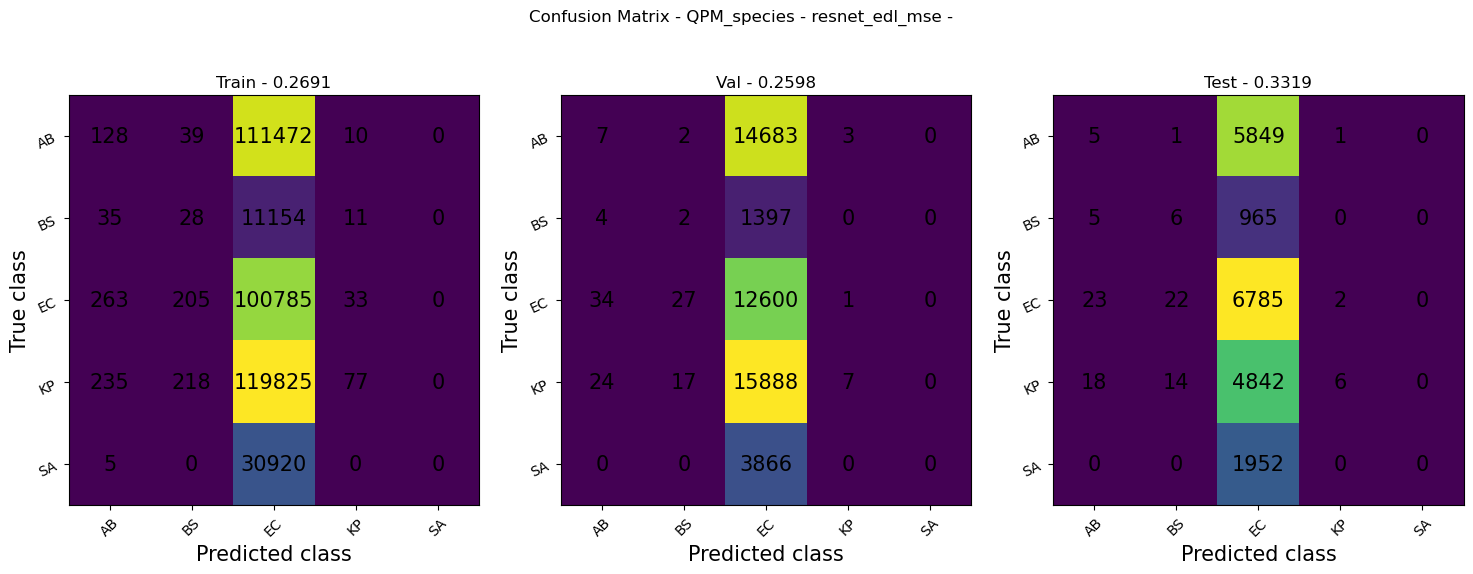

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(20496, 2) (0, 2)


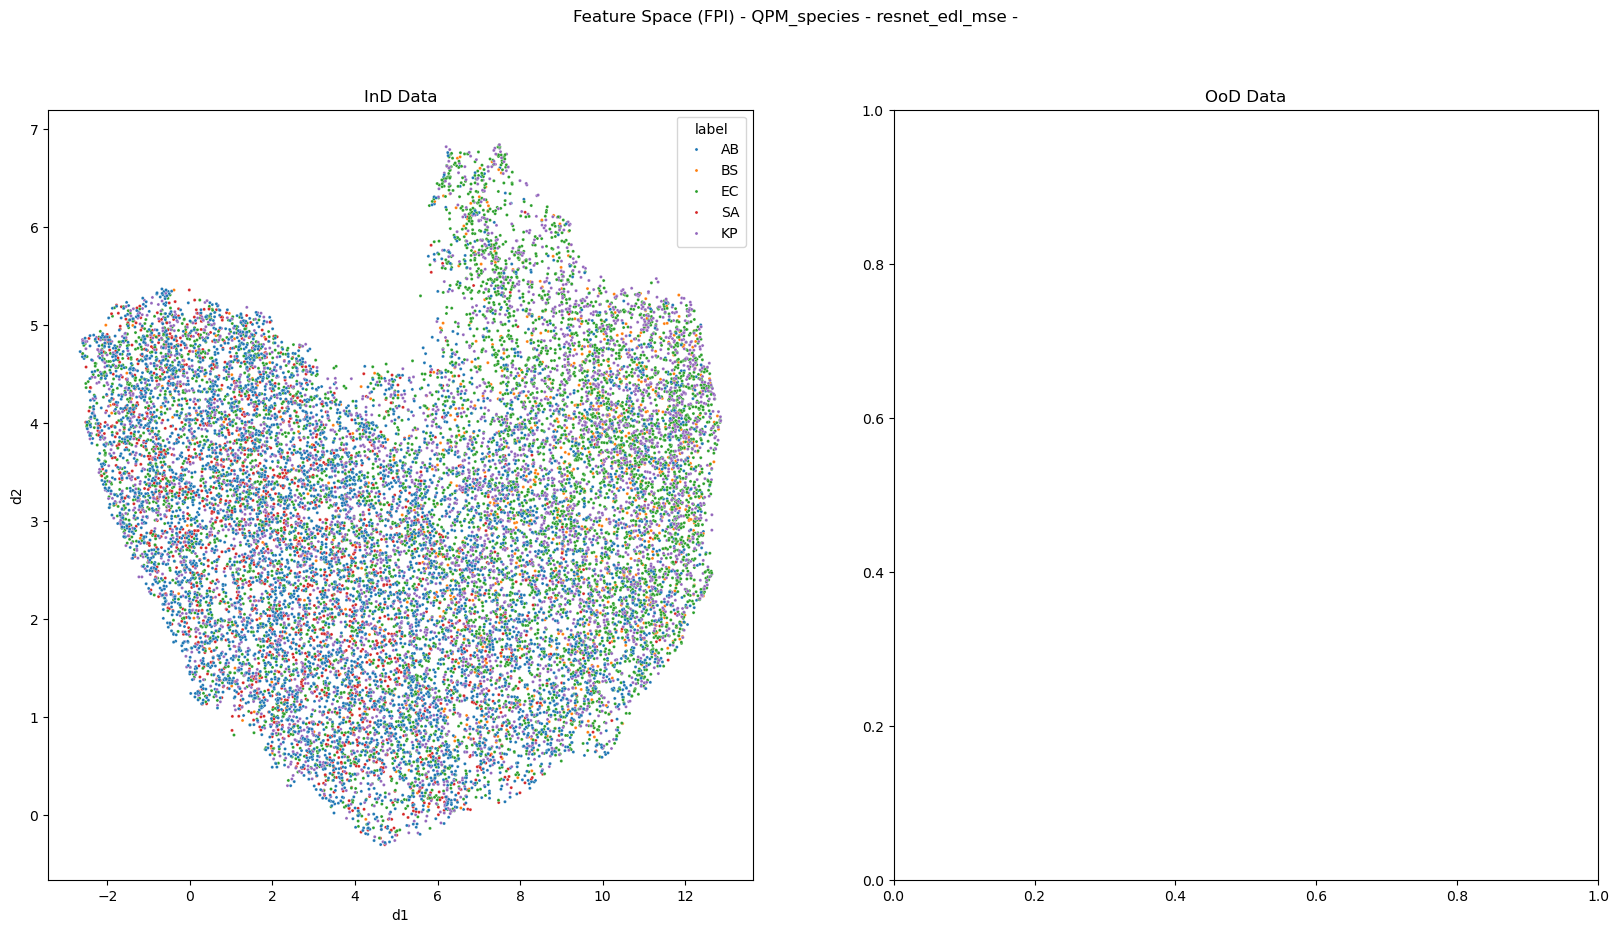

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

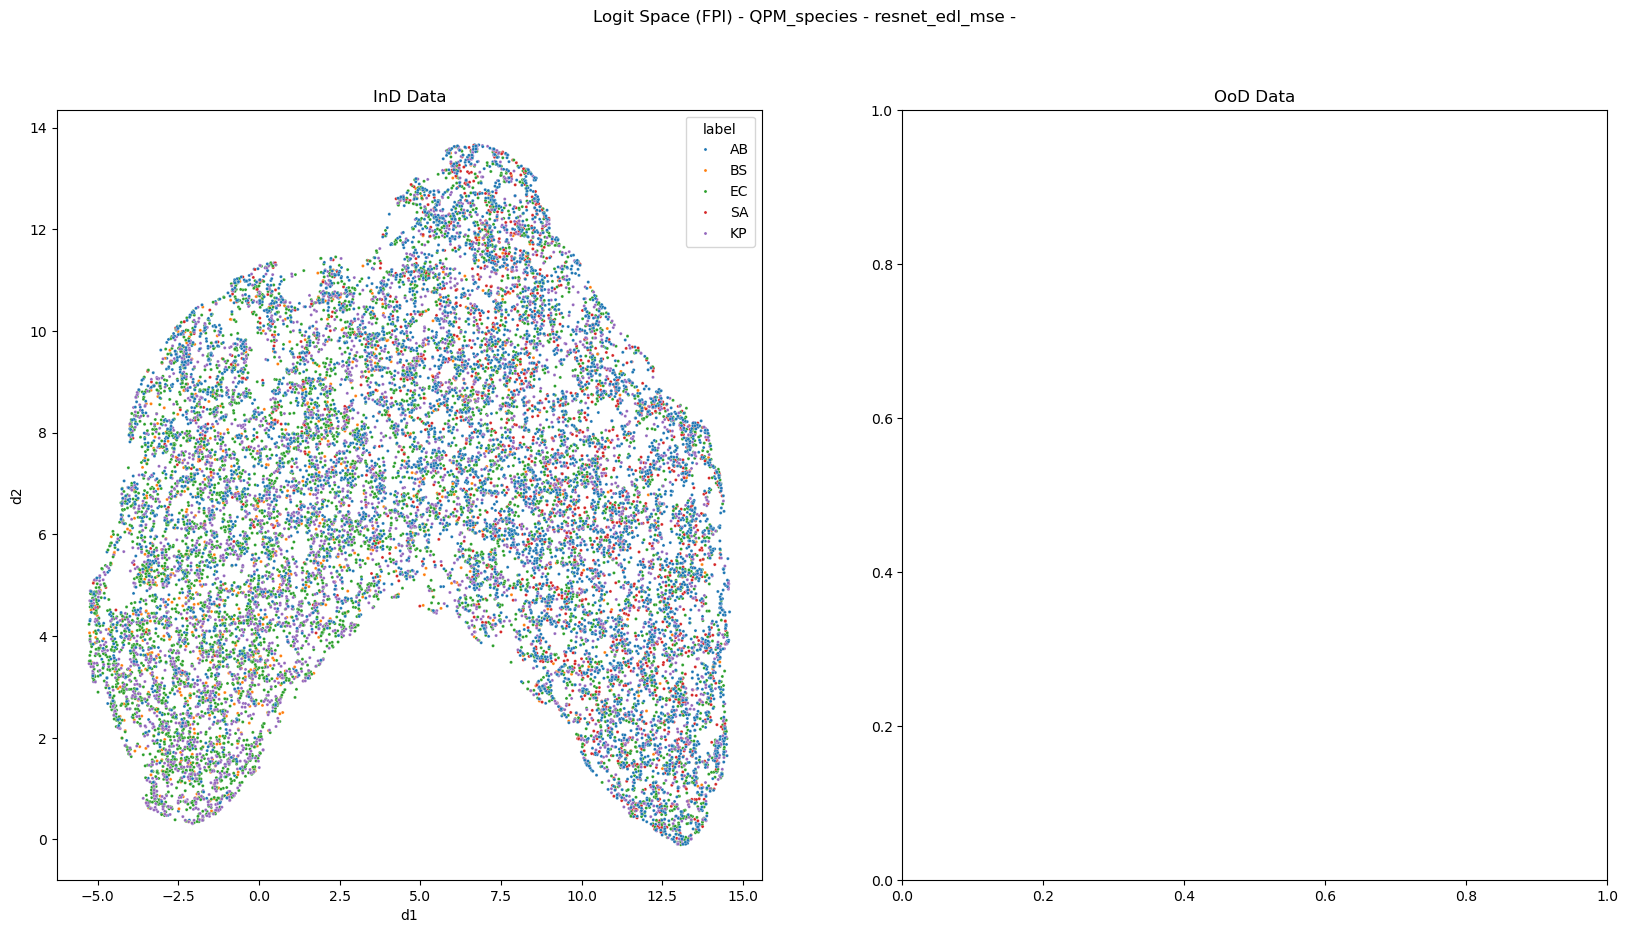

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

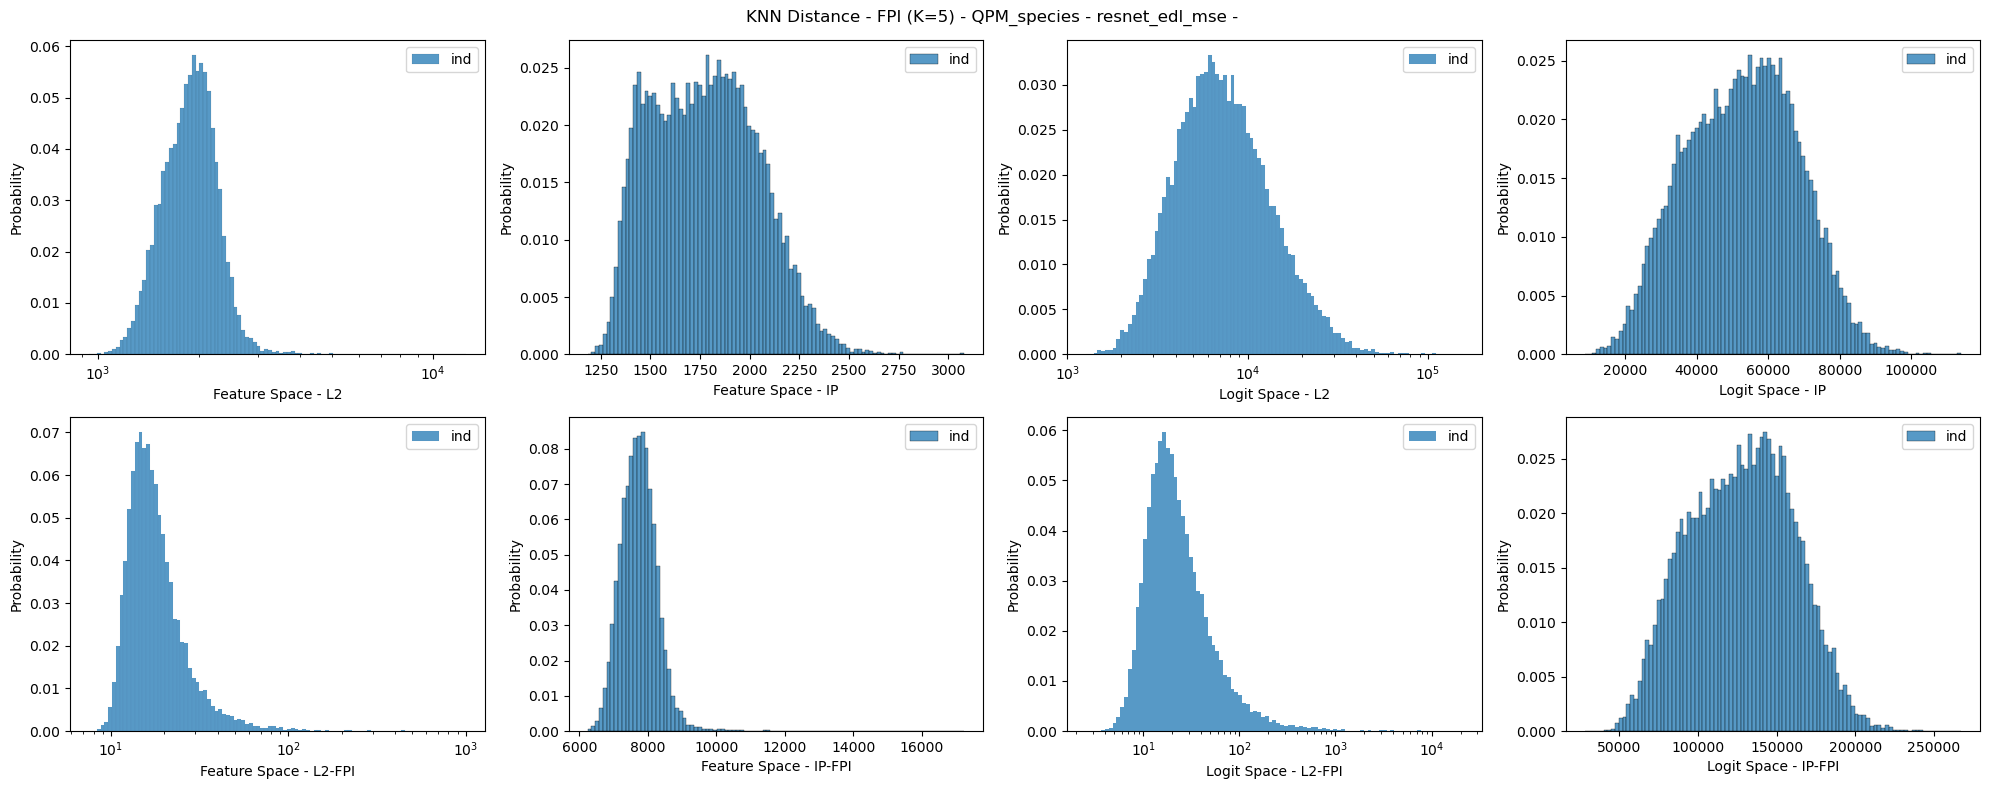

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
run_stats["knn_f_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
run_stats["knn_f_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
run_stats["knn_l_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
run_stats["knn_l_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

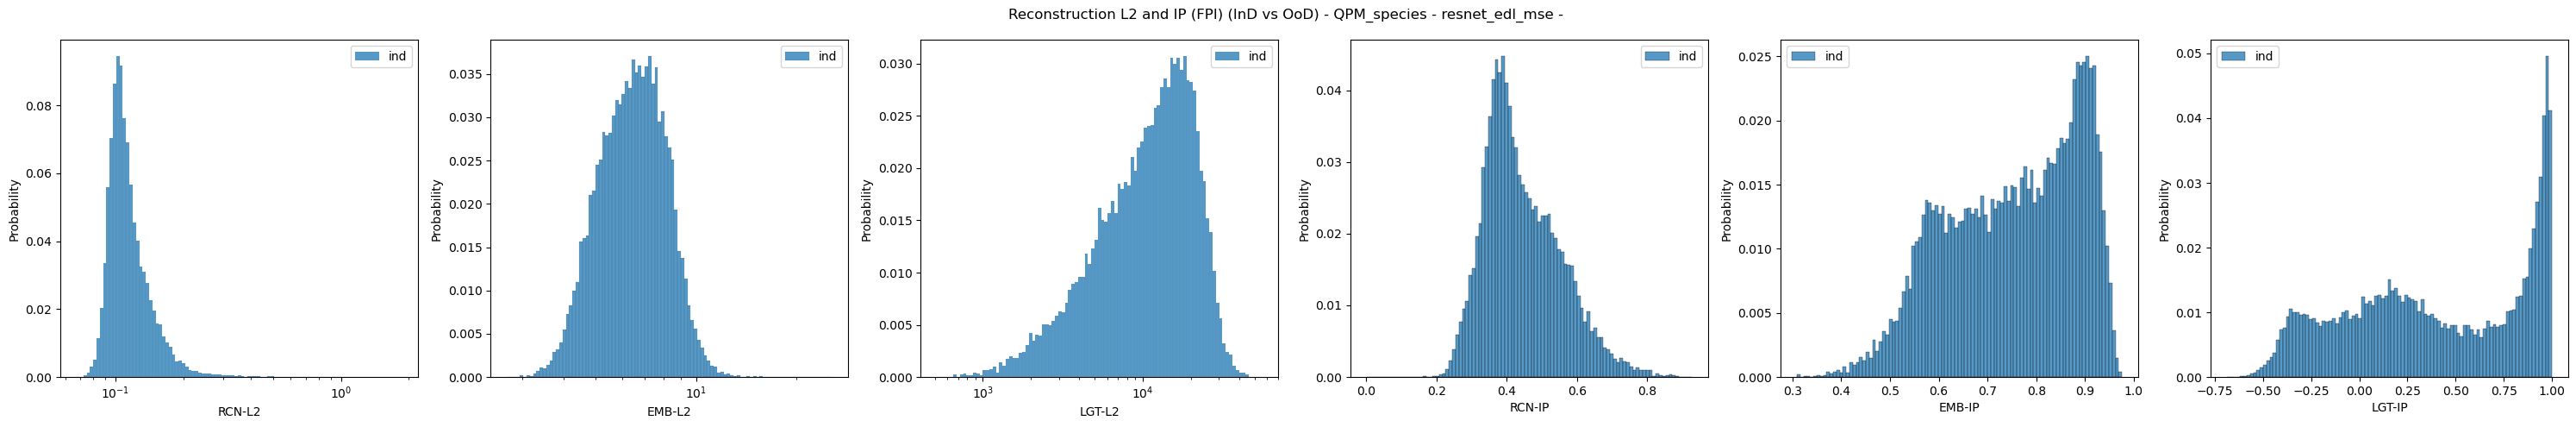

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["emb_l2"] = plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["lgt_l2"] = plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["emb_ip"] = plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["lgt_ip"] = plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

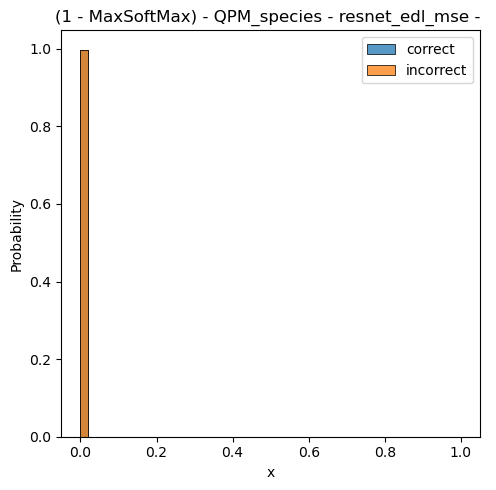

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

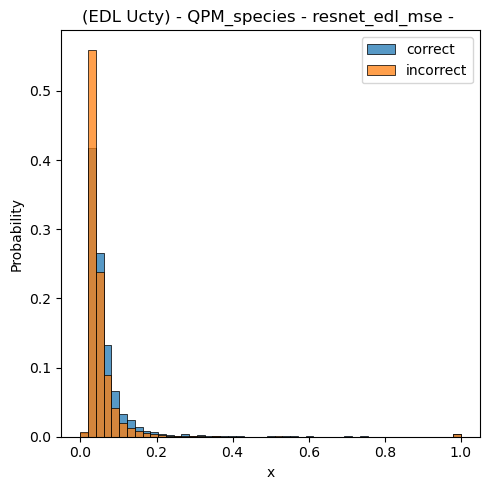

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [19]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)